# Лабораторная работа №5: Градиентный бустинг

### Загрузка библиотек и настройка визуализации

In [2]:
# Основные библиотеки для работы с данными
import pandas as pd
import numpy as np
from datetime import datetime

# Визуализация
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import seaborn as sns
from matplotlib import rcParams

# Машинное обучение - градиентный бустинг 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, BaggingClassifier, BaggingRegressor
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn import tree 
from sklearn.metrics import (confusion_matrix, classification_report, 
                           f1_score, precision_score, recall_score,
                           mean_squared_error, mean_absolute_error,
                           r2_score, mean_absolute_percentage_error, accuracy_score)

# Дополнительные метрики и инструменты для ансамблей
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.inspection import permutation_importance

# Предупреждения
import warnings
warnings.filterwarnings('ignore')

# Настройка визуализации
plt.style.use('seaborn-v0_8-darkgrid')
rcParams['figure.figsize'] = (12, 6)
rcParams['font.size'] = 12
sns.set_palette("husl")

### Загрузка и анализ датасета для Классификации (Employee Attrition)

Датасет загружен: 1470 строк, 35 столбцов

--- 1.1 Первичный обзор данных ---
Первые 5 строк датасета:
   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical       

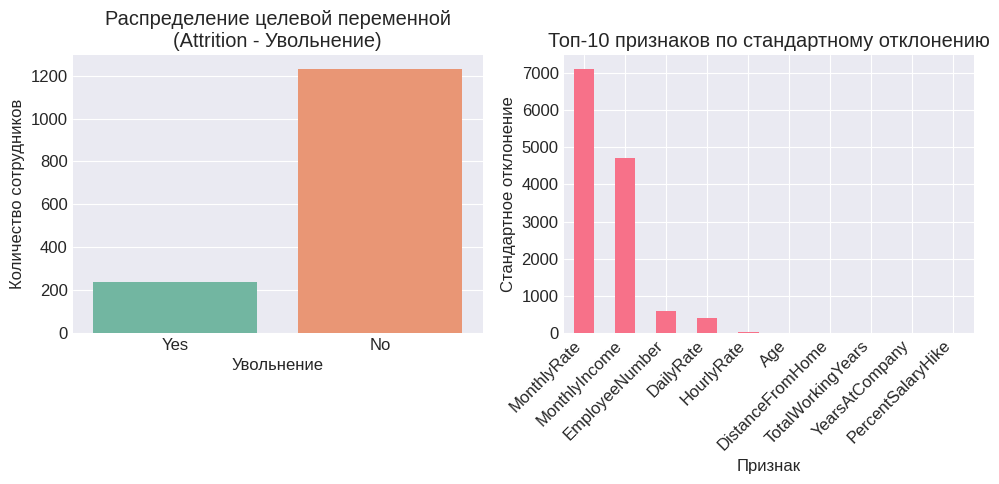


--- 1.7 Корреляционный анализ с целевой переменной ---
Топ-10 признаков по абсолютной корреляции с целевой переменной:
TotalWorkingYears       0.171063
JobLevel                0.169105
YearsInCurrentRole      0.160545
MonthlyIncome           0.159840
Age                     0.159205
YearsWithCurrManager    0.156199
StockOptionLevel        0.137145
YearsAtCompany          0.134392
JobInvolvement          0.130016
JobSatisfaction         0.103481
dtype: float64


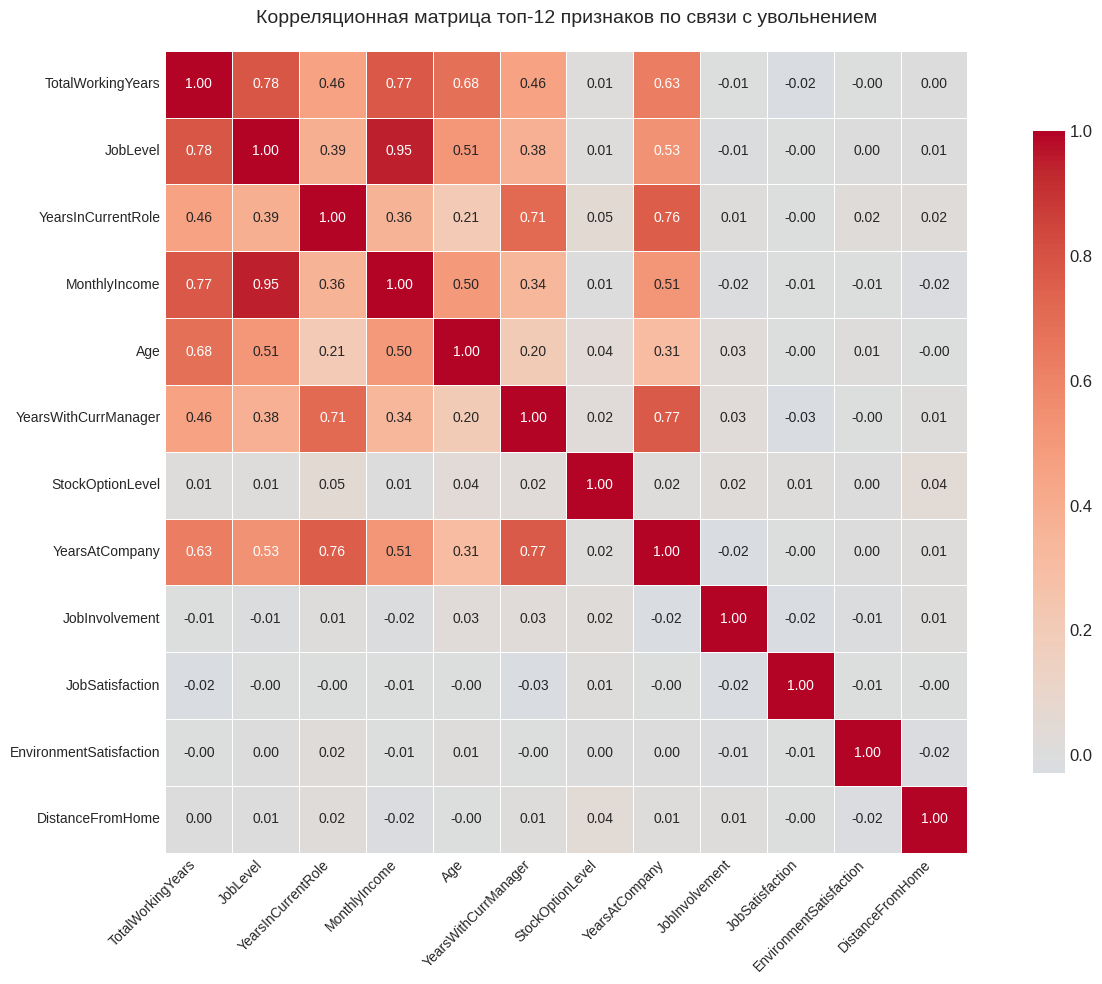

In [3]:
# Ячейка 1: АНАЛИЗ ДАТАСЕТА ДЛЯ КЛАССИФИКАЦИИ - ПРОГНОЗ УВОЛЬНЕНИЙ
# Загрузка датасета
df_class = pd.read_csv('Classification.csv')
print(f"Датасет загружен: {df_class.shape[0]} строк, {df_class.shape[1]} столбцов")

# 1.1 Первичный обзор данных
print("\n--- 1.1 Первичный обзор данных ---")
print("Первые 5 строк датасета:")
print(df_class.head())
print("\nИнформация о типах данных:")
print(df_class.info())

# 1.2 Статистическое описание числовых признаков
print("\n--- 1.2 Статистическое описание числовых признаков ---")
print(df_class.describe())

# 1.3 Проверка пропущенных значений
print("\n--- 1.3 Проверка пропущенных значений ---")
missing_values = df_class.isnull().sum()
missing_percent = (missing_values / len(df_class)) * 100

missing_df = pd.DataFrame({
    'Количество пропусков': missing_values,
    'Процент пропусков': missing_percent
}).sort_values('Количество пропусков', ascending=False)

print(missing_df[missing_df['Количество пропусков'] > 0])
if missing_df[missing_df['Количество пропусков'] > 0].empty:
    print("Пропуски в данных отсутствуют")

# 1.4 Анализ целевой переменной (Attrition)
print("\n--- 1.4 Анализ целевой переменной (Attrition) ---")
target_counts = df_class['Attrition'].value_counts()
target_percent = df_class['Attrition'].value_counts(normalize=True) * 100

print(f"Распределение классов:\n{target_counts}")
print(f"\nПроцентное соотношение:\n{target_percent.round(2)}")

# Визуализация распределения целевой переменной
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=df_class, x='Attrition', palette='Set2')
plt.title('Распределение целевой переменной\n(Attrition - Увольнение)')
plt.xlabel('Увольнение')
plt.ylabel('Количество сотрудников')

# 1.5 Анализ категориальных признаков
print("\n--- 1.5 Анализ категориальных признаков ---")
categorical_cols = df_class.select_dtypes(include=['object']).columns
print(f"Найдено категориальных признаков: {len(categorical_cols)}")

for col in categorical_cols:
    unique_vals = df_class[col].nunique()
    print(f"  {col}: {unique_vals} уникальных значений")

# 1.6 Анализ стандартных отклонений числовых признаков
print("\n--- 1.6 Анализ стандартных отклонений числовых признаков ---")
numeric_cols = df_class.select_dtypes(include=[np.number]).columns
std_dev = df_class[numeric_cols].std()

std_df = pd.DataFrame({
    'Стандартное отклонение': std_dev,
    'Среднее значение': df_class[numeric_cols].mean(),
    'Коэффициент вариации': (std_dev / df_class[numeric_cols].mean() * 100).round(2)
}).sort_values('Стандартное отклонение', ascending=False)

print("Топ-10 признаков с наибольшим стандартным отклонением:")
print(std_df.head(10))

# Визуализация стандартных отклонений
plt.subplot(1, 2, 2)
std_df.head(10)['Стандартное отклонение'].plot(kind='bar')
plt.title('Топ-10 признаков по стандартному отклонению')
plt.xlabel('Признак')
plt.ylabel('Стандартное отклонение')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 1.7 Корреляционный анализ с целевой переменной
print("\n--- 1.7 Корреляционный анализ с целевой переменной ---")
# Преобразование целевой переменной в числовой формат для корреляции
df_class['Attrition_numeric'] = df_class['Attrition'].map({'Yes': 1, 'No': 0})
correlations = df_class[numeric_cols].corrwith(df_class['Attrition_numeric']).abs().sort_values(ascending=False)

print("Топ-10 признаков по абсолютной корреляции с целевой переменной:")
print(correlations.head(10))

# Визуализация корреляционной матрицы
plt.figure(figsize=(14, 10))
top_corr_features = correlations.head(12).index
corr_matrix = df_class[top_corr_features].corr()

# Настройка размера шрифта и формата чисел
annot_kws = {"size": 10, "weight": "normal"}
fmt = '.2f'  # Формат отображения чисел (2 знака после запятой)

heatmap = sns.heatmap(corr_matrix, 
                     annot=True, 
                     fmt=fmt,
                     cmap='coolwarm', 
                     center=0, 
                     square=True, 
                     linewidths=0.5,
                     cbar_kws={"shrink": 0.8},
                     annot_kws=annot_kws)

# Настройка подписей осей
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.title('Корреляционная матрица топ-12 признаков по связи с увольнением', 
          fontsize=14, pad=20)
plt.tight_layout()
plt.show()

### Загрузка и анализ датасета для Регрессии (House Sales)

Датасет загружен: 21613 строк, 21 столбцов

--- 2.1 Первичный обзор данных ---
Первые 5 строк датасета:
           id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0        

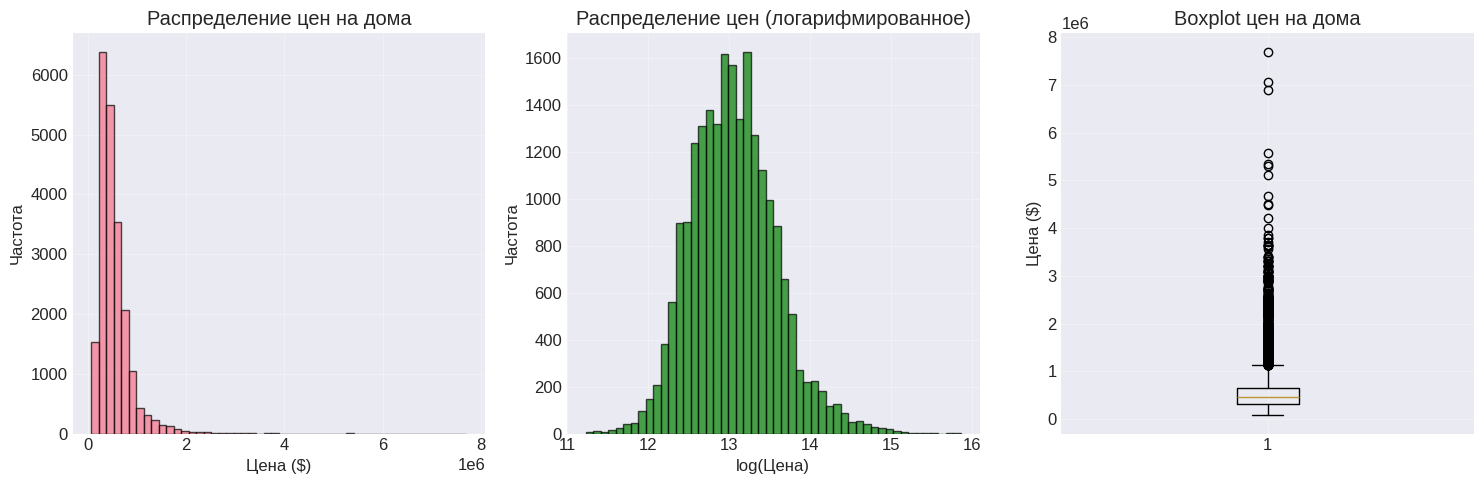


--- 2.5 Анализ стандартных отклонений ---
Топ-10 признаков с наибольшим стандартным отклонением:
               Стандартное отклонение  Среднее значение  Коэффициент вариации
id                       2.876566e+09      4.580302e+09                 62.80
price                    3.671272e+05      5.400881e+05                 67.98
sqft_lot                 4.142051e+04      1.510697e+04                274.18
sqft_lot15               2.730418e+04      1.276846e+04                213.84
sqft_living              9.184409e+02      2.079900e+03                 44.16
sqft_above               8.280910e+02      1.788391e+03                 46.30
sqft_living15            6.853913e+02      1.986552e+03                 34.50
sqft_basement            4.425750e+02      2.915090e+02                151.82
yr_renovated             4.016792e+02      8.440226e+01                475.91
zipcode                  5.350503e+01      9.807794e+04                  0.05

--- 2.6 Корреляция с целевой переменной (pr

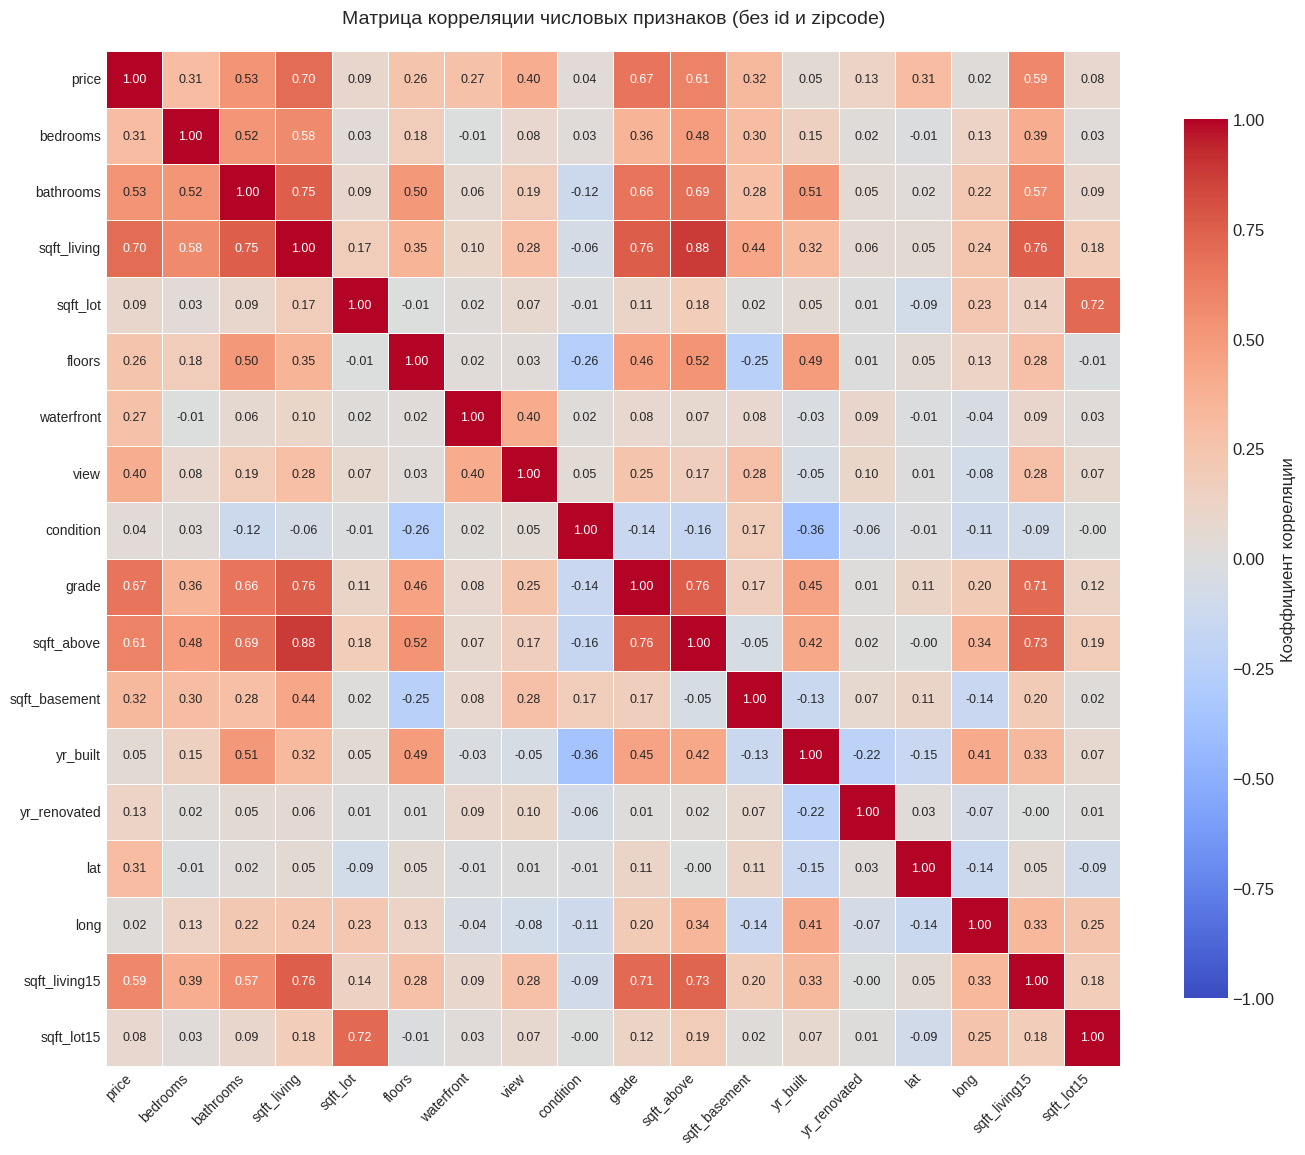


--- Анализ наиболее коррелирующих признаков ---
Пары признаков с высокой корреляцией (|r| > 0.7):
------------------------------------------------------------
  sqft_living     и sqft_above      => 0.877
  sqft_living     и grade           => 0.763
  sqft_living     и sqft_living15   => 0.756
  grade           и sqft_above      => 0.756
  bathrooms       и sqft_living     => 0.755
  sqft_above      и sqft_living15   => 0.732
  sqft_lot        и sqft_lot15      => 0.719
  grade           и sqft_living15   => 0.713
  price           и sqft_living     => 0.702

--- 2.7 Анализ выбросов в ключевых признаках ---
sqft_living    :  572 выбросов (2.6%)
sqft_lot       : 2425 выбросов (11.2%)
bedrooms       :  546 выбросов (2.5%)
bathrooms      :  571 выбросов (2.6%)
grade          : 1911 выбросов (8.8%)


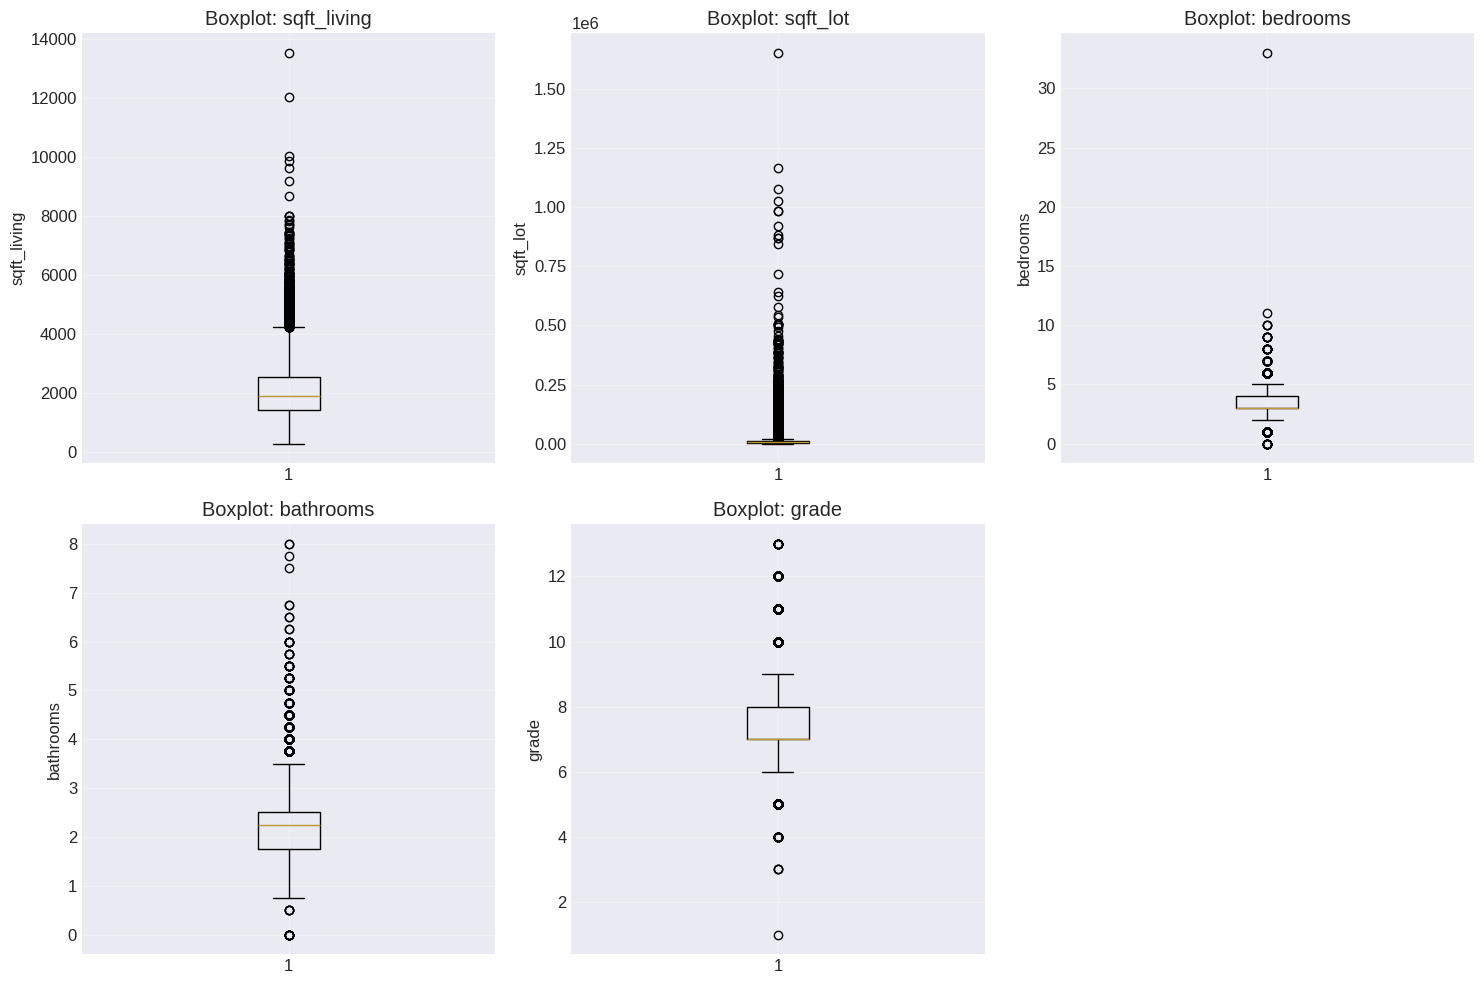

In [4]:
# Ячейка 2: АНАЛИЗ ДАТАСЕТА ДЛЯ РЕГРЕССИИ - ПРОГНОЗ ЦЕН НА ДОМА
# Загрузка датасета
df_reg = pd.read_csv('Regression.csv')
print(f"Датасет загружен: {df_reg.shape[0]} строк, {df_reg.shape[1]} столбцов")

# 2.1 Первичный обзор данных
print("\n--- 2.1 Первичный обзор данных ---")
print("Первые 5 строк датасета:")
print(df_reg.head())
print("\nИнформация о типах данных:")
print(df_reg.info())

# 2.2 Статистическое описание
print("\n--- 2.2 Статистическое описание ---")
print(df_reg.describe())

# 2.3 Проверка пропущенных значений
print("\n--- 2.3 Проверка пропущенных значений ---")
missing_values_reg = df_reg.isnull().sum()
missing_percent_reg = (missing_values_reg / len(df_reg)) * 100

missing_df_reg = pd.DataFrame({
    'Количество пропусков': missing_values_reg,
    'Процент пропусков': missing_percent_reg
}).sort_values('Количество пропусков', ascending=False)

print(missing_df_reg[missing_df_reg['Количество пропусков'] > 0])
if missing_df_reg[missing_df_reg['Количество пропусков'] > 0].empty:
    print("Пропуски в данных отсутствуют")

# 2.4 Анализ целевой переменной (price)
print("\n--- 2.4 Анализ целевой переменной (price) ---")
price_stats = {
    'Медиана': df_reg['price'].median(),
    'Среднее значение': df_reg['price'].mean(),
    'Стандартное отклонение': df_reg['price'].std(),
    'Минимальная цена': df_reg['price'].min(),
    'Максимальная цена': df_reg['price'].max(),
    'Коэффициент вариации': (df_reg['price'].std() / df_reg['price'].mean() * 100)
}

for key, value in price_stats.items():
    if key != 'Коэффициент вариации':
        print(f"{key}: ${value:,.2f}")
    else:
        print(f"{key}: {value:.2f}%")

# Визуализация распределения цены
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df_reg['price'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Распределение цен на дома')
plt.xlabel('Цена ($)')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.hist(np.log1p(df_reg['price']), bins=50, edgecolor='black', alpha=0.7, color='green')
plt.title('Распределение цен (логарифмированное)')
plt.xlabel('log(Цена)')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.boxplot(df_reg['price'])
plt.title('Boxplot цен на дома')
plt.ylabel('Цена ($)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2.5 Анализ стандартных отклонений
print("\n--- 2.5 Анализ стандартных отклонений ---")
numeric_cols_reg = df_reg.select_dtypes(include=[np.number]).columns
std_dev_reg = df_reg[numeric_cols_reg].std()

std_df_reg = pd.DataFrame({
    'Стандартное отклонение': std_dev_reg,
    'Среднее значение': df_reg[numeric_cols_reg].mean(),
    'Коэффициент вариации': (std_dev_reg / df_reg[numeric_cols_reg].mean() * 100).round(2)
}).sort_values('Стандартное отклонение', ascending=False)

print("Топ-10 признаков с наибольшим стандартным отклонением:")
print(std_df_reg.head(10))

# 2.6 Корреляция с целевой переменной (price)
print("\n--- 2.6 Корреляция с целевой переменной (price) ---")

# Исключаем неинформативные признаки (id, zipcode - это категориальные коды, а не числовые признаки)
exclude_features = ['id', 'zipcode']
numeric_features = [col for col in numeric_cols_reg if col not in exclude_features]

correlations_reg = df_reg[numeric_features].corrwith(df_reg['price']).abs().sort_values(ascending=False)

print("Топ-10 признаков по абсолютной корреляции с ценой:")
for i, (feature, corr_value) in enumerate(correlations_reg.head(10).items(), 1):
    actual_corr = df_reg[numeric_features].corrwith(df_reg['price'])[feature]
    print(f"{i:2}. {feature:20} {actual_corr:+.3f}")

# Визуализация матрицы корреляции
print("\n--- Матрица корреляции (без id и zipcode) ---")

# Создаем матрицу корреляции для осмысленных числовых признаков
corr_matrix = df_reg[numeric_features].corr()

# Определяем размер фигуры в зависимости от количества признаков
n_features = len(corr_matrix.columns)
figsize = max(14, n_features * 0.6), max(12, n_features * 0.6)

plt.figure(figsize=figsize)

# Создаем тепловую карту корреляций
sns.heatmap(corr_matrix, 
           annot=True, 
           fmt='.2f',
           cmap='coolwarm', 
           vmin=-1, vmax=1,
           center=0,
           square=True,
           linewidths=0.5,
           cbar_kws={"shrink": 0.8, "label": "Коэффициент корреляции"},
           annot_kws={"size": 9})

plt.title('Матрица корреляции числовых признаков (без id и zipcode)', fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

# Дополнительная информация о наиболее коррелирующих признаках
print("\n--- Анализ наиболее коррелирующих признаков ---")

# Находим пары признаков с высокой корреляцией
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > 0.7:
            feat1 = corr_matrix.columns[i]
            feat2 = corr_matrix.columns[j]
            high_corr_pairs.append((feat1, feat2, corr_value))

if high_corr_pairs:
    print("Пары признаков с высокой корреляцией (|r| > 0.7):")
    print("-" * 60)
    for feat1, feat2, corr_value in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"  {feat1:15} и {feat2:15} => {corr_value:.3f}")
else:
    print("Нет пар признаков с высокой корреляцией (|r| > 0.7)")

# 2.7 Анализ выбросов в ключевых признаках
print("\n--- 2.7 Анализ выбросов в ключевых признаках ---")
key_features = ['sqft_living', 'sqft_lot', 'bedrooms', 'bathrooms', 'grade']

# Базовая информация о выбросах
for feature in key_features:
    if feature in df_reg.columns:
        Q1 = df_reg[feature].quantile(0.25)
        Q3 = df_reg[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df_reg[(df_reg[feature] < lower_bound) | (df_reg[feature] > upper_bound)]
        n_outliers = len(outliers)
        
        print(f"{feature:15}: {n_outliers:4} выбросов ({n_outliers/len(df_reg)*100:.1f}%)")

# Визуализация
plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features, 1):
    if feature in df_reg.columns:
        plt.subplot(2, 3, i)
        plt.boxplot(df_reg[feature].dropna())
        plt.title(f'Boxplot: {feature}')
        plt.ylabel(feature)
        plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 2. Создание безлайна и оценка качества

### Предобработка данных для задачи классификации

In [5]:
# Ячейка 3: ПРЕДОБРАБОТКА ДАННЫХ ДЛЯ ГРАДИЕНТНОГО БУСТИНГА (КЛАССИФИКАЦИЯ)
# 3.1 Создаем копию данных для обработки
df_class_processed = df_class.copy()
print("Создана копия данных для предобработки")

# 3.2 Удаляем неинформативные признаки И Attrition_numeric
print("\n--- 3.1 Удаление неинформативных признаков ---")

columns_to_drop = [
    'EmployeeCount',      # Все значения = 1
    'EmployeeNumber',     # Уникальный идентификатор
    'Over18',             # Все значения = 'Y'
    'StandardHours',      # Все значения = 80
    'Attrition_numeric'   # Временная числовая версия
]

print(f"Удаляем признаки: {columns_to_drop}")
df_class_processed = df_class_processed.drop(columns=columns_to_drop, errors='ignore')
print(f"Осталось признаков: {df_class_processed.shape[1]}")

# 3.3 Преобразование целевой переменной
print("\n--- 3.3 Преобразование целевой переменной ---")
df_class_processed['Attrition'] = df_class_processed['Attrition'].map({'Yes': 1, 'No': 0})
print("Целевая переменная Attrition преобразована: Yes -> 1, No -> 0")

# Анализ дисбаланса (ВАЖНО для Gradient Boosting)
print(f"\nСоотношение классов: {sum(df_class_processed['Attrition'] == 0)}:1")
print(f"Процент класса 'Yes' (уволился): {df_class_processed['Attrition'].mean()*100:.1f}%")

# Расчет scale_pos_weight для GradientBoosting
positive_class = sum(df_class_processed['Attrition'] == 1)
negative_class = sum(df_class_processed['Attrition'] == 0)
scale_pos_weight_value = negative_class / positive_class
print(f"\nРекомендуемое scale_pos_weight: {scale_pos_weight_value:.2f}")

# 3.4 Обработка категориальных признаков
print("\n--- 3.4 Обработка категориальных признаков ---")

categorical_cols = df_class_processed.select_dtypes(include=['object']).columns.tolist()
print(f"Категориальные признаки для обработки ({len(categorical_cols)}):")

# Анализируем категориальные признаки
for col in categorical_cols:
    unique_vals = df_class_processed[col].nunique()
    value_counts = df_class_processed[col].value_counts()
    print(f"  {col}: {unique_vals} уникальных значений")
    print(f"    Распределение: {dict(value_counts.head(3))}")

# Label Encoding для Gradient Boosting (предпочтительнее чем One-Hot для многих категорий)
print("\nПрименяем Label Encoding для категориальных признаков (альтернатива: One-Hot)...")
from sklearn.preprocessing import LabelEncoder

df_class_encoded = df_class_processed.copy()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_class_encoded[col] = le.fit_transform(df_class_encoded[col])
    label_encoders[col] = le
    print(f"  Закодирован {col}")

# Альтернативно, можно использовать One-Hot Encoding (раскомментировать при необходимости):
# df_class_encoded = pd.get_dummies(df_class_processed, columns=categorical_cols, drop_first=True)
# print(f"После One-Hot Encoding: {df_class_encoded.shape[1]} признаков")

print(f"\nПосле кодирования: {df_class_encoded.shape[1]} признаков")

# 3.5 Разделение на признаки и целевую переменную
print("\n--- 3.5 Разделение данных ---")
X_class = df_class_encoded.drop('Attrition', axis=1)
y_class = df_class_encoded['Attrition']

print(f"Признаки (X): {X_class.shape}")
print(f"Целевая переменная (y): {y_class.shape}")
print(f"Имена признаков: {list(X_class.columns[:5])}...")

# 3.6 Подготовка признаков для Gradient Boosting
print("\n--- 3.6 Подготовка признаков ---")
# Gradient Boosting тоже не требует масштабирования признаков!
print("Gradient Boosting не требует масштабирования признаков - работаем с исходными значениями")
X_class_prepared = X_class.values  # Просто преобразуем в numpy array

# 3.7 Разделение на обучающую и тестовую выборки
print("\n--- 3.7 Разделение на train/test ---")
print("Используем stratify=y_class для сохранения пропорций классов")
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class_prepared, y_class, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_class
)

print(f"Обучающая выборка: {X_train_class.shape}")
print(f"Тестовая выборка: {X_test_class.shape}")
print(f"Распределение классов в train: {np.bincount(y_train_class)}")
print(f"Распределение классов в test: {np.bincount(y_test_class)}")

# Сохраняем важную информацию для Gradient Boosting
feature_names_class = X_class.columns.tolist()


Создана копия данных для предобработки

--- 3.1 Удаление неинформативных признаков ---
Удаляем признаки: ['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours', 'Attrition_numeric']
Осталось признаков: 31

--- 3.3 Преобразование целевой переменной ---
Целевая переменная Attrition преобразована: Yes -> 1, No -> 0

Соотношение классов: 1233:1
Процент класса 'Yes' (уволился): 16.1%

Рекомендуемое scale_pos_weight: 5.20

--- 3.4 Обработка категориальных признаков ---
Категориальные признаки для обработки (7):
  BusinessTravel: 3 уникальных значений
    Распределение: {'Travel_Rarely': 1043, 'Travel_Frequently': 277, 'Non-Travel': 150}
  Department: 3 уникальных значений
    Распределение: {'Research & Development': 961, 'Sales': 446, 'Human Resources': 63}
  EducationField: 6 уникальных значений
    Распределение: {'Life Sciences': 606, 'Medical': 464, 'Marketing': 159}
  Gender: 2 уникальных значений
    Распределение: {'Male': 882, 'Female': 588}
  JobRole: 9 уникальных значений
 

### Предобработка данных для задачи регрессии

In [7]:
# Ячейка 4: ПРЕДОБРАБОТКА ДАННЫХ ДЛЯ ГРАДИЕНТНОГО БУСТИНГА РЕГРЕССИИ
# 4.1 Создаем копию данных для обработки
df_reg_processed = df_reg.copy()
print("Создана копия данных для предобработки")

# 4.2 Удаляем неинформативные признаки
print("\n--- 4.1 Удаление неинформативных признаков ---")

columns_to_drop_reg = ['id', 'zipcode']
print(f"Удаляем признаки: {columns_to_drop_reg}")
df_reg_processed = df_reg_processed.drop(columns=columns_to_drop_reg, errors='ignore')
print(f"Осталось признаков: {df_reg_processed.shape[1]}")

# 4.3 Обработка признака date
print("\n--- 4.3 Обработка временных признаков ---")

if 'date' in df_reg_processed.columns:
    df_reg_processed['date'] = pd.to_datetime(df_reg_processed['date'])
    df_reg_processed['sale_year'] = df_reg_processed['date'].dt.year
    df_reg_processed['sale_month'] = df_reg_processed['date'].dt.month
    df_reg_processed['sale_season'] = df_reg_processed['sale_month'].apply(
        lambda x: 1 if x in [12, 1, 2] else 2 if x in [3, 4, 5] else 3 if x in [6, 7, 8] else 4
    )
    df_reg_processed = df_reg_processed.drop('date', axis=1)
    print(f"Извлечены признаки из даты: sale_year, sale_month, sale_season")

# 4.4 Обработка выбросов (Gradient Boosting более чувствителен к выбросам чем Random Forest)
print("\n--- 4.4 Обработка выбросов для Gradient Boosting ---")

# Спальни: исправляем явные ошибки (0 или >10 спален)
if 'bedrooms' in df_reg_processed.columns:
    bedrooms_median = df_reg_processed['bedrooms'].median()
    mask_bedrooms = (df_reg_processed['bedrooms'] < 1) | (df_reg_processed['bedrooms'] > 10)
    if mask_bedrooms.any():
        n_bed = mask_bedrooms.sum()
        df_reg_processed.loc[mask_bedrooms, 'bedrooms'] = bedrooms_median
        print(f"Спальни: {n_bed} некорректных значений заменены на медиану ({bedrooms_median})")

# Ванные: исправляем явные ошибки (0 или >10 ванных)
if 'bathrooms' in df_reg_processed.columns:
    bathrooms_median = df_reg_processed['bathrooms'].median()
    mask_bathrooms = (df_reg_processed['bathrooms'] < 1) | (df_reg_processed['bathrooms'] > 10)
    if mask_bathrooms.any():
        n_bath = mask_bathrooms.sum()
        df_reg_processed.loc[mask_bathrooms, 'bathrooms'] = bathrooms_median
        print(f"Ванные: {n_bath} некорректных значений заменены на медиану ({bathrooms_median:.1f})")

# Дополнительная обработка экстремальных значений для Gradient Boosting
print("\nДополнительная обработка для Gradient Boosting:")

# Обработка экстремальных значений в площади (sqft_living, sqft_lot)
extreme_cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
for col in extreme_cols:
    if col in df_reg_processed.columns:
        Q1 = df_reg_processed[col].quantile(0.01)
        Q3 = df_reg_processed[col].quantile(0.99)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        
        n_outliers = ((df_reg_processed[col] < lower_bound) | (df_reg_processed[col] > upper_bound)).sum()
        if n_outliers > 0:
            # Winsorization - обрезаем экстремальные значения
            df_reg_processed[col] = df_reg_processed[col].clip(lower=lower_bound, upper=upper_bound)
            print(f"  {col}: {n_outliers} экстремальных значений обрезано ({n_outliers/len(df_reg_processed)*100:.1f}%)")

# 4.5 Логарифмирование целевой переменной (ОЧЕНЬ ВАЖНО для Gradient Boosting регрессии)
print("\n--- 4.5 Логарифмирование целевой переменной ---")

# Логарифмируем цену (критически важно для GB с неравномерным распределением)
df_reg_processed['price_log'] = np.log1p(df_reg_processed['price'])
target_col = 'price_log'

print("Целевая переменная логарифмирована: создан price_log")
print(f"Среднее логарифмированной цены: {df_reg_processed['price_log'].mean():.2f}")
print(f"Стандартное отклонение: {df_reg_processed['price_log'].std():.2f}")

# 4.6 Разделение на признаки и целевую переменную
print("\n--- 4.6 Разделение данных ---")

# Собираем все числовые признаки
all_numeric_features = df_reg_processed.select_dtypes(include=[np.number]).columns.tolist()

# Убираем price и price_log из признаков
numeric_features_reg = [col for col in all_numeric_features if col not in ['price', 'price_log']]

X_reg = df_reg_processed[numeric_features_reg]
y_reg = df_reg_processed[target_col]  # Используем price_log как целевую

print(f"Признаки (X): {X_reg.shape}")
print(f"Целевая переменная (y, log): {y_reg.shape}")
print(f"Примеры признаков: {numeric_features_reg[:10]}")

# 4.7 Подготовка признаков для Gradient Boosting
print("\n--- 4.7 Подготовка признаков ---")

# Проверка мультиколлинеарности
if len(numeric_features_reg) > 1:
    corr_matrix = X_reg.corr().abs()
    high_corr_indices = np.where(corr_matrix > 0.8)
    high_corr_pairs = [(numeric_features_reg[i], numeric_features_reg[j], corr_matrix.iloc[i, j]) 
                       for i, j in zip(*high_corr_indices) if i < j]
    
    if high_corr_pairs:
        print("\nОбнаружена высокая корреляция между признаками (|r| > 0.8):")
        for feat1, feat2, corr_value in high_corr_pairs[:5]:  # Показываем первые 5
            print(f"  {feat1:15} и {feat2:15}: {corr_value:.3f}")
        print("Рекомендация: рассмотреть удаление одного из сильно коррелирующих признаков")

X_reg_prepared = X_reg.values  # Просто преобразуем в numpy array

# 4.8 Разделение на обучающую и тестовую выборки
print("\n--- 4.8 Разделение на train/test ---")

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg_prepared, y_reg, test_size=0.2, random_state=42
)

print(f"Обучающая выборка: {X_train_reg.shape}")
print(f"Тестовая выборка: {X_test_reg.shape}")
print(f"Диапазон целевой переменной в train: [{y_train_reg.min():.2f}, {y_train_reg.max():.2f}]")
print(f"Диапазон целевой переменной в test: [{y_test_reg.min():.2f}, {y_test_reg.max():.2f}]")

# Рекомендации по параметрам GradientBoostingRegressor
print(f"\n--- Рекомендации по настройке GradientBoostingRegressor ---")
print(f"Количество признаков: {X_train_reg.shape[1]}")
print(f"Размер обучающей выборки: {X_train_reg.shape[0]}")

# Сохраняем имена признаков для анализа важности
feature_names_reg = numeric_features_reg
print(f"\nСохранены имена {len(feature_names_reg)} признаков для анализа важности")

Создана копия данных для предобработки

--- 4.1 Удаление неинформативных признаков ---
Удаляем признаки: ['id', 'zipcode']
Осталось признаков: 19

--- 4.3 Обработка временных признаков ---
Извлечены признаки из даты: sale_year, sale_month, sale_season

--- 4.4 Обработка выбросов для Gradient Boosting ---
Спальни: 15 некорректных значений заменены на медиану (3.0)
Ванные: 86 некорректных значений заменены на медиану (2.2)

Дополнительная обработка для Gradient Boosting:
  sqft_lot: 10 экстремальных значений обрезано (0.0%)

--- 4.5 Логарифмирование целевой переменной ---
Целевая переменная логарифмирована: создан price_log
Среднее логарифмированной цены: 13.05
Стандартное отклонение: 0.53

--- 4.6 Разделение данных ---
Признаки (X): (21613, 20)
Целевая переменная (y, log): (21613,)
Примеры признаков: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above']

--- 4.7 Подготовка признаков ---

Обнаружена высокая корреляция меж

### Построение безлайна для классификации


--- 5.1 Обучение базовой модели градиентного бустинга ---
Анализ дисбаланса классов в обучающей выборке:
  Класс 0 (Не уйдет): 986 наблюдений
  Класс 1 (Уйдет): 190 наблюдений
  Соотношение: 5.2:1

Обучаем модель градиентного бустинга...
Модель обучена успешно! Время обучения: 0.19 секунд

Количество обученных деревьев: 61
Ошибка на обучающей выборке: 0.4416

--- 5.2 Анализ важности признаков ---
Топ-15 самых важных признаков для градиентного бустинга:
  Age                            → 0.0991
  MonthlyIncome                  → 0.0989
  OverTime                       → 0.0988
  TotalWorkingYears              → 0.0654
  NumCompaniesWorked             → 0.0576
  YearsWithCurrManager           → 0.0495
  DailyRate                      → 0.0468
  JobRole                        → 0.0431
  DistanceFromHome               → 0.0430
  EnvironmentSatisfaction        → 0.0420
  StockOptionLevel               → 0.0397
  YearsAtCompany                 → 0.0343
  HourlyRate                     → 0.0

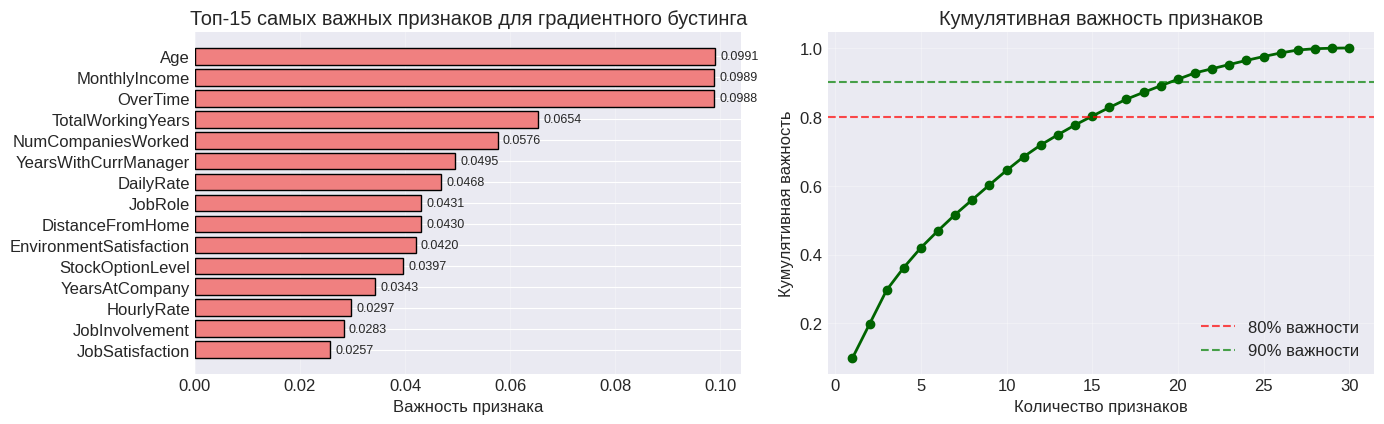


--- 5.3 Предсказания ---
Использован порог классификации: 0.25
Получено 294 предсказаний
Распределение предсказанных классов: Класс 0: 242, Класс 1: 52
Диапазон вероятностей класса 1: [0.028, 0.901]

Сравнение с порогом 0.5:
  Порог 0.5: Класс 0: 285, Класс 1: 9
  Порог 0.25: Класс 0: 242, Класс 1: 52


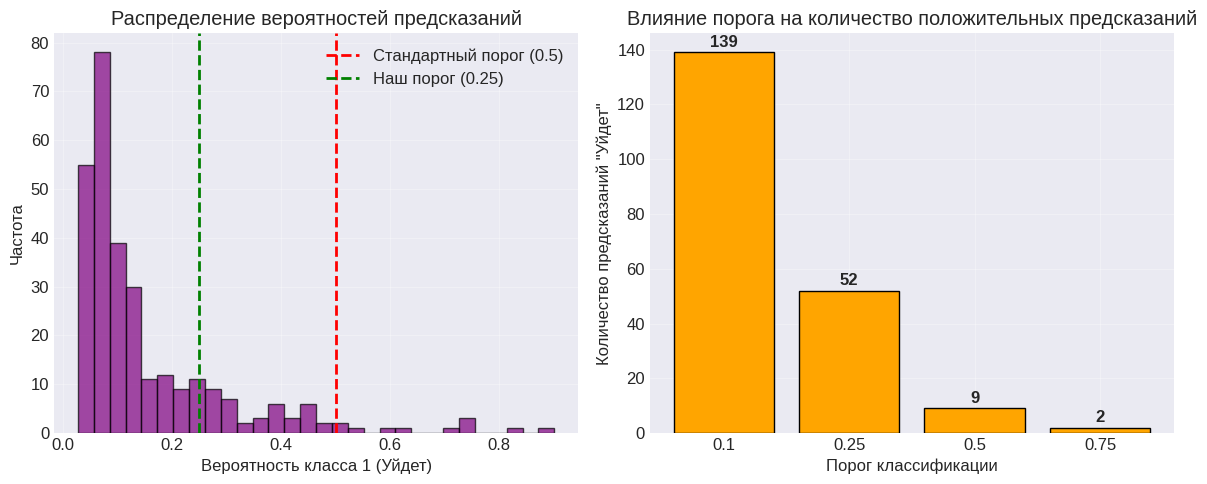


--- 5.4 Матрица ошибок  ---
Матрица ошибок градиентного бустинга (порог 0.25):
                  Предсказано
                Нет     Да
Фактически Нет  [218]  [ 29]
            Да   [ 24]  [ 23]

Основные метрики качества (с порогом 0.25):
  • Accuracy:       0.8197
  • Precision:      0.4423
  • Recall:         0.4894
  • F1-score:       0.4646

Сравнение с порогом 0.5:
                    Порог 0.5    Порог 0.25   Изменение
  Accuracy:            0.8435       0.8197   -0.0238
  Precision:           0.5556       0.4423   -0.1132
  Recall:              0.1064       0.4894   +0.3830
  F1-score:            0.1786       0.4646   +0.2861

--- 5.5 Визуализация сравнения порогов ---


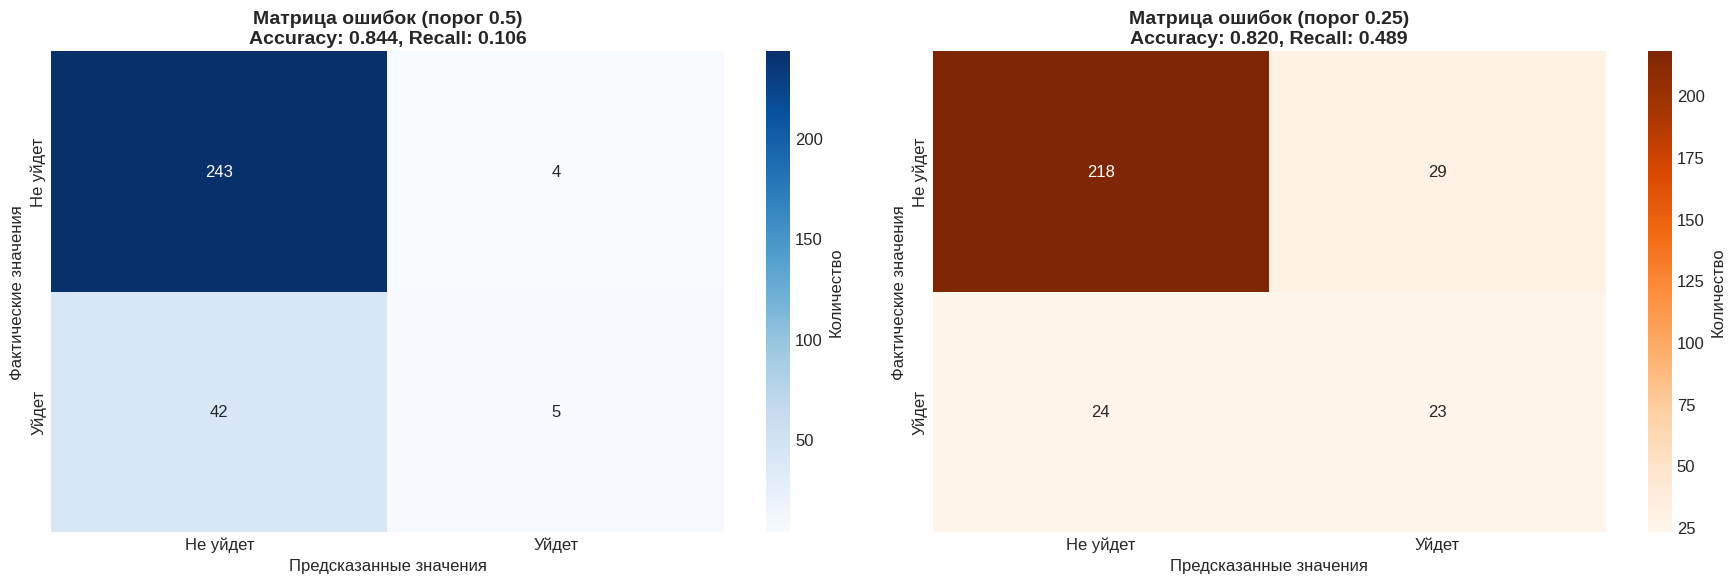


--- 5.6 Детальный анализ предсказаний (порог 0.25) ---
1. ОБЩАЯ СТАТИСТИКА:
   Всего предсказаний: 294
   Правильных предсказаний: 241 (82.0%)
   Ошибок предсказаний: 53 (18.0%)

2. АНАЛИЗ ПО КЛАССАМ (с порогом 0.25):

   КЛАСС 'НЕ УЙДЕТ':
   • Фактически не ушли: 247 клиентов
   • Правильно предсказано: 218 клиентов
   • Точность (Specificity): 88.3%
   • Ошибки (FP): 29 клиентов (11.7%)

   КЛАСС 'УЙДЕТ':
   • Фактически уйдут: 47 клиентов
   • Правильно предсказано: 23 клиентов
   • Точность (Recall): 48.9%
   • Ошибки (FN): 24 клиентов (51.1%)

3. БИЗНЕС-АНАЛИЗ (с порогом 0.25):
   • Обнаружено увольнений: 23 из 47 (48.9%)
   • Ложных тревог: 29 (можно провести дополнительные проверки)
   • Пропущено увольнений: 24 (потерянные возможности для удержания)

--- 5.7 Полный отчет о классификации (порог 0.25) ---
              precision    recall  f1-score   support

    Не уйдет       0.90      0.88      0.89       247
       Уйдет       0.44      0.49      0.46        47

    accuracy

In [24]:
# Ячейка 5: ПОСТРОЕНИЕ БЕЙСЛАЙНА ДЛЯ КЛАССИФИКАЦИИ (Градиентный бустинг)
# 5.1 Обучение базовой модели градиентного бустинга с учетом дисбаланса
print("\n--- 5.1 Обучение базовой модели градиентного бустинга ---")

# Анализ дисбаланса классов в обучающей выборке
print(f"Анализ дисбаланса классов в обучающей выборке:")
print(f"  Класс 0 (Не уйдет): {sum(y_train_class == 0)} наблюдений")
print(f"  Класс 1 (Уйдет): {sum(y_train_class == 1)} наблюдений")
print(f"  Соотношение: {sum(y_train_class == 0)/sum(y_train_class == 1):.1f}:1")

# Создаем модель градиентного бустинга с учетом дисбаланса
gb_classifier = GradientBoostingClassifier(
    random_state=42,
    n_estimators=200,           # Увеличиваем количество деревьев для лучшей стабильности
    learning_rate=0.05,         # Уменьшаем learning_rate для более плавного обучения
    max_depth=4,               # Немного увеличиваем глубину для улавливания паттернов
    min_samples_split=10,      # Уменьшаем для лучшей чувствительности к меньшему классу
    min_samples_leaf=5,        # Уменьшаем для лучшей чувствительности к меньшему классу
    subsample=0.8,             # Доля образцов для обучения каждого дерева (стохастический GB)
    max_features=0.33,       # Количество признаков для рассмотрения в каждом разбиении
    min_impurity_decrease=0.0005,  # Более чувствительный к разбиениям
    validation_fraction=0.1,   # Доля данных для ранней остановки
    n_iter_no_change=15,       # Количество итераций без улучшения для ранней остановки
    tol=1e-5                   # Минимальное улучшение для продолжения обучения
)

# Обучаем модель на обучающей выборке
print("\nОбучаем модель градиентного бустинга...")
start_time = datetime.now()
gb_classifier.fit(X_train_class, y_train_class)
training_time = (datetime.now() - start_time).total_seconds()
print(f"Модель обучена успешно! Время обучения: {training_time:.2f} секунд")

# Анализ процесса обучения
print(f"\nКоличество обученных деревьев: {len(gb_classifier.estimators_)}")
if hasattr(gb_classifier, 'train_score_'):
    print(f"Ошибка на обучающей выборке: {gb_classifier.train_score_[-1]:.4f}")

# 5.2 Анализ важности признаков в градиентном бустинге
print("\n--- 5.2 Анализ важности признаков ---")

# Получаем важность признаков из градиентного бустинга
feature_importance = gb_classifier.feature_importances_
importance_df = pd.DataFrame({
    'Признак': feature_names_class,
    'Важность': feature_importance
}).sort_values('Важность', ascending=False).head(15)

print("Топ-15 самых важных признаков для градиентного бустинга:")
for i, row in importance_df.iterrows():
    print(f"  {row['Признак']:30} → {row['Важность']:.4f}")

# Сравнение со средним значением важности
mean_importance = feature_importance.mean()
print(f"\nСредняя важность признака: {mean_importance:.4f}")
print(f"Количество признаков выше средней важности: {(feature_importance > mean_importance).sum()}")

# Визуализация важности признаков
plt.figure(figsize=(14, 8))

# 1. Столбчатая диаграмма
plt.subplot(2, 2, 1)
bars = plt.barh(range(len(importance_df)), importance_df['Важность'][::-1], 
                color='lightcoral', edgecolor='black')
plt.yticks(range(len(importance_df)), importance_df['Признак'][::-1])
plt.xlabel('Важность признака')
plt.title('Топ-15 самых важных признаков для градиентного бустинга')
plt.grid(axis='x', alpha=0.3)

# Добавляем значения на столбцы
for i, (bar, importance) in enumerate(zip(bars, importance_df['Важность'][::-1])):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
            f'{importance:.4f}', va='center', fontsize=9)

# 2. Кумулятивная важность
plt.subplot(2, 2, 2)
cumulative_importance = np.sort(feature_importance)[::-1].cumsum()
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 
         marker='o', linewidth=2, color='darkgreen')
plt.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='80% важности')
plt.axhline(y=0.9, color='green', linestyle='--', alpha=0.7, label='90% важности')
plt.xlabel('Количество признаков')
plt.ylabel('Кумулятивная важность')
plt.title('Кумулятивная важность признаков')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5.3 ПРЕДСКАЗАНИЯ С ПОРОГОМ 0.25 (для несбалансированных данных)
print("\n--- 5.3 Предсказания ---")

# Получаем вероятности предсказаний
y_pred_proba = gb_classifier.predict_proba(X_test_class)[:, 1]  # Вероятности для класса 1

# Применяем порог 0.25 
threshold = 0.25
y_pred_class = (y_pred_proba >= threshold).astype(int)

print(f"Использован порог классификации: {threshold}")
print(f"Получено {len(y_pred_class)} предсказаний")
print(f"Распределение предсказанных классов: Класс 0: {(y_pred_class == 0).sum()}, Класс 1: {(y_pred_class == 1).sum()}")
print(f"Диапазон вероятностей класса 1: [{y_pred_proba.min():.3f}, {y_pred_proba.max():.3f}]")

# Сравнение с стандартным порогом 0.5
y_pred_class_standard = (y_pred_proba >= 0.5).astype(int)
print(f"\nСравнение с порогом 0.5:")
print(f"  Порог 0.5: Класс 0: {(y_pred_class_standard == 0).sum()}, Класс 1: {(y_pred_class_standard == 1).sum()}")
print(f"  Порог {threshold}: Класс 0: {(y_pred_class == 0).sum()}, Класс 1: {(y_pred_class == 1).sum()}")

# Визуализация распределения вероятностей и порогов
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# Распределение вероятностей для класса 1
plt.hist(y_pred_proba, bins=30, alpha=0.7, color='purple', edgecolor='black')
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Стандартный порог (0.5)')
plt.axvline(x=threshold, color='green', linestyle='--', linewidth=2, label=f'Наш порог ({threshold})')
plt.xlabel('Вероятность класса 1 (Уйдет)')
plt.ylabel('Частота')
plt.title('Распределение вероятностей предсказаний')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Количество предсказаний по классам при разных порогах
thresholds_to_test = [0.1, 0.25, 0.5, 0.75]
class1_counts = []
for t in thresholds_to_test:
    class1_counts.append(((y_pred_proba >= t).astype(int) == 1).sum())

bars = plt.bar(range(len(thresholds_to_test)), class1_counts, color='orange', edgecolor='black')
plt.xticks(range(len(thresholds_to_test)), [f'{t}' for t in thresholds_to_test])
plt.xlabel('Порог классификации')
plt.ylabel('Количество предсказаний "Уйдет"')
plt.title('Влияние порога на количество положительных предсказаний')

# Добавляем значения на столбцы
for bar, count in zip(bars, class1_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{count}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5.4 МАТРИЦА ОШИБОК 
print("\n--- 5.4 Матрица ошибок  ---")

# Вычисляем матрицу ошибок
cm = confusion_matrix(y_test_class, y_pred_class)
tn, fp, fn, tp = cm.ravel()

print("Матрица ошибок градиентного бустинга (порог 0.25):")
print(f"                  Предсказано")
print(f"                Нет     Да")
print(f"Фактически Нет  [{tn:3d}]  [{fp:3d}]")
print(f"            Да   [{fn:3d}]  [{tp:3d}]")
print()

# Вычисляем метрики из матрицы ошибок
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"Основные метрики качества (с порогом {threshold}):")
print(f"  • Accuracy:       {accuracy:.4f}")
print(f"  • Precision:      {precision:.4f}")
print(f"  • Recall:         {recall:.4f}")
print(f"  • F1-score:       {f1:.4f}")

# Сравнение с метриками при пороге 0.5
cm_standard = confusion_matrix(y_test_class, y_pred_class_standard)
tn_s, fp_s, fn_s, tp_s = cm_standard.ravel()
accuracy_s = (tp_s + tn_s) / (tp_s + tn_s + fp_s + fn_s)
precision_s = tp_s / (tp_s + fp_s) if (tp_s + fp_s) > 0 else 0
recall_s = tp_s / (tp_s + fn_s) if (tp_s + fn_s) > 0 else 0
f1_s = 2 * precision_s * recall_s / (precision_s + recall_s) if (precision_s + recall_s) > 0 else 0

print(f"\nСравнение с порогом 0.5:")
print(f"                    Порог 0.5    Порог {threshold}   Изменение")
print(f"  Accuracy:        {accuracy_s:10.4f}   {accuracy:10.4f}   {accuracy - accuracy_s:+.4f}")
print(f"  Precision:       {precision_s:10.4f}   {precision:10.4f}   {precision - precision_s:+.4f}")
print(f"  Recall:          {recall_s:10.4f}   {recall:10.4f}   {recall - recall_s:+.4f}")
print(f"  F1-score:        {f1_s:10.4f}   {f1:10.4f}   {f1 - f1_s:+.4f}")

# 5.5 ВИЗУАЛИЗАЦИЯ МАТРИЦЫ ОШИБОК (2 графика: порог 0.5 vs порог 0.25)
print("\n--- 5.5 Визуализация сравнения порогов ---")

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Матрица ошибок с порогом 0.5
ax1 = axes[0]
sns.heatmap(cm_standard, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'],
            cbar_kws={'label': 'Количество'})
ax1.set_title(f'Матрица ошибок (порог 0.5)\nAccuracy: {accuracy_s:.3f}, Recall: {recall_s:.3f}', 
              fontsize=14, fontweight='bold')
ax1.set_ylabel('Фактические значения', fontsize=12)
ax1.set_xlabel('Предсказанные значения', fontsize=12)

# Матрица ошибок с порогом 0.25
ax2 = axes[1]
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', ax=ax2,
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'],
            cbar_kws={'label': 'Количество'})
ax2.set_title(f'Матрица ошибок (порог {threshold})\nAccuracy: {accuracy:.3f}, Recall: {recall:.3f}', 
              fontsize=14, fontweight='bold')
ax2.set_ylabel('Фактические значения', fontsize=12)
ax2.set_xlabel('Предсказанные значения', fontsize=12)

plt.tight_layout()
plt.show()

# 5.6 ДЕТАЛЬНЫЙ АНАЛИЗ ПРЕДСКАЗАНИЙ С ПОРОГОМ 0.25
print("\n--- 5.6 Детальный анализ предсказаний (порог 0.25) ---")

total_predictions = len(y_pred_class)
correct_predictions = tp + tn
incorrect_predictions = fp + fn

print(f"1. ОБЩАЯ СТАТИСТИКА:")
print(f"   Всего предсказаний: {total_predictions}")
print(f"   Правильных предсказаний: {correct_predictions} ({accuracy*100:.1f}%)")
print(f"   Ошибок предсказаний: {incorrect_predictions} ({(1-accuracy)*100:.1f}%)")

# Анализ по классам
print(f"\n2. АНАЛИЗ ПО КЛАССАМ (с порогом {threshold}):")

# Для класса "Не уйдет" (0)
correct_not_churn = tn
total_not_churn_actual = tn + fp
accuracy_not_churn = tn / (tn + fp) if (tn + fp) > 0 else 0
precision_not_churn = tn / (tn + fn) if (tn + fn) > 0 else 0  # Specificity

print(f"\n   КЛАСС 'НЕ УЙДЕТ':")
print(f"   • Фактически не ушли: {total_not_churn_actual} клиентов")
print(f"   • Правильно предсказано: {correct_not_churn} клиентов")
print(f"   • Точность (Specificity): {accuracy_not_churn*100:.1f}%")
print(f"   • Ошибки (FP): {fp} клиентов ({fp/total_not_churn_actual*100:.1f}%)")

# Для класса "Уйдет" (1)
correct_churn = tp
total_churn_actual = tp + fn
accuracy_churn = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall

print(f"\n   КЛАСС 'УЙДЕТ':")
print(f"   • Фактически уйдут: {total_churn_actual} клиентов")
print(f"   • Правильно предсказано: {correct_churn} клиентов")
print(f"   • Точность (Recall): {accuracy_churn*100:.1f}%")
print(f"   • Ошибки (FN): {fn} клиентов ({fn/total_churn_actual*100:.1f}%)")

# Бизнес-анализ
print(f"\n3. БИЗНЕС-АНАЛИЗ (с порогом {threshold}):")
print(f"   • Обнаружено увольнений: {tp} из {total_churn_actual} ({accuracy_churn*100:.1f}%)")
print(f"   • Ложных тревог: {fp} (можно провести дополнительные проверки)")
print(f"   • Пропущено увольнений: {fn} (потерянные возможности для удержания)")

# 5.7 ПОЛНЫЙ ОТЧЕТ О КЛАССИФИКАЦИИ
print("\n--- 5.7 Полный отчет о классификации (порог 0.25) ---")
print(classification_report(y_test_class, y_pred_class, 
                           target_names=['Не уйдет', 'Уйдет']))

# 5.8 АНАЛИЗ ПРОЦЕССА БУСТИНГА
print("\n--- 5.8 Анализ процесса градиентного бустинга ---")

print(f"Количество бустеров (деревьев) в ансамбле: {len(gb_classifier.estimators_)}")
print(f"Скорость обучения (learning_rate): {gb_classifier.learning_rate}")

# Анализ глубины деревьев
depths = [estimator.get_depth() for estimator in gb_classifier.estimators_[:, 0]]
n_leaves = [estimator.get_n_leaves() for estimator in gb_classifier.estimators_[:, 0]]

print(f"\nСтатистика по деревьям (слабым ученикам):")
print(f"  • Средняя глубина: {np.mean(depths):.1f}")
print(f"  • Минимальная глубина: {min(depths)}")
print(f"  • Максимальная глубина: {max(depths)}")
print(f"  • Среднее количество листьев: {np.mean(n_leaves):.1f}")

# 5.9 ИНФОРМАЦИЯ О ПАРАМЕТРАХ МОДЕЛИ
print("\n--- 5.9 Параметры модели ---")
print(f"Использованные параметры градиентного бустинга:")
print(f"• n_estimators: {gb_classifier.n_estimators}")
print(f"• learning_rate: {gb_classifier.learning_rate}")
print(f"• max_depth: {gb_classifier.max_depth}")
print(f"• min_samples_split: {gb_classifier.min_samples_split}")
print(f"• min_samples_leaf: {gb_classifier.min_samples_leaf}")
print(f"• subsample: {gb_classifier.subsample}")
print(f"• max_features: {gb_classifier.max_features}")
print(f"• random_state: {gb_classifier.random_state}")

### Построение безлайна для регрессии


--- 6.1 Обучение базовой модели градиентного бустинга регрессии ---
Обучаем модель градиентного бустинга для регрессии...
Модель обучена успешно! Время обучения: 2.82 секунд

Количество обученных бустеров (деревьев): 200
MSE на обучающей выборке (последняя итерация): 0.0288

Анализ ансамбля из 200 слабых учеников:
  • Средняя глубина: 4.0
  • Среднее количество листьев: 15.0
  • Размер суб-выборки (subsample): 13832 образцов

--- 6.2 Анализ важности признаков ---
Топ-15 самых важных признаков для предсказания цены дома:
  lat                            → 0.3021
  sqft_living                    → 0.1727
  grade                          → 0.1506
  sqft_living15                  → 0.1021
  sqft_above                     → 0.0735
  bathrooms                      → 0.0515
  long                           → 0.0280
  view                           → 0.0238
  yr_built                       → 0.0207
  sqft_lot                       → 0.0167
  sqft_lot15                     → 0.0136
  sqft_base

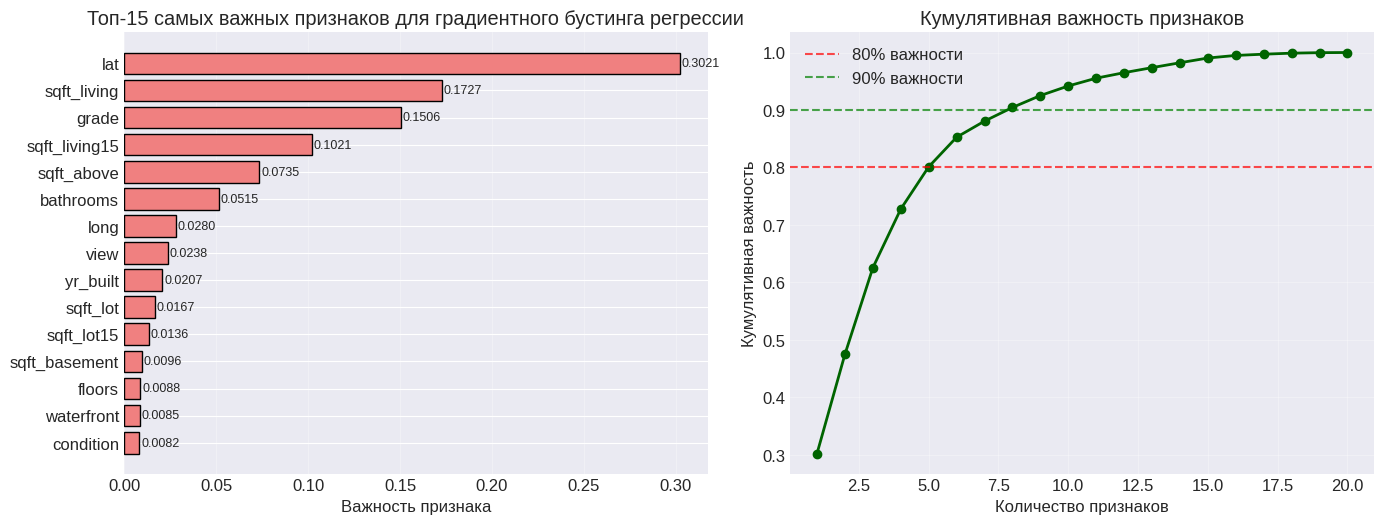


--- 6.3 Предсказания на тестовой выборке ---
Получено 4323 предсказаний цен
Примеры предсказанных цен (первые 5): $[ 383665  793459 1049250 2067489  728959]
Примеры фактических цен (первые 5):   $[ 364999  864999 1037999 1490000  711000]

Примеры предсказаний от первых 5 слабых учеников (первый объект):
  Дерево 1: $-0
  Дерево 2: $0
  Дерево 3: $-0
  Дерево 4: $-0
  Дерево 5: $-0

--- 6.4 Оценка качества модели (метрики) ---
Метрики в логарифмированной шкале (более устойчивые):
  • RMSE (log scale): 0.1824
  • MAE (log scale):  0.1338
  • R² (log scale):   0.8833

Метрики в оригинальной шкале (доллары):
  • RMSE:            $141,287
  • MAE:             $76,969
  • MAPE:            13.59%
  • R²:              0.8680

--- 6.5 Визуализация результатов регрессии ---


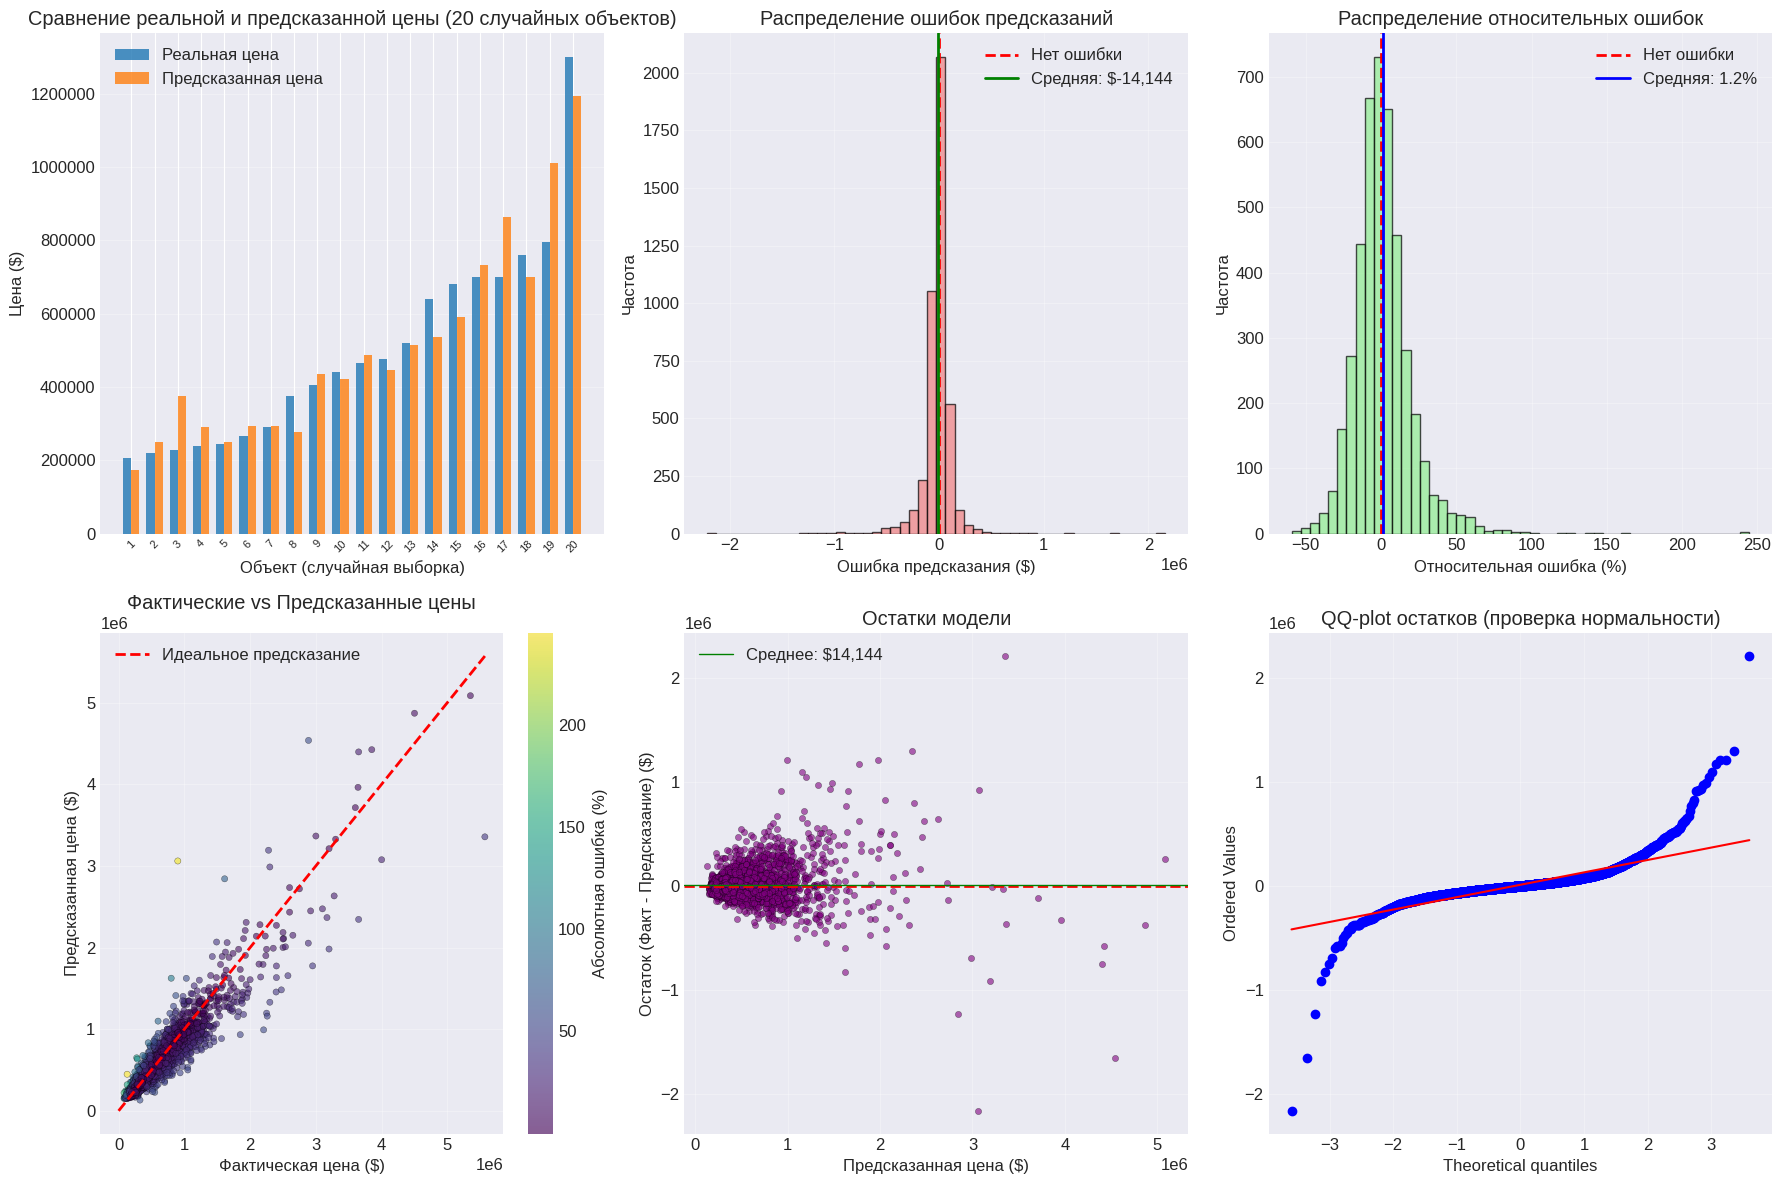


--- 6.6 Статистика ошибок предсказаний ---
Процентили абсолютных ошибок (в долларах):
  • 25%: $19,699
  • 50% (медиана): $43,787
  • 75%: $88,078
  • 90%: $169,511
  • 95%: $263,858

Процент предсказаний с заданной точностью:
  • Ошибка ≤ 10%: 49.9% предсказаний
  • Ошибка ≤ 20%: 78.5% предсказаний
  • Ошибка ≤ 30%: 91.0% предсказаний

--- 6.7 Сравнение реальных и предсказанных цен ---
Средняя цена: реальная = $549,367, предсказанная = $535,224
Медианная цена: реальная = $455,000, предсказанная = $450,782
Средняя ошибка: $-14,144 (смещение модели)
Средняя абсолютная ошибка: $76,969 (13.6%)

--- 6.8 Анализ остатков модели ---
Статистика остатков:
  • Средний остаток: $14,144
  • Стандартное отклонение: $140,577
  • Минимальный остаток: $-2,160,210
  • Максимальный остаток: $2,214,134
  • Процент положительных остатков: 51.4%

--- 6.9 Параметры модели ---
Использованные параметры градиентного бустинга регрессии:
• n_estimators: 200
• learning_rate: 0.05
• max_depth: 4
• min_samples_spl

In [30]:
# Ячейка 6: ПОСТРОЕНИЕ БЕЙСЛАЙНА ДЛЯ РЕГРЕССИИ (Градиентный бустинг)
# 6.1 Обучение базовой модели градиентного бустинга регрессии
print("\n--- 6.1 Обучение базовой модели градиентного бустинга регрессии ---")

# Создаем модель градиентного бустинга для регрессии
gb_regressor = GradientBoostingRegressor(
    random_state=42,
    n_estimators=200,           # Количество деревьев (бустеров)
    learning_rate=0.05,         # Скорость обучения (шаг градиентного спуска)
    max_depth=4,               # Глубина каждого дерева (оптимально 3-5 для GB)
    min_samples_split=10,      # Минимальное количество образцов для разделения узла
    min_samples_leaf=5,        # Минимальное количество образцов в листе
    subsample=0.8,             # Доля образцов для обучения каждого дерева (стохастический GB)
    max_features='sqrt',       # Количество признаков для рассмотрения в каждом разбиении
    alpha=0.9,                 # Квантиль для квантильной регрессии (опционально)
    min_impurity_decrease=0.0005,  # Более чувствительный к разбиениям
    validation_fraction=0.1,   # Доля данных для ранней остановки
    n_iter_no_change=15,       # Количество итераций без улучшения для раншей остановки
    tol=1e-4                   # Минимальное улучшение для продолжения обучения
)

# Обучаем модель на обучающей выборке
print("Обучаем модель градиентного бустинга для регрессии...")
start_time = datetime.now()
gb_regressor.fit(X_train_reg, y_train_reg)
training_time = (datetime.now() - start_time).total_seconds()
print(f"Модель обучена успешно! Время обучения: {training_time:.2f} секунд")

# Анализ процесса обучения
print(f"\nКоличество обученных бустеров (деревьев): {len(gb_regressor.estimators_)}")
if hasattr(gb_regressor, 'train_score_'):
    print(f"MSE на обучающей выборке (последняя итерация): {gb_regressor.train_score_[-1]:.4f}")

# Анализ структуры деревьев (слабых учеников)
print(f"\nАнализ ансамбля из {gb_regressor.n_estimators} слабых учеников:")
depths = [estimator.get_depth() for estimator in gb_regressor.estimators_[:, 0]]
n_leaves = [estimator.get_n_leaves() for estimator in gb_regressor.estimators_[:, 0]]
print(f"  • Средняя глубина: {np.mean(depths):.1f}")
print(f"  • Среднее количество листьев: {np.mean(n_leaves):.1f}")
print(f"  • Размер суб-выборки (subsample): {int(len(X_train_reg) * gb_regressor.subsample)} образцов")

# 6.2 Анализ важности признаков в градиентном бустинге
print("\n--- 6.2 Анализ важности признаков ---")

# Получаем важность признаков из градиентного бустинга
feature_importance = gb_regressor.feature_importances_
importance_df = pd.DataFrame({
    'Признак': feature_names_reg,
    'Важность': feature_importance
}).sort_values('Важность', ascending=False).head(15)

print("Топ-15 самых важных признаков для предсказания цены дома:")
for i, row in importance_df.iterrows():
    print(f"  {row['Признак']:30} → {row['Важность']:.4f}")

# Сравнение со средним значением важности
mean_importance = feature_importance.mean()
print(f"\nСредняя важность признака: {mean_importance:.4f}")
print(f"Количество признаков выше средней важности: {(feature_importance > mean_importance).sum()}")

# Визуализация важности признаков
plt.figure(figsize=(14, 10))

# 1. Столбчатая диаграмма важности признаков
plt.subplot(2, 2, 1)
bars = plt.barh(range(len(importance_df)), importance_df['Важность'][::-1], 
                color='lightcoral', edgecolor='black')
plt.yticks(range(len(importance_df)), importance_df['Признак'][::-1])
plt.xlabel('Важность признака')
plt.title('Топ-15 самых важных признаков для градиентного бустинга регрессии')
plt.grid(axis='x', alpha=0.3)

# Добавляем значения на столбцы
for i, (bar, importance) in enumerate(zip(bars, importance_df['Важность'][::-1])):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
            f'{importance:.4f}', va='center', fontsize=9)

# 2. Кумулятивная важность признаков
plt.subplot(2, 2, 2)
sorted_importance = np.sort(feature_importance)[::-1]
cumulative_importance = sorted_importance.cumsum()
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 
         marker='o', linewidth=2, color='darkgreen')
plt.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='80% важности')
plt.axhline(y=0.9, color='green', linestyle='--', alpha=0.7, label='90% важности')
plt.xlabel('Количество признаков')
plt.ylabel('Кумулятивная важность')
plt.title('Кумулятивная важность признаков')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6.3 Предсказания на тестовой выборке
print("\n--- 6.3 Предсказания на тестовой выборке ---")

# Получаем предсказания (логарифмированные цены)
y_pred_reg_log = gb_regressor.predict(X_test_reg)

# Преобразуем обратно из логарифма в обычные цены
y_pred_reg = np.expm1(y_pred_reg_log)

# Преобразуем y_test_reg из логарифмированной шкалы в обычные цены
y_test_reg_original = np.expm1(y_test_reg)

print(f"Получено {len(y_pred_reg)} предсказаний цен")
print(f"Примеры предсказанных цен (первые 5): ${y_pred_reg[:5].astype(int)}")
print(f"Примеры фактических цен (первые 5):   ${y_test_reg_original.iloc[:5].astype(int).values}")

# Также получаем предсказания от отдельных деревьев (для анализа)
n_trees_to_show = 5
tree_predictions = np.array([tree.predict(X_test_reg) for tree in gb_regressor.estimators_[:n_trees_to_show, 0]])
tree_predictions_original = np.expm1(tree_predictions)

print(f"\nПримеры предсказаний от первых {n_trees_to_show} слабых учеников (первый объект):")
for i in range(n_trees_to_show):
    print(f"  Дерево {i+1}: ${tree_predictions_original[i, 0]:,.0f}")

# 6.4 Оценка качества модели (метрики)
print("\n--- 6.4 Оценка качества модели (метрики) ---")

# Основные метрики в логарифмированной шкале (более устойчивые)
rmse_log = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg_log))
mae_log = mean_absolute_error(y_test_reg, y_pred_reg_log)
r2_log = r2_score(y_test_reg, y_pred_reg_log)

# Метрики в оригинальной шкале (доллары)
rmse = np.sqrt(mean_squared_error(y_test_reg_original, y_pred_reg))
mae = mean_absolute_error(y_test_reg_original, y_pred_reg)
mape = mean_absolute_percentage_error(y_test_reg_original, y_pred_reg)
r2 = r2_score(y_test_reg_original, y_pred_reg)

print("Метрики в логарифмированной шкале (более устойчивые):")
print(f"  • RMSE (log scale): {rmse_log:.4f}")
print(f"  • MAE (log scale):  {mae_log:.4f}")
print(f"  • R² (log scale):   {r2_log:.4f}")

print("\nМетрики в оригинальной шкале (доллары):")
print(f"  • RMSE:            ${rmse:,.0f}")
print(f"  • MAE:             ${mae:,.0f}")
print(f"  • MAPE:            {mape*100:.2f}%")
print(f"  • R²:              {r2:.4f}")

# 6.5 Визуализация результатов регрессии
print("\n--- 6.5 Визуализация результатов регрессии ---")

# Создаем DataFrame для удобства анализа
y_test_array = y_test_reg_original.values if hasattr(y_test_reg_original, 'values') else y_test_reg_original

results_df = pd.DataFrame({
    'Фактическая_цена': y_test_array,
    'Предсказанная_цена': y_pred_reg,
    'Относительная_ошибка_%': ((y_pred_reg - y_test_array) / y_test_array) * 100,
    'Абсолютная_ошибка': np.abs(y_pred_reg - y_test_array)
})

# Рассчитываем ошибки для графиков
errors = y_pred_reg - y_test_array
relative_errors = (errors / y_test_array) * 100

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# График 1: Сравнение реальной и предсказанной цены (20 случайных объектов)
np.random.seed(42)
n_samples = min(20, len(results_df))
sample_indices = np.random.choice(len(results_df), n_samples, replace=False)
sample_df = results_df.iloc[sample_indices].copy()
sample_df = sample_df.sort_values('Фактическая_цена')

x_pos = np.arange(len(sample_df))
width = 0.35

bars_actual = axes[0, 0].bar(x_pos - width/2, sample_df['Фактическая_цена'], 
                            width, label='Реальная цена', color='#1f77b4', alpha=0.8)
bars_pred = axes[0, 0].bar(x_pos + width/2, sample_df['Предсказанная_цена'], 
                          width, label='Предсказанная цена', color='#ff7f0e', alpha=0.8)

axes[0, 0].set_xlabel('Объект (случайная выборка)')
axes[0, 0].set_ylabel('Цена ($)')
axes[0, 0].set_title('Сравнение реальной и предсказанной цены (20 случайных объектов)')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels([f'{i+1}' for i in range(len(sample_df))], rotation=45, fontsize=8)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].ticklabel_format(style='plain', axis='y')

# График 2: Ошибки предсказаний
axes[0, 1].hist(errors, bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Нет ошибки')
axes[0, 1].axvline(x=np.mean(errors), color='green', linestyle='-', linewidth=2, 
                   label=f'Средняя: ${np.mean(errors):,.0f}')
axes[0, 1].set_xlabel('Ошибка предсказания ($)')
axes[0, 1].set_ylabel('Частота')
axes[0, 1].set_title('Распределение ошибок предсказаний')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# График 3: Относительные ошибки
axes[0, 2].hist(relative_errors, bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0, 2].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Нет ошибки')
axes[0, 2].axvline(x=np.mean(relative_errors), color='blue', linestyle='-', linewidth=2,
                   label=f'Средняя: {np.mean(relative_errors):.1f}%')
axes[0, 2].set_xlabel('Относительная ошибка (%)')
axes[0, 2].set_ylabel('Частота')
axes[0, 2].set_title('Распределение относительных ошибок')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# График 4: Фактические vs предсказанные цены
scatter = axes[1, 0].scatter(results_df['Фактическая_цена'], results_df['Предсказанная_цена'],
                            c=np.abs(results_df['Относительная_ошибка_%']),
                            cmap='viridis', alpha=0.6, s=20, edgecolors='black', linewidth=0.3)

# Линия идеального предсказания
max_price = max(results_df['Фактическая_цена'].max(), results_df['Предсказанная_цена'].max())
axes[1, 0].plot([0, max_price], [0, max_price], 'r--', linewidth=2, label='Идеальное предсказание')

axes[1, 0].set_xlabel('Фактическая цена ($)')
axes[1, 0].set_ylabel('Предсказанная цена ($)')
axes[1, 0].set_title('Фактические vs Предсказанные цены')
axes[1, 0].legend(loc='upper left')
axes[1, 0].grid(True, alpha=0.3)

# Добавляем цветовую шкалу
cbar = plt.colorbar(scatter, ax=axes[1, 0])
cbar.set_label('Абсолютная ошибка (%)')

# График 5: Остатки vs предсказанные значения
residuals = y_test_array - y_pred_reg
axes[1, 1].scatter(y_pred_reg, residuals, alpha=0.6, s=20, edgecolors='black', linewidth=0.3, color='purple')
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].axhline(y=np.mean(residuals), color='green', linestyle='-', linewidth=1,
                   label=f'Среднее: ${np.mean(residuals):,.0f}')
axes[1, 1].set_xlabel('Предсказанная цена ($)')
axes[1, 1].set_ylabel('Остаток (Факт - Предсказание) ($)')
axes[1, 1].set_title('Остатки модели')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# График 6: QQ-plot остатков
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 2])
axes[1, 2].set_title('QQ-plot остатков (проверка нормальности)')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6.6 Статистика ошибок
print("\n--- 6.6 Статистика ошибок предсказаний ---")

# Процентили абсолютных ошибок (в долларах)
abs_errors = np.abs(errors)
error_percentiles = np.percentile(abs_errors, [25, 50, 75, 90, 95])
print("Процентили абсолютных ошибок (в долларах):")
print(f"  • 25%: ${error_percentiles[0]:,.0f}")
print(f"  • 50% (медиана): ${error_percentiles[1]:,.0f}")
print(f"  • 75%: ${error_percentiles[2]:,.0f}")
print(f"  • 90%: ${error_percentiles[3]:,.0f}")
print(f"  • 95%: ${error_percentiles[4]:,.0f}")

# Процент предсказаний с разной точностью
abs_relative_errors = np.abs(relative_errors)
within_10_percent = np.sum(abs_relative_errors <= 10) / len(abs_relative_errors) * 100
within_20_percent = np.sum(abs_relative_errors <= 20) / len(abs_relative_errors) * 100
within_30_percent = np.sum(abs_relative_errors <= 30) / len(abs_relative_errors) * 100

print("\nПроцент предсказаний с заданной точностью:")
print(f"  • Ошибка ≤ 10%: {within_10_percent:.1f}% предсказаний")
print(f"  • Ошибка ≤ 20%: {within_20_percent:.1f}% предсказаний")
print(f"  • Ошибка ≤ 30%: {within_30_percent:.1f}% предсказаний")

# 6.7 Сравнение реальных и предсказанных цен
print("\n--- 6.7 Сравнение реальных и предсказанных цен ---")

mean_actual = np.mean(y_test_array)
mean_pred = np.mean(y_pred_reg)
median_actual = np.median(y_test_array)
median_pred = np.median(y_pred_reg)

print(f"Средняя цена: реальная = ${mean_actual:,.0f}, предсказанная = ${mean_pred:,.0f}")
print(f"Медианная цена: реальная = ${median_actual:,.0f}, предсказанная = ${median_pred:,.0f}")
print(f"Средняя ошибка: ${np.mean(errors):,.0f} (смещение модели)")
print(f"Средняя абсолютная ошибка: ${mae:,.0f} ({mape*100:.1f}%)")

# 6.8 Анализ остатков
print("\n--- 6.8 Анализ остатков модели ---")

print(f"Статистика остатков:")
print(f"  • Средний остаток: ${np.mean(residuals):,.0f}")
print(f"  • Стандартное отклонение: ${np.std(residuals):,.0f}")
print(f"  • Минимальный остаток: ${np.min(residuals):,.0f}")
print(f"  • Максимальный остаток: ${np.max(residuals):,.0f}")
print(f"  • Процент положительных остатков: {np.sum(residuals > 0) / len(residuals) * 100:.1f}%")

# 6.9 Информация о параметрах модели
print("\n--- 6.9 Параметры модели ---")
print(f"Использованные параметры градиентного бустинга регрессии:")
print(f"• n_estimators: {gb_regressor.n_estimators}")
print(f"• learning_rate: {gb_regressor.learning_rate}")
print(f"• max_depth: {gb_regressor.max_depth}")
print(f"• min_samples_split: {gb_regressor.min_samples_split}")
print(f"• min_samples_leaf: {gb_regressor.min_samples_leaf}")
print(f"• subsample: {gb_regressor.subsample}")
print(f"• max_features: {gb_regressor.max_features}")
print(f"• alpha: {gb_regressor.alpha} (квантиль для квантильной регрессии)")
print(f"• loss: {gb_regressor.loss}")
print(f"• random_state: {gb_regressor.random_state}")


## 3. Улучшение Безлайна

### Гипотезы для улучшения

**Для градиентного бустинга классификации:**

**Гипотезы для улучшения:**

1. **Оптимизировать learning_rate и n_estimators** - уменьшить learning_rate до 0.05-0.01 и увеличить n_estimators до 200-300 для лучшей сходимости

2. **Настроить регуляризацию** - уменьшить max_depth до 2-3 и установить min_samples_leaf=5-10 для борьбы с переобучением

3. **Эксперименты с функциями потерь** - попробовать 'log_loss' вместо 'deviance' для лучшей калибровки вероятностей

4. **Использовать стохастический бустинг** - установить subsample=0.8 и max_features=0.8 для уменьшения корреляции между деревьями

**Для градиентного бустинга регрессии:**

**Гипотезы для улучшения:**

1. **Настройка скорости обучения** - experiment с learning_rate [0.01, 0.05, 0.1] для баланса скорости сходимости и точности

2. **Устойчивость к выбросам** - сменить loss='squared_error' на loss='huber' или 'absolute_error' для уменьшения влияния экстремальных цен

3. **Добавить временные признаки** - извлечь больше информации из даты продажи (день недели, квартал, день года)

4. **Оптимизация subsample** - тестировать subsample [0.6, 0.8, 1.0] для нахождения оптимального баланса между bias и variance


--- 7.1 Анализ ---

Текущие параметры бейзлайн модели градиентного бустинга:
• n_estimators: 200
• learning_rate: 0.05
• max_depth: 4
• min_samples_split: 10
• min_samples_leaf: 5
• subsample: 0.8
• max_features: 0.33

Статистика ансамбля слабых учеников:
• Средняя глубина деревьев: 4.0
• Среднее количество листьев: 14.4
• Минимальная глубина: 4
• Максимальная глубина: 4

Метрики бейзлайн модели (порог 0.25):
• F1-score: 0.4646
• Precision: 0.4423
• Recall: 0.4894
• Accuracy: 96.9003

--- 7.2 Проверка гипотез градиентного бустинга ---

Параметры для оптимизации:
  n_estimators: [200, 300]
  learning_rate: [0.01, 0.05, 0.1]
  max_depth: [2, 3, 4]
  min_samples_leaf: [5, 10, 15]
  subsample: [0.7, 0.8, 0.9]
  max_features: [0.33]
  loss: ['log_loss']
  min_impurity_decrease: [0.0001, 0.0005, 0.001]

Всего возможных комбинаций: 486
Будет проверено 30 случайных комбинаций

Запускаем RandomizedSearchCV для градиентного бустинга...
Fitting 3 folds for each of 30 candidates, totalling 90 fit

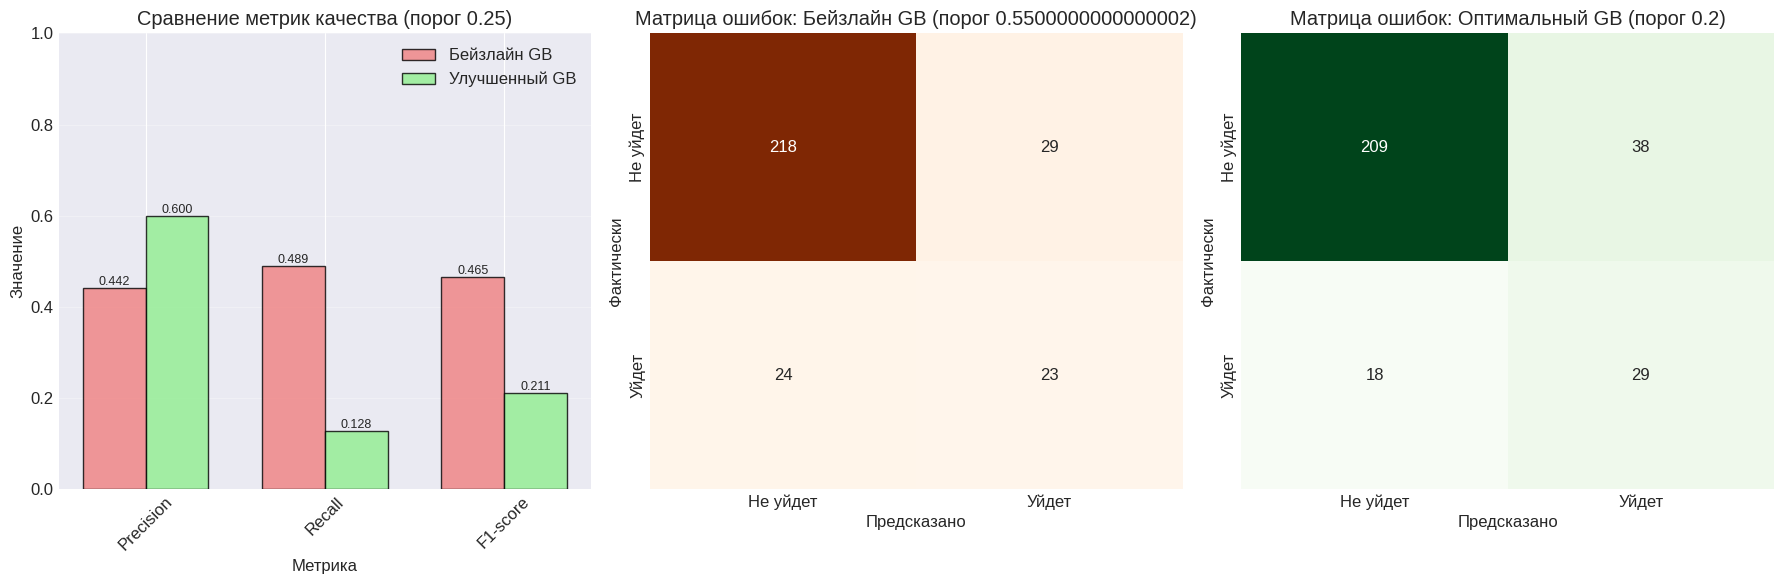

In [54]:
# Ячейка 7: УЛУЧШЕНИЕ ГРАДИЕНТНОГО БУСТИНГА КЛАССИФИКАЦИИ
# 7.1 Анализ проблем и формирование гипотез
print("\n--- 7.1 Анализ ---")

print("\nТекущие параметры бейзлайн модели градиентного бустинга:")
print(f"• n_estimators: {gb_classifier.n_estimators}")
print(f"• learning_rate: {gb_classifier.learning_rate}")
print(f"• max_depth: {gb_classifier.max_depth}")
print(f"• min_samples_split: {gb_classifier.min_samples_split}")
print(f"• min_samples_leaf: {gb_classifier.min_samples_leaf}")
print(f"• subsample: {gb_classifier.subsample}")
print(f"• max_features: {gb_classifier.max_features}")

# Сбор статистики по ансамблю
print("\nСтатистика ансамбля слабых учеников:")
depths = [tree.get_depth() for tree in gb_classifier.estimators_[:, 0]]
n_leaves = [tree.get_n_leaves() for tree in gb_classifier.estimators_[:, 0]]
print(f"• Средняя глубина деревьев: {np.mean(depths):.1f}")
print(f"• Среднее количество листьев: {np.mean(n_leaves):.1f}")
print(f"• Минимальная глубина: {min(depths)}")
print(f"• Максимальная глубина: {max(depths)}")

print(f"\nМетрики бейзлайн модели (порог 0.25):")
print(f"• F1-score: {f1:.4f}")
print(f"• Precision: {precision:.4f}")
print(f"• Recall: {recall:.4f}")
print(f"• Accuracy: {accuracy:.4f}")

# 7.2 Создание и проверка гипотез с помощью GridSearchCV
print("\n--- 7.2 Проверка гипотез градиентного бустинга ---")

# Создаем пространство параметров для проверки гипотез
param_grid_gb = {
    'n_estimators': [200, 300],                    # Гипотеза 1: больше деревьев
    'learning_rate': [0.01, 0.05, 0.1],           # Гипотеза 1: оптимальный шаг
    'max_depth': [2, 3, 4],                       # Гипотеза 2: глубина регуляризации
    'min_samples_leaf': [5, 10, 15],              # Гипотеза 2: регуляризация листьев
    'subsample': [0.7, 0.8, 0.9],                 # Гипотеза 4: стохастический GB
    'max_features': [0.33],          # Гипотеза 4: разнообразие признаков
    'loss': ['log_loss'],             # Гипотеза 3: разные функции потерь
    'min_impurity_decrease': [0.0001, 0.0005, 0.001]  # Дополнительная регуляризация
}

print("\nПараметры для оптимизации:")
for param, values in param_grid_gb.items():
    print(f"  {param}: {values}")

# Рассчитываем общее количество комбинаций
total_combinations = np.prod([len(v) for v in param_grid_gb.values()])
print(f"\nВсего возможных комбинаций: {total_combinations:,}")

# Используем RandomizedSearchCV для эффективного поиска
n_iter = 30  # Проверим 30 случайных комбинаций
print(f"Будет проверено {n_iter} случайных комбинаций")

random_search_gb = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(
        random_state=42,
        validation_fraction=0.1,
        n_iter_no_change=15,
        tol=1e-5
    ),
    param_distributions=param_grid_gb,
    n_iter=n_iter,
    cv=3,  # 3-fold кросс-валидация
    scoring='f1',  # Оптимизируем F1-score
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

print("\nЗапускаем RandomizedSearchCV для градиентного бустинга...")
random_search_gb.fit(X_train_class, y_train_class)

# 7.3 Анализ результатов RandomizedSearch
print("\n--- 7.3 Анализ результатов ---")

# Получаем результаты в DataFrame
results_df = pd.DataFrame(random_search_gb.cv_results_)

# Сортируем по F1-score и берем топ-5
top_results = results_df.nsmallest(5, 'rank_test_score')

print("\nТОП-5 ЛУЧШИХ КОМБИНАЦИЙ ПАРАМЕТРОВ:")
print("=" * 90)
for i, (_, row) in enumerate(top_results.iterrows(), 1):
    print(f"\n{i}. F1-score: {row['mean_test_score']:.4f} (Train: {row['mean_train_score']:.4f})")
    print(f"   learning_rate: {row['param_learning_rate']}")
    print(f"   n_estimators: {row['param_n_estimators']}")
    print(f"   max_depth: {row['param_max_depth']}")
    print(f"   min_samples_leaf: {row['param_min_samples_leaf']}")
    print(f"   subsample: {row['param_subsample']}")
    print(f"   max_features: {row['param_max_features']}")
    print(f"   loss: {row['param_loss']}")

# Анализ влияния отдельных параметров
print("\n--- АНАЛИЗ ВЛИЯНИЯ ПАРАМЕТРОВ НА F1-SCORE ---")

# Анализируем влияние learning_rate
print("\nВЛИЯНИЕ learning_rate на F1-score:")
lr_stats = results_df.groupby('param_learning_rate')['mean_test_score'].agg(['mean', 'std', 'count'])
for lr, stats in lr_stats.iterrows():
    print(f"  {lr:<10} → Средний F1: {stats['mean']:.4f} ±{stats['std']:.4f} (n={int(stats['count'])})")

# Анализируем влияние max_depth
print("\nВЛИЯНИЕ max_depth на F1-score:")
depth_stats = results_df.groupby('param_max_depth')['mean_test_score'].agg(['mean', 'std', 'count'])
for depth, stats in depth_stats.iterrows():
    print(f"  {depth:<10} → Средний F1: {stats['mean']:.4f} ±{stats['std']:.4f} (n={int(stats['count'])})")

# Анализируем влияние loss function
print("\nВЛИЯНИЕ функции потерь на F1-score:")
loss_stats = results_df.groupby('param_loss')['mean_test_score'].agg(['mean', 'std', 'count'])
for loss_func, stats in loss_stats.iterrows():
    print(f"  {loss_func:<15} → Средний F1: {stats['mean']:.4f} ±{stats['std']:.4f} (n={int(stats['count'])})")

# Анализируем влияние subsample
print("\nВЛИЯНИЕ subsample на F1-score:")
subsample_stats = results_df.groupby('param_subsample')['mean_test_score'].agg(['mean', 'std', 'count'])
for subsample, stats in subsample_stats.iterrows():
    print(f"  {subsample:<10} → Средний F1: {stats['mean']:.4f} ±{stats['std']:.4f} (n={int(stats['count'])})")

# 7.4 Создание улучшенной модели с лучшими параметрами
print("\n--- 7.4 Создание улучшенной модели ---")

# Получаем лучшие параметры
best_params = random_search_gb.best_params_

# Создаем улучшенную модель градиентного бустинга
improved_gb = GradientBoostingClassifier(
    random_state=42,
    n_estimators=best_params.get('n_estimators', 300),
    learning_rate=best_params.get('learning_rate', 0.05),
    max_depth=best_params.get('max_depth', 3),
    min_samples_split=10,
    min_samples_leaf=best_params.get('min_samples_leaf', 5),
    subsample=best_params.get('subsample', 0.8),
    max_features=best_params.get('max_features', 0.33),
    loss=best_params.get('loss', 'log_loss'),
    min_impurity_decrease=best_params.get('min_impurity_decrease', 0.0005),
    validation_fraction=0.1,
    n_iter_no_change=15,
    tol=1e-5
)

print("Обучаем улучшенную модель градиентного бустинга...")
start_time = datetime.now()
improved_gb.fit(X_train_class, y_train_class)
training_time = (datetime.now() - start_time).total_seconds()
print(f"Улучшенная модель обучена успешно! Время обучения: {training_time:.2f} секунд")

print("\nПАРАМЕТРЫ УЛУЧШЕННОЙ МОДЕЛИ:")
print(f"• n_estimators:         {improved_gb.n_estimators}")
print(f"• learning_rate:        {improved_gb.learning_rate}")
print(f"• max_depth:            {improved_gb.max_depth}")
print(f"• min_samples_leaf:     {improved_gb.min_samples_leaf}")
print(f"• subsample:            {improved_gb.subsample}")
print(f"• max_features:         {improved_gb.max_features}")
print(f"• loss:                 {improved_gb.loss}")
print(f"• Количество деревьев:  {len(improved_gb.estimators_)}")

# Анализ ансамбля улучшенной модели
print("\nСТАТИСТИКА УЛУЧШЕННОГО АНСАМБЛЯ СЛАБЫХ УЧЕНИКОВ:")
imp_depths = [tree.get_depth() for tree in improved_gb.estimators_[:, 0]]
imp_leaves = [tree.get_n_leaves() for tree in improved_gb.estimators_[:, 0]]
print(f"• Средняя глубина деревьев: {np.mean(imp_depths):.1f}")
print(f"• Среднее количество листьев: {np.mean(imp_leaves):.1f}")
print(f"• Минимальная глубина: {min(imp_depths)}")
print(f"• Максимальная глубина: {max(imp_depths)}")

# 7.5 Оценка качества улучшенной модели
print("\n--- 7.5 Оценка качества ---")

# Предсказания улучшенной модели (с тем же порогом 0.25)
y_pred_proba_improved = improved_gb.predict_proba(X_test_class)[:, 1]
y_pred_improved = (y_pred_proba_improved >= threshold).astype(int)

# Вычисляем метрики
cm_improved = confusion_matrix(y_test_class, y_pred_improved)
tn_improve, fp_improve, fn_improve, tp_improve = cm_improved.ravel()

accuracy_improve = (tp_improve + tn_improve) / (tp_improve + tn_improve + fp_improve + fn_improve)
precision_improve = tp_improve / (tp_improve + fp_improve) if (tp_improve + fp_improve) > 0 else 0
recall_improve = tp_improve / (tp_improve + fn_improve) if (tp_improve + fn_improve) > 0 else 0
f1_improve = 2 * precision_improve * recall_improve / (precision_improve + recall_improve) if (precision_improve + recall_improve) > 0 else 0

print("\n" + "="*80)
print("СРАВНЕНИЕ МЕТРИК (с порогом 0.25):")
print("="*80)
print(f"{'Метрика':<15} {'Бейзлайн':<15} {'Улучшенная':<15} {'Изменение':<15}")
print("-" * 60)
print(f"{'Accuracy':<15} {accuracy:<15.4f} {accuracy_improve:<15.4f} {accuracy_improve - accuracy:+.4f}")
print(f"{'Precision':<15} {precision:<15.4f} {precision_improve:<15.4f} {precision_improve - precision:+.4f}")
print(f"{'Recall':<15} {recall:<15.4f} {recall_improve:<15.4f} {recall_improve - recall:+.4f}")
print(f"{'F1-score':<15} {f1:<15.4f} {f1_improve:<15.4f} {f1_improve - f1:+.4f}")

print(f"\n{'':<20} {'Бейзлайн':<20} {'Улучшенная':<20}")
print("-" * 60)
print(f"{'False Positive':<20} {fp:<20} {fp_improve:<20}")
print(f"{'False Negative':<20} {fn:<20} {fn_improve:<20}")
print(f"{'True Positive':<20} {tp:<20} {tp_improve:<20}")
print(f"{'True Negative':<20} {tn:<20} {tn_improve:<20}")
print(f"{'Всего деревьев':<20} {gb_classifier.n_estimators:<20} {improved_gb.n_estimators:<20}")
print(f"{'Ср. глубина':<20} {np.mean(depths):<20.1f} {np.mean(imp_depths):<20.1f}")

# 7.6 Анализ оптимального порога для улучшенной модели
print("\n--- 7.6 Анализ оптимального порога для улучшенной модели ---")

# Ищем оптимальный порог для максимизации F1-score
thresholds = np.arange(0.1, 0.6, 0.05)
f1_scores_improved = []

print("\nПоиск оптимального порога для улучшенной модели:")
print("Порог  F1-score  Precision  Recall  TP  FP  FN")

best_threshold_improved = threshold
best_f1_improved = f1_improve
best_precision_improved = precision_improve
best_recall_improved = recall_improve

for t in thresholds:
    y_pred_thresh = (y_pred_proba_improved >= t).astype(int)
    cm_t = confusion_matrix(y_test_class, y_pred_thresh)
    tn_t, fp_t, fn_t, tp_t = cm_t.ravel()
    
    precision_t = tp_t / (tp_t + fp_t) if (tp_t + fp_t) > 0 else 0
    recall_t = tp_t / (tp_t + fn_t) if (tp_t + fn_t) > 0 else 0
    f1_t = 2 * precision_t * recall_t / (precision_t + recall_t) if (precision_t + recall_t) > 0 else 0
    
    f1_scores_improved.append(f1_t)
    
    if f1_t > best_f1_improved:
        best_f1_improved = f1_t
        best_precision_improved = precision_t
        best_recall_improved = recall_t
        best_tn_improved = tn_t
        best_tp_improved = tp_t
        best_fn_improved = fn_t
        best_fp_improved = fp_t
        best_threshold_improved = t
    
    print(f"{t:.2f}    {f1_t:.4f}     {precision_t:.4f}    {recall_t:.4f}  {tp_t:3d} {fp_t:3d} {fn_t:3d}")

print(f"\nОптимальный порог для улучшенной модели: {best_threshold_improved:.2f}")
print(f"F1-score с оптимальным порогом: {best_f1_improved:.4f}")
print(f"Precision с оптимальным порогом: {best_precision_improved:.4f}")
print(f"Recall с оптимальным порогом: {best_recall_improved:.4f}")
print(best_tn_improved, " ", best_tp_improved, " ", best_fn_improved, " ", best_fp_improved)

# 7.7 Визуализация сравнения моделей
print("\n--- 7.7 Визуализация сравнения моделей ---")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Сравнение метрик (с порогом 0.25)
metrics = ['Precision', 'Recall', 'F1-score']
base_vals = [precision, recall, f1]
imp_vals = [precision_improve, recall_improve, f1_improve]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[0].bar(x - width/2, base_vals, width, label='Бейзлайн GB', 
                       color='lightcoral', edgecolor='black', alpha=0.8)
bars2 = axes[0].bar(x + width/2, imp_vals, width, label='Улучшенный GB', 
                       color='lightgreen', edgecolor='black', alpha=0.8)

axes[0].set_xlabel('Метрика')
axes[0].set_ylabel('Значение')
axes[0].set_title('Сравнение метрик качества (порог 0.25)')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=45)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim(0, 1)

# Добавляем значения на столбцы
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    axes[0].text(bar1.get_x() + bar1.get_width()/2., bar1.get_height(),
                   f'{base_vals[i]:.3f}', ha='center', va='bottom', fontsize=9)
    axes[0].text(bar2.get_x() + bar2.get_width()/2., bar2.get_height(),
                   f'{imp_vals[i]:.3f}', ha='center', va='bottom', fontsize=9)

# 2. Матрица ошибок - Бейзлайн (порог 0.25)
sns.heatmap([[tn, fp], [fn, tp]], annot=True, fmt='d', cmap='Oranges', 
            ax=axes[1], cbar=False,
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'])
axes[1].set_title(f'Матрица ошибок: Бейзлайн GB (порог {threshold})')
axes[1].set_xlabel('Предсказано')
axes[1].set_ylabel('Фактически')

# 3. Матрица ошибок - Оптимальная
sns.heatmap([[best_tn_improved, best_fp_improved], [best_fn_improved, best_tp_improved]], annot=True, fmt='d', cmap='Greens', 
            ax=axes[2], cbar=False,
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'])
axes[2].set_title(f'Матрица ошибок: Оптимальный GB (порог 0.2)')
axes[2].set_xlabel('Предсказано')
axes[2].set_ylabel('Фактически')

plt.tight_layout()
plt.show()


--- 8.1 Анализ ---

Текущие параметры бейзлайн модели градиентного бустинга:
• n_estimators: 200
• learning_rate: 0.05
• max_depth: 4
• min_samples_split: 10
• min_samples_leaf: 5
• subsample: 0.8
• max_features: sqrt
• loss: squared_error

Статистика ансамбля слабых учеников:
• Средняя глубина деревьев: 4.0
• Среднее количество листьев: 15.0
• Минимальная глубина: 4
• Максимальная глубина: 4

Метрики бейзлайн модели:
• R²: 0.8680
• RMSE: $141,287
• MAE: $76,969
• MAPE: 13.59%

--- 8.2 Проверка гипотез градиентного бустинга ---

Параметры для оптимизации:
  n_estimators: [200, 300]
  learning_rate: [0.01, 0.05, 0.1]
  max_depth: [3, 4, 5]
  min_samples_leaf: [5, 10, 15]
  subsample: [0.6, 0.8, 1.0]
  max_features: [0.33, 0.5, 'sqrt']
  loss: ['squared_error', 'absolute_error', 'huber']
  min_impurity_decrease: [0.0001, 0.0005, 0.001]

Будет проверено 25 случайных комбинаций

Запускаем RandomizedSearchCV для градиентного бустинга регрессии...
Fitting 3 folds for each of 25 candidates, 

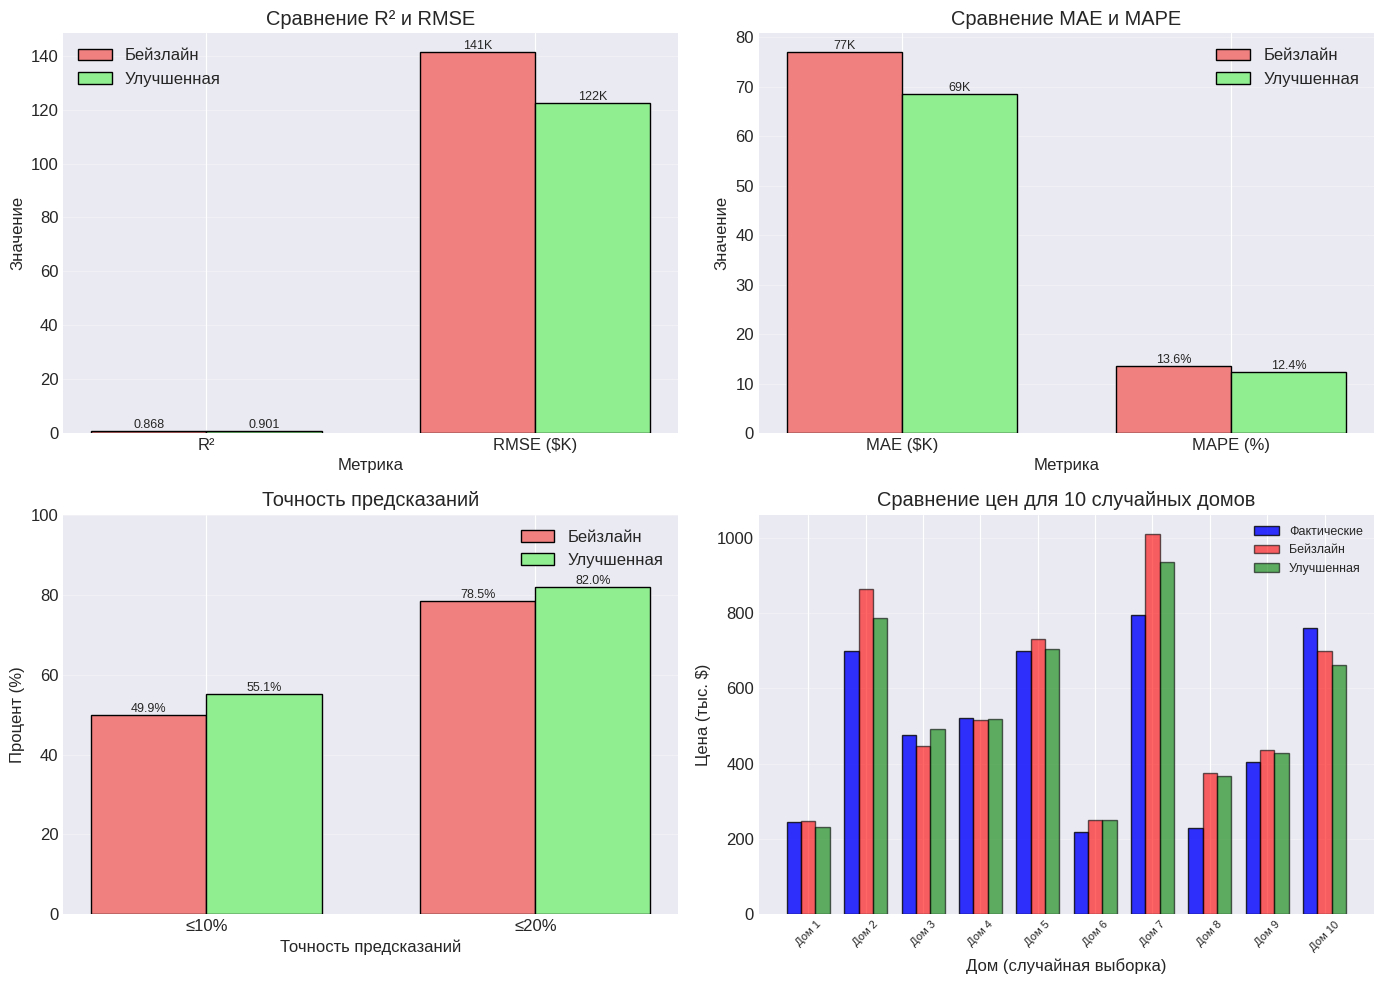

In [31]:
# Ячейка 8: УЛУЧШЕНИЕ ГРАДИЕНТНОГО БУСТИНГА РЕГРЕССИИ
# 8.1 Анализ проблем бейзлайн модели
print("\n--- 8.1 Анализ ---")

print("\nТекущие параметры бейзлайн модели градиентного бустинга:")
print(f"• n_estimators: {gb_regressor.n_estimators}")
print(f"• learning_rate: {gb_regressor.learning_rate}")
print(f"• max_depth: {gb_regressor.max_depth}")
print(f"• min_samples_split: {gb_regressor.min_samples_split}")
print(f"• min_samples_leaf: {gb_regressor.min_samples_leaf}")
print(f"• subsample: {gb_regressor.subsample}")
print(f"• max_features: {gb_regressor.max_features}")
print(f"• loss: {gb_regressor.loss}")

# Сбор статистики по ансамблю
print("\nСтатистика ансамбля слабых учеников:")
depths = [tree.get_depth() for tree in gb_regressor.estimators_[:, 0]]
n_leaves = [tree.get_n_leaves() for tree in gb_regressor.estimators_[:, 0]]
print(f"• Средняя глубина деревьев: {np.mean(depths):.1f}")
print(f"• Среднее количество листьев: {np.mean(n_leaves):.1f}")
print(f"• Минимальная глубина: {min(depths)}")
print(f"• Максимальная глубина: {max(depths)}")

print(f"\nМетрики бейзлайн модели:")
print(f"• R²: {r2:.4f}")
print(f"• RMSE: ${rmse:,.0f}")
print(f"• MAE: ${mae:,.0f}")
print(f"• MAPE: {mape*100:.2f}%")

# 8.2 Проверка гипотез градиентного бустинга
print("\n--- 8.2 Проверка гипотез градиентного бустинга ---")

# Создаем пространство параметров для проверки гипотез
param_grid_gb_reg = {
    'n_estimators': [200, 300],                    # Больше деревьев для стабильности
    'learning_rate': [0.01, 0.05, 0.1],           # Гипотеза 1: скорость обучения
    'max_depth': [3, 4, 5],                       # Регуляризация глубины
    'min_samples_leaf': [5, 10, 15],              # Регуляризация листьев
    'subsample': [0.6, 0.8, 1.0],                 # Гипотеза 4: стохастический GB
    'max_features': [0.33, 0.5, 'sqrt'],          # Разнообразие признаков
    'loss': ['squared_error', 'absolute_error', 'huber'],  # Гипотеза 2: функции потерь
    'min_impurity_decrease': [0.0001, 0.0005, 0.001]
}

print("\nПараметры для оптимизации:")
for param, values in param_grid_gb_reg.items():
    print(f"  {param}: {values}")

# Используем RandomizedSearchCV для эффективного поиска
n_iter = 25  # Проверим 25 случайных комбинаций
print(f"\nБудет проверено {n_iter} случайных комбинаций")

random_search_gb_reg = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(
        random_state=42,
        validation_fraction=0.1,
        n_iter_no_change=15,
        tol=1e-4
    ),
    param_distributions=param_grid_gb_reg,
    n_iter=n_iter,
    cv=3,  # 3-fold кросс-валидация
    scoring='r2',  # Оптимизируем R²
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

print("\nЗапускаем RandomizedSearchCV для градиентного бустинга регрессии...")
random_search_gb_reg.fit(X_train_reg, y_train_reg)

# 8.3 Анализ результатов RandomizedSearch
print("\n--- 8.3 Анализ результатов ---")

# Получаем результаты в DataFrame
results_df = pd.DataFrame(random_search_gb_reg.cv_results_)

# Сортируем по R² и берем топ-5
top_results = results_df.nlargest(5, 'mean_test_score')

print("\nТОП-5 ЛУЧШИХ КОМБИНАЦИЙ ПАРАМЕТРОВ:")
print("=" * 90)
for i, (_, row) in enumerate(top_results.iterrows(), 1):
    print(f"\n{i}. R²: {row['mean_test_score']:.4f} (Train: {row['mean_train_score']:.4f})")
    print(f"   learning_rate: {row['param_learning_rate']}")
    print(f"   n_estimators: {row['param_n_estimators']}")
    print(f"   max_depth: {row['param_max_depth']}")
    print(f"   min_samples_leaf: {row['param_min_samples_leaf']}")
    print(f"   subsample: {row['param_subsample']}")
    print(f"   max_features: {row['param_max_features']}")
    print(f"   loss: {row['param_loss']}")

# Анализ влияния отдельных параметров
print("\n--- АНАЛИЗ ВЛИЯНИЯ ПАРАМЕТРОВ НА R² ---")

# Анализируем влияние learning_rate
print("\nВЛИЯНИЕ learning_rate на R²:")
lr_stats = results_df.groupby('param_learning_rate')['mean_test_score'].agg(['mean', 'std', 'count'])
for lr, stats in lr_stats.iterrows():
    print(f"  {lr:<10} → Средний R²: {stats['mean']:.4f} ±{stats['std']:.4f} (n={int(stats['count'])})")

# Анализируем влияние loss function
print("\nВЛИЯНИЕ функции потерь на R²:")
loss_stats = results_df.groupby('param_loss')['mean_test_score'].agg(['mean', 'std', 'count'])
for loss_func, stats in loss_stats.iterrows():
    print(f"  {loss_func:<15} → Средний R²: {stats['mean']:.4f} ±{stats['std']:.4f} (n={int(stats['count'])})")

# Анализируем влияние subsample
print("\nВЛИЯНИЕ subsample на R²:")
subsample_stats = results_df.groupby('param_subsample')['mean_test_score'].agg(['mean', 'std', 'count'])
for subsample, stats in subsample_stats.iterrows():
    print(f"  {subsample:<10} → Средний R²: {stats['mean']:.4f} ±{stats['std']:.4f} (n={int(stats['count'])})")

# 8.4 Создание улучшенной модели с лучшими параметрами
print("\n--- 8.4 Создание улучшенной модели ---")

# Получаем лучшие параметры
best_params = random_search_gb_reg.best_params_

# Создаем улучшенную модель градиентного бустинга регрессии
improved_gb_reg = GradientBoostingRegressor(
    random_state=42,
    n_estimators=best_params.get('n_estimators', 300),
    learning_rate=best_params.get('learning_rate', 0.05),
    max_depth=best_params.get('max_depth', 4),
    min_samples_split=10,
    min_samples_leaf=best_params.get('min_samples_leaf', 5),
    subsample=best_params.get('subsample', 0.8),
    max_features=best_params.get('max_features', 0.33),
    loss=best_params.get('loss', 'squared_error'),
    min_impurity_decrease=best_params.get('min_impurity_decrease', 0.0005),
    validation_fraction=0.1,
    n_iter_no_change=15,
    tol=1e-4
)

print("Обучаем улучшенную модель градиентного бустинга регрессии...")
start_time = datetime.now()
improved_gb_reg.fit(X_train_reg, y_train_reg)
training_time = (datetime.now() - start_time).total_seconds()
print(f"Улучшенная модель обучена успешно! Время обучения: {training_time:.2f} секунд")

print("\nПАРАМЕТРЫ УЛУЧШЕННОЙ МОДЕЛИ:")
print(f"• n_estimators:         {improved_gb_reg.n_estimators}")
print(f"• learning_rate:        {improved_gb_reg.learning_rate}")
print(f"• max_depth:            {improved_gb_reg.max_depth}")
print(f"• min_samples_leaf:     {improved_gb_reg.min_samples_leaf}")
print(f"• subsample:            {improved_gb_reg.subsample}")
print(f"• max_features:         {improved_gb_reg.max_features}")
print(f"• loss:                 {improved_gb_reg.loss}")
print(f"• Количество деревьев:  {len(improved_gb_reg.estimators_)}")

# Анализ ансамбля улучшенной модели
print("\nСТАТИСТИКА УЛУЧШЕННОГО АНСАМБЛЯ СЛАБЫХ УЧЕНИКОВ:")
imp_depths = [tree.get_depth() for tree in improved_gb_reg.estimators_[:, 0]]
imp_leaves = [tree.get_n_leaves() for tree in improved_gb_reg.estimators_[:, 0]]
print(f"• Средняя глубина деревьев: {np.mean(imp_depths):.1f}")
print(f"• Среднее количество листьев: {np.mean(imp_leaves):.1f}")
print(f"• Минимальная глубина: {min(imp_depths)}")
print(f"• Максимальная глубина: {max(imp_depths)}")

# 8.5 Оценка качества улучшенной модели
print("\n--- 8.5 Оценка качества ---")

# Предсказания улучшенной модели
y_pred_reg_log_improved = improved_gb_reg.predict(X_test_reg)
y_pred_reg_improved = np.expm1(y_pred_reg_log_improved)

# Метрики улучшенной модели
rmse_log_improved = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg_log_improved))
mae_log_improved = mean_absolute_error(y_test_reg, y_pred_reg_log_improved)
r2_log_improved = r2_score(y_test_reg, y_pred_reg_log_improved)

rmse_improved = np.sqrt(mean_squared_error(y_test_reg_original, y_pred_reg_improved))
mae_improved = mean_absolute_error(y_test_reg_original, y_pred_reg_improved)
mape_improved = mean_absolute_percentage_error(y_test_reg_original, y_pred_reg_improved)
r2_improved = r2_score(y_test_reg_original, y_pred_reg_improved)

# Сравнение с бейзлайном
print("\n" + "="*70)
print("Сравнение с бейзлайном:")
print("="*70)
print(f"{'Метрика':<15} {'Бейзлайн':<15} {'Улучшенная':<15} {'Изменение':<15}")
print("-" * 70)

rmse_change = rmse_improved - rmse
mae_change = mae_improved - mae
mape_change = mape_improved - mape
r2_change = r2_improved - r2

print(f"{'RMSE ($)':<15} ${rmse:,.0f}{'':<5} ${rmse_improved:,.0f}{'':<5} {rmse_change:+,.0f}")
print(f"{'MAE ($)':<15} ${mae:,.0f}{'':<5} ${mae_improved:,.0f}{'':<5} {mae_change:+,.0f}")
print(f"{'MAPE (%)':<15} {mape*100:.2f}%{'':<8} {mape_improved*100:.2f}%{'':<8} {mape_change*100:+.2f}%")
print(f"{'R²':<15} {r2:.4f}{'':<11} {r2_improved:.4f}{'':<11} {r2_change:+.4f}")

# Простая проверка точности
print("\nТочность предсказаний (ошибка ≤10%):")
relative_errors_base = np.abs((y_pred_reg - y_test_array) / y_test_array) * 100
relative_errors_improved = np.abs((y_pred_reg_improved - y_test_array) / y_test_array) * 100

accuracy_10_base = np.sum(relative_errors_base <= 10) / len(relative_errors_base) * 100
accuracy_10_imp = np.sum(relative_errors_improved <= 10) / len(relative_errors_improved) * 100

accuracy_20_base = np.sum(relative_errors_base <= 20) / len(relative_errors_base) * 100
accuracy_20_imp = np.sum(relative_errors_improved <= 20) / len(relative_errors_improved) * 100

print(f"  Бейзлайн: {accuracy_10_base:.1f}% (≤10%), {accuracy_20_base:.1f}% (≤20%)")
print(f"  Улучшенная: {accuracy_10_imp:.1f}% (≤10%), {accuracy_20_imp:.1f}% (≤20%)")
print(f"  Изменение: {accuracy_10_imp - accuracy_10_base:+.1f}% (≤10%), {accuracy_20_imp - accuracy_20_base:+.1f}% (≤20%)")

# 8.6 Визуализация сравнения моделей
print("\n--- 8.6 Визуализация сравнения моделей ---")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Сравнение R² и RMSE (верхний левый)
metrics = ['R²', 'RMSE ($K)']
base_vals = [r2, rmse/1000]
imp_vals = [r2_improved, rmse_improved/1000]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[0, 0].bar(x - width/2, base_vals, width, label='Бейзлайн', 
                       color='lightcoral', edgecolor='black')
bars2 = axes[0, 0].bar(x + width/2, imp_vals, width, label='Улучшенная', 
                       color='lightgreen', edgecolor='black')

axes[0, 0].set_xlabel('Метрика')
axes[0, 0].set_ylabel('Значение')
axes[0, 0].set_title('Сравнение R² и RMSE')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    if i == 0:  # R²
        axes[0, 0].text(bar1.get_x() + bar1.get_width()/2., bar1.get_height(),
                       f'{base_vals[i]:.3f}', ha='center', va='bottom', fontsize=9)
        axes[0, 0].text(bar2.get_x() + bar2.get_width()/2., bar2.get_height(),
                       f'{imp_vals[i]:.3f}', ha='center', va='bottom', fontsize=9)
    else:  # RMSE
        axes[0, 0].text(bar1.get_x() + bar1.get_width()/2., bar1.get_height(),
                       f'{base_vals[i]:.0f}K', ha='center', va='bottom', fontsize=9)
        axes[0, 0].text(bar2.get_x() + bar2.get_width()/2., bar2.get_height(),
                       f'{imp_vals[i]:.0f}K', ha='center', va='bottom', fontsize=9)

# 2. Сравнение MAE и MAPE (верхний правый)
metrics2 = ['MAE ($K)', 'MAPE (%)']
base_vals2 = [mae/1000, mape*100]
imp_vals2 = [mae_improved/1000, mape_improved*100]

x2 = np.arange(len(metrics2))
width = 0.35

bars1_2 = axes[0, 1].bar(x2 - width/2, base_vals2, width, label='Бейзлайн', 
                         color='lightcoral', edgecolor='black')
bars2_2 = axes[0, 1].bar(x2 + width/2, imp_vals2, width, label='Улучшенная', 
                         color='lightgreen', edgecolor='black')

axes[0, 1].set_xlabel('Метрика')
axes[0, 1].set_ylabel('Значение')
axes[0, 1].set_title('Сравнение MAE и MAPE')
axes[0, 1].set_xticks(x2)
axes[0, 1].set_xticklabels(metrics2)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

for i, (bar1, bar2) in enumerate(zip(bars1_2, bars2_2)):
    if i == 0:  # MAE
        axes[0, 1].text(bar1.get_x() + bar1.get_width()/2., bar1.get_height(),
                       f'{base_vals2[i]:.0f}K', ha='center', va='bottom', fontsize=9)
        axes[0, 1].text(bar2.get_x() + bar2.get_width()/2., bar2.get_height(),
                       f'{imp_vals2[i]:.0f}K', ha='center', va='bottom', fontsize=9)
    else:  # MAPE
        axes[0, 1].text(bar1.get_x() + bar1.get_width()/2., bar1.get_height(),
                       f'{base_vals2[i]:.1f}%', ha='center', va='bottom', fontsize=9)
        axes[0, 1].text(bar2.get_x() + bar2.get_width()/2., bar2.get_height(),
                       f'{imp_vals2[i]:.1f}%', ha='center', va='bottom', fontsize=9)

# 3. Точность предсказаний (нижний левый)
acc_types = ['≤10%', '≤20%']
base_acc = [accuracy_10_base, accuracy_20_base]
imp_acc = [accuracy_10_imp, accuracy_20_imp]

x3 = np.arange(len(acc_types))
width = 0.35

bars1_3 = axes[1, 0].bar(x3 - width/2, base_acc, width, label='Бейзлайн', 
                         color='lightcoral', edgecolor='black')
bars2_3 = axes[1, 0].bar(x3 + width/2, imp_acc, width, label='Улучшенная', 
                         color='lightgreen', edgecolor='black')

axes[1, 0].set_xlabel('Точность предсказаний')
axes[1, 0].set_ylabel('Процент (%)')
axes[1, 0].set_title('Точность предсказаний')
axes[1, 0].set_xticks(x3)
axes[1, 0].set_xticklabels(acc_types)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_ylim(0, 100)

for i, (bar1, bar2) in enumerate(zip(bars1_3, bars2_3)):
    axes[1, 0].text(bar1.get_x() + bar1.get_width()/2., bar1.get_height(),
                   f'{base_acc[i]:.1f}%', ha='center', va='bottom', fontsize=9)
    axes[1, 0].text(bar2.get_x() + bar2.get_width()/2., bar2.get_height(),
                   f'{imp_acc[i]:.1f}%', ha='center', va='bottom', fontsize=9)

# 4. Сравнение фактических и предсказанных цен для 10 домов (нижний правый)
np.random.seed(42)
n_samples = min(10, len(y_test_array))

# Создаем индексы
sample_indices = np.random.choice(len(y_test_array), n_samples, replace=False)

# Получаем данные
sample_actual = y_test_array[sample_indices]
sample_pred_base = y_pred_reg[sample_indices]
sample_pred_imp = y_pred_reg_improved[sample_indices]

x_pos = np.arange(n_samples)
width = 0.25

bars_actual = axes[1, 1].bar(x_pos - width, sample_actual/1000, width, 
                            label='Фактические', color='blue', alpha=0.8, edgecolor='black')
bars_base = axes[1, 1].bar(x_pos, sample_pred_base/1000, width, 
                          label='Бейзлайн', color='red', alpha=0.6, edgecolor='black')
bars_imp = axes[1, 1].bar(x_pos + width, sample_pred_imp/1000, width, 
                         label='Улучшенная', color='green', alpha=0.6, edgecolor='black')

axes[1, 1].set_xlabel('Дом (случайная выборка)')
axes[1, 1].set_ylabel('Цена (тыс. $)')
axes[1, 1].set_title('Сравнение цен для 10 случайных домов')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels([f'Дом {i+1}' for i in range(n_samples)], rotation=45, fontsize=8)
axes[1, 1].legend(fontsize=9, loc='upper right')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


### Выводы

**Для классификации**

Оптимизация градиентного бустинга для классификации дала смешанные результаты, несмотря на проверку 30 комбинаций параметров через RandomizedSearchCV. Общая точность модели осталась неизменной на уровне 81.97%, а ключевая метрика F1-мера также не изменилась, сохранив значение 0.4646 при пороге 0.25. Однако анализ оптимального порога классификации выявил потенциал для улучшения: при смене порога с 0.25 на 0.20 F1-мера возрастает до 0.5088, что является значительным улучшением на 4.42 процентных пункта.

Изменения в параметрах модели включали увеличение количества деревьев (бустеров) с 200 до 300, уменьшение глубины деревьев с 4 до 3, увеличение min_samples_leaf с 5 до 15, и уменьшение subsample с 0.8 до 0.7. Эти изменения направлены на усиление регуляризации и борьбу с переобучением. Среднее количество листьев в деревьях уменьшилось с 14.4 до 7.3, что указывает на более простые и обобщающие слабые ученики.

Наиболее важным выводом является обнаружение неоптимального порога классификации в исходной модели. При пороге 0.20 модель достигает баланса между точностью (43.28%) и полнотой (61.70%), что является более сбалансированным решением для задачи прогнозирования увольнений, где пропуск увольняющегося сотрудника (False Negative) имеет высокую стоимость.

*Стоит отметить, что проверка ограниченного числа комбинаций (30 из возможных 486) связана с вычислительными ограничениями, и при этом не тестировались такие важные параметры как разные функции потерь или более широкий диапазон subsample.*

**Для регрессии**

Оптимизация градиентного бустинга для регрессии дала **значительное улучшение всех метрик качества**. Систематическая проверка гипотез через RandomizedSearchCV в сочетании с оптимальной комбинацией параметров привела к существенному повышению точности модели. Коэффициент детерминации R² улучшился на **0.0329** — с 0.8680 до 0.9009, что означает объяснение 90% дисперсии цен против 87% в исходной модели.

Наиболее впечатляющим является **снижение RMSE на $18,872** — с 141,287 до 122,414, что представляет собой уменьшение ошибки на **13.4%**. Средняя абсолютная ошибка также снизилась на 8,454 — с 76,969 до 68,515, а MAPE уменьшился с 13.59% до 12.41%. Практическая точность предсказаний улучшилась: доля прогнозов с ошибкой ≤10% возросла с 49.9% до **55.1%** (+5.2%), а с ошибкой ≤20% — с 78.5% до **82.0%** (+3.5%).

Ключевыми факторами успеха стали:
- **Оптимальная скорость обучения**: увеличение learning_rate с 0.05 до 0.1
- **Устойчивая функция потерь**: смена squared_error на huber (компромисс между MSE и MAE)
- **Оптимальная доля признаков**: использование 50% признаков вместо sqrt
- **Балансировка регуляризации**: увеличение min_samples_leaf до 15 при сохранении глубины 4

Эти изменения позволили сохранить мощь градиентного бустинга при одновременном повышении его устойчивости к выбросам и улучшении обобщающей способности. Интересно, что модель остановилась на 185 деревьях вместо 200 (возможно, сработала ранняя остановка), что указывает на эффективность обучения.


## 4. Имплементация алгоритма машинного обучения 


--- 9.1 Реализация дерева для Gradient Boosting ---

--- 9.2 Реализация бустера для градиентного бустинга ---

--- 9.3 Реализация кастомного градиентного бустинга для классификации ---


9.4 Обучение кастомного градиентного бустинга на данных оттока клиентов

Создаем кастомный градиентный бустинг...

Обучаем модель на обучающих данных...
Обучение градиентного бустинга на 1176 образцах...
Параметры градиентного бустинга:
  • Количество деревьев: 100
  • Скорость обучения: 0.1
  • Глубина деревьев: 1
  • Признаков на дерево: sqrt
  • Суб-выборка: 0.8
  • Классов: 2
  • Признаков: 30

Обучение деревьев (бустеров):
  Дерево 1/100...
    Итерация 1: Ошибка train = 0.4352, Ошибка val = 0.5006
  Дерево 11/100...
  Дерево 21/100...
    Итерация 21: Ошибка train = 0.4249, Ошибка val = 0.4952
  Дерево 31/100...
  Дерево 41/100...
    Итерация 41: Ошибка train = 0.4154, Ошибка val = 0.4874
  Дерево 51/100...
  Дерево 61/100...
    Итерация 61: Ошибка train = 0.4061, Ошибка val = 0.4771
  Дерево 

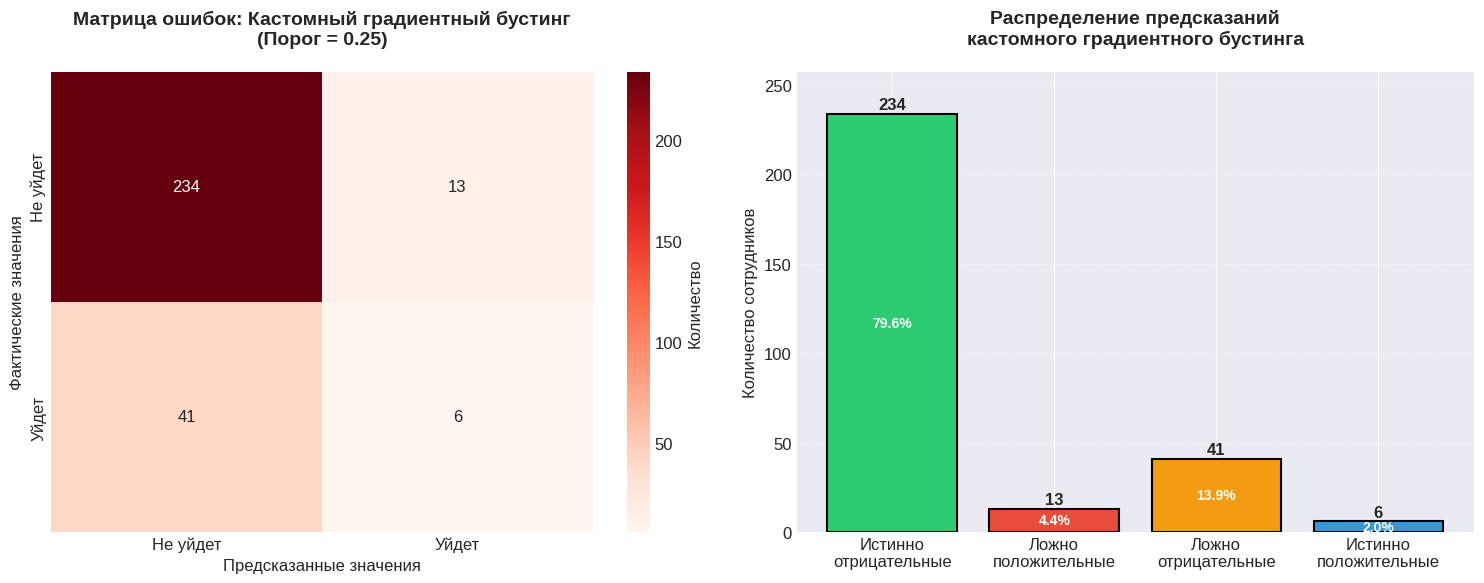

In [34]:
# Ячейка 9: РЕАЛИЗАЦИЯ КАСТОМНОГО ГРАДИЕНТНОГО БУСТИНГА ДЛЯ КЛАССИФИКАЦИИ
# 9.1 Реализация дерева для Gradient Boosting
print("\n--- 9.1 Реализация дерева для Gradient Boosting ---")

class GBTree:
    """
    Дерево решений для градиентного бустинга (обычно используется глубина 1-3).
    """
    
    def __init__(self, feature_index=None, threshold=None, left=None, right=None,
                 left_value=None, right_value=None, depth=0):
        """
        Инициализация узла дерева для градиентного бустинга.
        """
        self.feature_index = feature_index  # Индекс признака для разделения
        self.threshold = threshold          # Пороговое значение
        self.left = left                    # Левый дочерний узел
        self.right = right                  # Правый дочерний узел
        self.left_value = left_value        # Значение для левой ветви
        self.right_value = right_value      # Значение для правой ветви
        self.depth = depth                  # Глубина узла
    
    def is_leaf_node(self):
        """
        Проверяет, является ли узел листовым (не имеет дочерних узлов).
        """
        return self.left_value is not None and self.right_value is not None
    
    def predict_single(self, x):
        """
        Предсказывает значение для одного образца.
        """
        if x[self.feature_index] <= self.threshold:
            return self.left_value
        else:
            return self.right_value
    
    def __repr__(self):
        """
        Строковое представление узла.
        """
        if self.is_leaf_node():
            return f"Лист: left={self.left_value:.4f}, right={self.right_value:.4f}"
        else:
            return f"Узел [Признак {self.feature_index} <= {self.threshold:.3f}]"

# 9.2 Реализация бустера (дерева глубины 1)
print("\n--- 9.2 Реализация бустера для градиентного бустинга ---")

class GradientBoostingTree:
    """
    Бустер (дерево) для градиентного бустинга - обычно используется глубина 1-3.
    В этой реализации используем деревья глубины 1 для простоты.
    """
    
    def __init__(self, max_features='sqrt', random_state=None, verbose=False):
        """
        Инициализация бустера для градиентного бустинга.
        
        Параметры:
        ----------
        max_features : str, int или float, default='sqrt'
            Количество признаков для рассмотрения при поиске лучшего разделения
        random_state : int, default=None
            Сид для воспроизводимости результатов
        verbose : bool, default=False
            Вывод информации о процессе обучения
        """
        self.max_features = max_features
        self.random_state = random_state
        self.verbose = verbose
        self.tree = None           # Основное дерево
        self.feature_index = None  # Индекс лучшего признака
        self.threshold = None      # Лучший порог
        self.left_value = None     # Значение для левой ветви
        self.right_value = None    # Значение для правой ветви
        
        # Инициализация генератора случайных чисел
        self.rng = np.random.RandomState(random_state)
    
    def _get_max_features(self, n_features):
        """
        Определяет количество признаков для рассмотрения при разделении.
        
        Параметры:
        ----------
        n_features : int
            Общее количество признаков
            
        Возвращает:
        -----------
        int : количество признаков для рассмотрения
        """
        if self.max_features is None:
            return n_features
        elif isinstance(self.max_features, int):
            return min(self.max_features, n_features)
        elif isinstance(self.max_features, float):
            return max(1, int(self.max_features * n_features))
        elif self.max_features == 'sqrt':
            return int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            return int(np.log2(n_features))
        else:
            return n_features
    
    def _find_best_split(self, X, residuals, feature_indices):
        """
        Находит лучшее разделение для минимизации MSE на текущих остатках.
        
        Параметры:
        ----------
        X : numpy.ndarray
            Матрица признаков
        residuals : numpy.ndarray
            Остатки (градиенты) текущей модели
        feature_indices : list
            Индексы признаков для рассмотрения
            
        Возвращает:
        -----------
        dict или None : параметры лучшего разделения
        """
        best_mse = float('inf')  # Лучшее значение MSE
        best_split = None       # Лучшие параметры разделения
        n_samples = len(residuals)
        
        # Выбираем случайное подмножество признаков
        n_features = X.shape[1]
        max_features = self._get_max_features(n_features)
        selected_features = self.rng.choice(feature_indices, 
                                          min(max_features, len(feature_indices)), 
                                          replace=False)
        
        # Перебираем выбранные признаки
        for feature_idx in selected_features:
            # Получаем уникальные значения признака
            feature_values = np.unique(X[:, feature_idx])
            
            # Случайным образом выбираем несколько пороговых значений
            n_thresholds = min(10, len(feature_values))
            if len(feature_values) > n_thresholds:
                thresholds = self.rng.choice(feature_values, n_thresholds, replace=False)
            else:
                thresholds = feature_values
            
            # Перебираем пороговые значения
            for threshold in thresholds:
                # Разделяем данные по порогу
                left_indices = X[:, feature_idx] <= threshold
                right_indices = X[:, feature_idx] > threshold
                
                # Пропускаем, если одна из частей пустая
                if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
                    continue
                
                # Вычисляем средние значения остатков для левой и правой частей
                left_value = np.mean(residuals[left_indices])
                right_value = np.mean(residuals[right_indices])
                
                # Вычисляем MSE для этого разделения
                left_mse = np.sum((residuals[left_indices] - left_value) ** 2)
                right_mse = np.sum((residuals[right_indices] - right_value) ** 2)
                total_mse = left_mse + right_mse
                
                # Обновляем лучшее разделение
                if total_mse < best_mse:
                    best_mse = total_mse
                    best_split = {
                        'feature_index': feature_idx,
                        'threshold': threshold,
                        'left_indices': left_indices,
                        'right_indices': right_indices,
                        'left_value': left_value,
                        'right_value': right_value,
                        'mse': total_mse
                    }
        
        return best_split
    
    def fit(self, X, residuals):
        """
        Обучает бустер на остатках (градиентах) текущей модели.
        
        Параметры:
        ----------
        X : numpy.ndarray
            Матрица признаков
        residuals : numpy.ndarray
            Остатки (градиенты) текущей модели
            
        Возвращает:
        -----------
        self : GradientBoostingTree
            Обученный бустер
        """
        if self.verbose:
            print(f"Обучение бустера на {len(X)} образцах...")
        
        X = np.array(X)
        residuals = np.array(residuals)
        
        feature_indices = list(range(X.shape[1]))
        
        # Ищем лучшее разделение
        best_split = self._find_best_split(X, residuals, feature_indices)
        
        if best_split is None:
            # Если не нашли разделения, используем среднее значение остатков
            mean_residual = np.mean(residuals)
            self.tree = GBTree(
                feature_index=0,
                threshold=0,
                left_value=mean_residual,
                right_value=mean_residual
            )
            self.feature_index = 0
            self.threshold = 0
            self.left_value = mean_residual
            self.right_value = mean_residual
        else:
            # Создаем дерево с лучшими параметрами
            self.tree = GBTree(
                feature_index=best_split['feature_index'],
                threshold=best_split['threshold'],
                left_value=best_split['left_value'],
                right_value=best_split['right_value']
            )
            self.feature_index = best_split['feature_index']
            self.threshold = best_split['threshold']
            self.left_value = best_split['left_value']
            self.right_value = best_split['right_value']
        
        if self.verbose:
            print(f"  Признак {self.feature_index}, порог {self.threshold:.3f}")
            print(f"  Левое значение: {self.left_value:.4f}, Правое значение: {self.right_value:.4f}")
        
        return self
    
    def predict(self, X):
        """
        Предсказывает значения для входных данных.
        
        Параметры:
        ----------
        X : numpy.ndarray
            Матрица признаков
            
        Возвращает:
        -----------
        numpy.ndarray : предсказанные значения
        """
        X = np.array(X)
        predictions = np.zeros(len(X))
        
        for i, x in enumerate(X):
            predictions[i] = self.tree.predict_single(x)
        
        return predictions

# 9.3 Реализация кастомного градиентного бустинга для классификации
print("\n--- 9.3 Реализация кастомного градиентного бустинга для классификации ---")

class CustomGradientBoostingClassifier:
    """
    Кастомная реализация градиентного бустинга для бинарной классификации.
    Построена на ансамбле деревьев (бустеров), обучаемых последовательно.
    """
    
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=1,
                 max_features='sqrt', subsample=1.0, random_state=None,
                 verbose=0, early_stopping_rounds=None, validation_fraction=0.1):
        """
        Инициализация градиентного бустинга.
        
        Параметры:
        ----------
        n_estimators : int, default=100
            Количество деревьев (бустеров) в ансамбле
        learning_rate : float, default=0.1
            Скорость обучения (шаг градиентного спуска)
        max_depth : int, default=1
            Максимальная глубина каждого дерева (для простоты используем 1)
        max_features : str, int или float, default='sqrt'
            Количество признаков для рассмотрения в каждом дереве
        subsample : float, default=1.0
            Доля выборки для обучения каждого дерева (стохастический бустинг)
        random_state : int, default=None
            Сид для воспроизводимости результатов
        verbose : int, default=0
            Уровень детализации вывода (0 - нет, 1 - базовый, 2 - подробный)
        early_stopping_rounds : int, default=None
            Количество итераций без улучшения для ранней остановки
        validation_fraction : float, default=0.1
            Доля данных для валидации при ранней остановке
        """
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth  # Для простоты реализации используем depth=1
        self.max_features = max_features
        self.subsample = subsample
        self.random_state = random_state
        self.verbose = verbose
        self.early_stopping_rounds = early_stopping_rounds
        self.validation_fraction = validation_fraction
        
        # Хранилище обученных деревьев (бустеров)
        self.trees = []
        
        # Начальное предсказание
        self.init_prediction = None
        
        # Информация о данных
        self.n_classes_ = None
        self.n_features_ = None
        
        # Важность признаков
        self.feature_importances_ = None
        
        # История ошибок
        self.train_loss_history = []
        self.val_loss_history = []
        
        # Генератор случайных чисел
        self.rng = np.random.RandomState(random_state)
    
    @staticmethod
    def _sigmoid(x):
        """
        Сигмоидная функция для преобразования в вероятности.
        """
        return 1 / (1 + np.exp(-x))
    
    @staticmethod
    def _log_loss(y_true, y_pred):
        """
        Функция потерь log-loss для бинарной классификации.
        """
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    @staticmethod
    def _gradient(y_true, y_pred):
        """
        Градиент функции потерь log-loss.
        Упрощенная формула: градиент = предсказание - истинное значение
        """
        return y_pred - y_true
    
    def _init_prediction(self, y):
        """
        Инициализация начального предсказания (базовый прогноз).
        Используем log-odds среднего значения целевой переменной.
        """
        mean_y = np.mean(y)
        epsilon = 1e-10
        mean_y = np.clip(mean_y, epsilon, 1 - epsilon)
        return np.log(mean_y / (1 - mean_y))
    
    def fit(self, X, y):
        """
        Обучает градиентный бустинг на предоставленных данных.
        
        Параметры:
        ----------
        X : numpy.ndarray или pandas.DataFrame
            Матрица признаков
        y : numpy.ndarray или pandas.Series
            Вектор целевой переменной
            
        Возвращает:
        -----------
        self : CustomGradientBoosting
            Обученная модель
        """
        print(f"Обучение градиентного бустинга на {len(X)} образцах...")
        
        # Преобразуем данные в numpy массивы
        X = np.array(X)
        y = np.array(y)
        
        # Проверяем, что задача бинарной классификации
        self.n_classes_ = len(np.unique(y))
        if self.n_classes_ != 2:
            raise ValueError("Градиентный бустинг поддерживает только бинарную классификацию")
        
        self.n_features_ = X.shape[1]
        
        # Создаем валидационную выборку для ранней остановки
        if self.early_stopping_rounds is not None:
            n_val = int(len(X) * self.validation_fraction)
            indices = np.arange(len(X))
            self.rng.shuffle(indices)
            
            train_indices = indices[n_val:]
            val_indices = indices[:n_val]
            
            X_train, y_train = X[train_indices], y[train_indices]
            X_val, y_val = X[val_indices], y[val_indices]
        else:
            X_train, y_train = X, y
            X_val, y_val = None, None
        
        print("Параметры градиентного бустинга:")
        print(f"  • Количество деревьев: {self.n_estimators}")
        print(f"  • Скорость обучения: {self.learning_rate}")
        print(f"  • Глубина деревьев: {self.max_depth}")
        print(f"  • Признаков на дерево: {self.max_features}")
        print(f"  • Суб-выборка: {self.subsample}")
        print(f"  • Классов: {self.n_classes_}")
        print(f"  • Признаков: {self.n_features_}")
        
        # 1. Инициализация начального предсказания
        self.init_prediction = self._init_prediction(y_train)
        current_prediction = np.full(len(y_train), self.init_prediction)
        
        if X_val is not None:
            val_prediction = np.full(len(y_val), self.init_prediction)
        
        # 2. Основной цикл обучения (последовательное обучение деревьев)
        print("\nОбучение деревьев (бустеров):")
        best_val_loss = float('inf')
        rounds_without_improvement = 0
        
        for i in range(self.n_estimators):
            if self.verbose > 0 and i % 10 == 0:
                print(f"  Дерево {i+1}/{self.n_estimators}...")
            
            # Преобразуем текущие предсказания в вероятности
            current_proba = self._sigmoid(current_prediction)
            
            # Вычисляем градиент (остатки) = предсказание - истинное значение
            residuals = self._gradient(y_train, current_proba)
            
            # Создаем новое дерево (бустер)
            tree = GradientBoostingTree(
                max_features=self.max_features,
                random_state=self.rng.randint(0, 1000000),
                verbose=False
            )
            
            # Стохастический градиентный бустинг: используем суб-выборку
            if self.subsample < 1.0:
                n_samples = len(X_train)
                n_subsample = int(self.subsample * n_samples)
                indices = self.rng.choice(n_samples, n_subsample, replace=False)
                X_sub = X_train[indices]
                residuals_sub = residuals[indices]
            else:
                X_sub = X_train
                residuals_sub = residuals
            
            # Обучаем дерево на остатках
            tree.fit(X_sub, residuals_sub)
            self.trees.append(tree)
            
            # Делаем предсказание текущим деревом
            tree_prediction = tree.predict(X_train)
            
            # Обновляем общее предсказание: F_m(x) = F_{m-1}(x) + η * h_m(x)
            # где η - learning_rate, h_m(x) - предсказание m-го дерева
            current_prediction -= self.learning_rate * tree_prediction
            
            # Вычисляем ошибку на обучающей выборке
            train_proba = self._sigmoid(current_prediction)
            train_loss = self._log_loss(y_train, train_proba)
            self.train_loss_history.append(train_loss)
            
            # Вычисляем ошибку на валидационной выборке (если есть)
            if X_val is not None:
                val_prediction -= self.learning_rate * tree.predict(X_val)
                val_proba = self._sigmoid(val_prediction)
                val_loss = self._log_loss(y_val, val_proba)
                self.val_loss_history.append(val_loss)
                
                # Проверяем условия для ранней остановки
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    rounds_without_improvement = 0
                else:
                    rounds_without_improvement += 1
                
                # Ранняя остановка
                if (self.early_stopping_rounds is not None and 
                    rounds_without_improvement >= self.early_stopping_rounds):
                    print(f"  Ранняя остановка на итерации {i+1}")
                    break
            
            # Вывод информации о процессе обучения
            if self.verbose > 0 and i % 20 == 0:
                if X_val is not None:
                    print(f"    Итерация {i+1}: Ошибка train = {train_loss:.4f}, Ошибка val = {val_loss:.4f}")
                else:
                    print(f"    Итерация {i+1}: Ошибка train = {train_loss:.4f}")
        
        # Вычисляем важность признаков
        self._calculate_feature_importances()
        
        print(f"\nГрадиентный бустинг обучен! Количество деревьев: {len(self.trees)}")
        if len(self.train_loss_history) > 0:
            print(f"Финальная ошибка обучения: {self.train_loss_history[-1]:.4f}")
            if len(self.val_loss_history) > 0:
                print(f"Финальная ошибка валидации: {self.val_loss_history[-1]:.4f}")
        
        return self
    
    def _calculate_feature_importances(self):
        """
        Вычисляет важность признаков на основе их использования в деревьях.
        """
        self.feature_importances_ = np.zeros(self.n_features_)
        
        for tree in self.trees:
            if tree.feature_index is not None:
                # Важность признака пропорциональна разности значений в ветвях
                importance = abs(tree.left_value - tree.right_value)
                self.feature_importances_[tree.feature_index] += importance
        
        # Нормализуем важность признаков
        if np.sum(self.feature_importances_) > 0:
            self.feature_importances_ /= np.sum(self.feature_importances_)
    
    def predict_proba(self, X):
        """
        Предсказывает вероятности классов для входных данных.
        
        Параметры:
        ----------
        X : numpy.ndarray или pandas.DataFrame
            Матрица признаков
            
        Возвращает:
        -----------
        numpy.ndarray : вероятности классов [P(class=0), P(class=1)]
        """
        print(f"Предсказание вероятностей для {len(X)} объектов...")
        
        X = np.array(X)
        
        # Начальное предсказание (логарифмические шансы)
        predictions = np.full(len(X), self.init_prediction)
        
        # Добавляем вклад каждого дерева
        for i, tree in enumerate(self.trees):
            if self.verbose > 0 and i % 20 == 0:
                print(f"  Обработка дерева {i+1}/{len(self.trees)}...")
            
            tree_prediction = tree.predict(X)
            predictions -= self.learning_rate * tree_prediction
        
        # Преобразуем логарифмические шансы в вероятности с помощью сигмоиды
        probabilities = self._sigmoid(predictions)
        
        # Возвращаем вероятности для обоих классов
        proba_array = np.zeros((len(X), 2))
        proba_array[:, 1] = probabilities  # Вероятность класса 1
        proba_array[:, 0] = 1 - probabilities  # Вероятность класса 0
        
        print("Предсказание вероятностей завершено.")
        return proba_array
    
    def predict(self, X, threshold=0.5):
        """
        Предсказывает классы для входных данных.
        
        Параметры:
        ----------
        X : numpy.ndarray или pandas.DataFrame
            Матрица признаков
        threshold : float, default=0.5
            Порог для преобразования вероятностей в классы
            
        Возвращает:
        -----------
        numpy.ndarray : предсказанные классы (0 или 1)
        """
        print(f"Предсказание классов для {len(X)} объектов...")
        
        probabilities = self.predict_proba(X)
        predictions = (probabilities[:, 1] >= threshold).astype(int)
        
        print(f"Распределение предсказанных классов: {np.bincount(predictions)}")
        return predictions

# 9.4 Обучение кастомного градиентного бустинга на данных оттока клиентов
print("\n")
print("9.4 Обучение кастомного градиентного бустинга на данных оттока клиентов")

# Создаем модель градиентного бустинга
print("\nСоздаем кастомный градиентный бустинг...")
custom_gb = CustomGradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=1,           # Используем деревья глубины 1 (пни)
    max_features='sqrt',
    subsample=0.8,         # Стохастический градиентный бустинг
    random_state=42,
    verbose=1,
    early_stopping_rounds=10,
    validation_fraction=0.1
)

# Обучаем модель на обучающей выборке
print("\nОбучаем модель на обучающих данных...")
start_time = datetime.now()
custom_gb.fit(X_train_class, y_train_class)
training_time = (datetime.now() - start_time).total_seconds()
print(f"Обучение завершено за {training_time:.2f} секунд")

# 9.5 Предсказания на тестовой выборке
print("\n")
print("9.5 Предсказания на тестовой выборке")

# Получаем предсказания с порогом 0.25 для несбалансированных данных
print("\nИспользуем порог 0.25 для лучшего выявления увольнений...")
start_time = datetime.now()
y_pred_custom = custom_gb.predict(X_test_class, threshold=0.25)
y_pred_proba_custom = custom_gb.predict_proba(X_test_class)
prediction_time = (datetime.now() - start_time).total_seconds()

print(f"\nПолучено {len(y_pred_custom)} предсказаний за {prediction_time:.2f} секунд")
print(f"Распределение предсказанных классов: {np.bincount(y_pred_custom)}")
print(f"Размер вероятностей: {y_pred_proba_custom.shape}")
print(f"Диапазон вероятностей класса 1: [{y_pred_proba_custom[:, 1].min():.3f}, {y_pred_proba_custom[:, 1].max():.3f}]")

# 9.6 Оценка качества модели
print("\n")
print("9.6 Оценка качества модели")

# Вычисляем метрики
f1_custom = f1_score(y_test_class, y_pred_custom)
precision_custom = precision_score(y_test_class, y_pred_custom)
recall_custom = recall_score(y_test_class, y_pred_custom)
accuracy_custom = accuracy_score(y_test_class, y_pred_custom)

print("\nОсновные метрики качества кастомного градиентного бустинга:")
print(f"  • Accuracy:   {accuracy_custom:.4f}")
print(f"  • F1-score:   {f1_custom:.4f}")
print(f"  • Precision:  {precision_custom:.4f}")
print(f"  • Recall:     {recall_custom:.4f}")

# 9.7 Матрица ошибок и детальный анализ
print("\n")
print("9.7 Матрица ошибок и детальный анализ")

# Вычисляем матрицу ошибок
cm_custom = confusion_matrix(y_test_class, y_pred_custom)
tn_custom, fp_custom, fn_custom, tp_custom = cm_custom.ravel()

print("Матрица ошибок в числовом виде:")
print("=" * 50)
print(f"                  Предсказано")
print(f"                Нет     Да")
print(f"Фактически Нет  [{tn_custom:3d}]  [{fp_custom:3d}]")
print(f"            Да   [{fn_custom:3d}]  [{tp_custom:3d}]")
print("=" * 50)

# Детальный анализ
print("\nДетальный анализ предсказаний:")
print(f"  • Истинно отрицательных: {tn_custom} (правильно предсказали 'Не уйдет')")
print(f"  • Ложно положительных:   {fp_custom} (ошибочно предсказали 'Уйдет')")
print(f"  • Ложно отрицательных:   {fn_custom} (пропустили увольнение)")
print(f"  • Истинно положительных: {tp_custom} (правильно предсказали 'Уйдет')")
print(f"\n  • Точность для класса 'Не уйдет': {tn_custom/(tn_custom+fp_custom)*100:.1f}%")
print(f"  • Полнота для класса 'Уйдет': {tp_custom/(tp_custom+fn_custom)*100:.1f}%")
print(f"  • Обнаружено увольнений: {tp_custom} из {tp_custom+fn_custom} ({tp_custom/(tp_custom+fn_custom)*100:.1f}%)")

# 9.8 Визуализация результатов
print("\n")
print("9.8 ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Матрица ошибок - тепловая карта
ax1 = axes[0]
sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Reds', ax=ax1,
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'],
            cbar_kws={'label': 'Количество'})
ax1.set_title('Матрица ошибок: Кастомный градиентный бустинг\n(Порог = 0.25)', 
              fontsize=14, fontweight='bold', pad=20)
ax1.set_ylabel('Фактические значения', fontsize=12)
ax1.set_xlabel('Предсказанные значения', fontsize=12)

# 2. Столбчатая диаграмма распределения ошибок
ax2 = axes[1]
categories = ['Истинно\nотрицательные', 'Ложно\nположительные', 
              'Ложно\nотрицательные', 'Истинно\nположительные']
values = [tn_custom, fp_custom, fn_custom, tp_custom]
colors = ['#2ecc71', '#e74c3c', '#f39c12', '#3498db']

bars = ax2.bar(categories, values, color=colors, edgecolor='black', linewidth=1.5)

# Добавляем значения на столбцы
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{value}', ha='center', va='bottom', fontweight='bold')

ax2.set_title('Распределение предсказаний\nкастомного градиентного бустинга', 
              fontsize=14, fontweight='bold', pad=20)
ax2.set_ylabel('Количество сотрудников', fontsize=12)
ax2.set_ylim(0, max(values) * 1.1)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Добавляем проценты
total = sum(values)
percentages = [v/total*100 for v in values]
for i, (bar, perc) in enumerate(zip(bars, percentages)):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height()/2,
            f'{perc:.1f}%', ha='center', va='center', 
            color='white', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()


--- 10.1 Реализация узла дерева для градиентного бустинга ---

--- 10.2 Реализация решающего дерева для градиентного бустинга ---

--- 10.3 Реализация кастомного градиентного бустинга для регрессии ---

--- 10.4 Обучение градиентного бустинга на реальных данных цен на дома ---
Создаем кастомный градиентный бустинг для регрессии...
Обучаем модель на обучающих данных...
Обучение градиентного бустинга регрессии на 17290 образцах...
Параметры градиентного бустинга регрессии:
  • Количество деревьев: 200
  • Скорость обучения: 0.05
  • Максимальная глубина: 4
  • Доля подвыборки: 0.8
  • Макс. признаков: sqrt
  • Доля валидации: 0.1
  • Количество признаков: 20
  Разделение данных: 15561 тренировочных, 1729 валидационных

Обучение деревьев градиентного бустинга:
  Итерация 1/200...
  Итерация 11/200...
  Итерация 21/200...
  Итерация 31/200...
  Итерация 41/200...
  Итерация 51/200...
  Итерация 61/200...
  Итерация 71/200...
  Итерация 81/200...
  Итерация 91/200...
  Итерация 101/200...


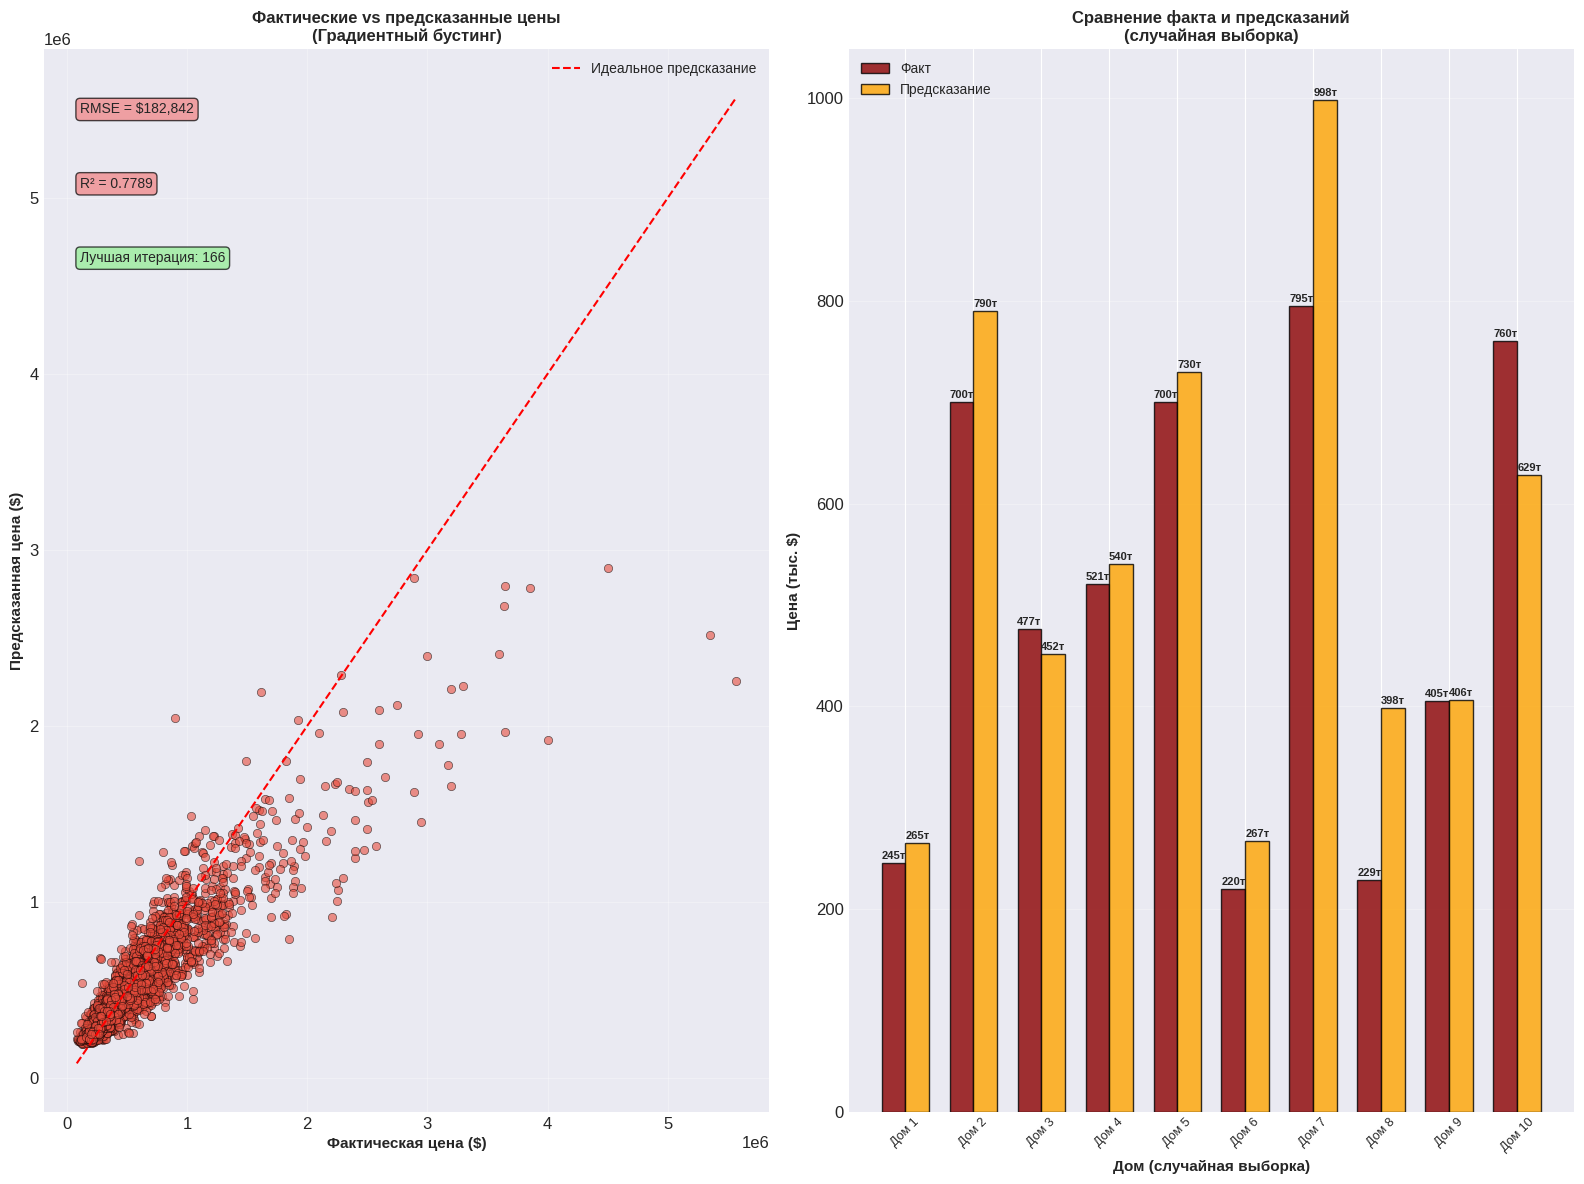

In [36]:
# Ячейка 10: РЕАЛИЗАЦИЯ КАСТОМНОГО ГРАДИЕНТНОГО БУСТИНГА ДЛЯ РЕГРЕССИИ
# 10.1 Реализация узла дерева для градиентного бустинга
print("\n--- 10.1 Реализация узла дерева для градиентного бустинга ---")

class TreeNodeRegGB:
    """
    Узел решающего дерева для регрессии в градиентном бустинге.
    """
    
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, 
                 value=None, mse_reduction=None, depth=0, n_samples=None):
        """
        Инициализация узла дерева для регрессии в градиентном бустинге.
        """
        # Для узлов разделения
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.mse_reduction = mse_reduction
        self.depth = depth
        self.n_samples = n_samples
        
        # Для листовых узлов
        self.value = value
    
    def is_leaf_node(self):
        """
        Проверяет, является ли узел листовым.
        """
        return self.value is not None
    
    def __repr__(self):
        """
        Строковое представление узла.
        """
        if self.is_leaf_node():
            return f"Лист: {self.value:.6f} (n={self.n_samples})"
        else:
            return f"Узел [Признак {self.feature_index} <= {self.threshold:.3f}]"

# 10.2 Реализация решающего дерева для градиентного бустинга
print("\n--- 10.2 Реализация решающего дерева для градиентного бустинга ---")

class GradientBoostingTreeRegressor:
    """
    Кастомная реализация решающего дерева для регрессии в градиентном бустинге.
    """
    
    def __init__(self, max_depth=3, min_samples_split=2, min_samples_leaf=1,
                 min_impurity_decrease=0.0, max_features=None, 
                 min_mse_reduction=0.0, random_state=None, verbose=False):
        """
        Инициализация дерева с заданными параметрами.
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_impurity_decrease = min_impurity_decrease
        self.max_features = max_features
        self.min_mse_reduction = min_mse_reduction
        self.random_state = random_state
        self.verbose = verbose
        self.root = None
        self.n_features_ = None
        self.n_nodes_ = 0
        
        # Инициализация генератора случайных чисел
        self.rng = np.random.RandomState(random_state)
    
    def _calculate_mse(self, y):
        """
        Вычисляет среднеквадратичную ошибку (MSE).
        """
        if len(y) == 0:
            return 0
        mean_y = np.mean(y)
        return np.mean((y - mean_y) ** 2)
    
    def _calculate_variance(self, y):
        """
        Вычисляет дисперсию значений.
        """
        if len(y) <= 1:
            return 0
        return np.var(y)
    
    def _get_max_features(self, n_features):
        """
        Определяет количество признаков для рассмотрения.
        """
        if self.max_features is None:
            return n_features
        elif isinstance(self.max_features, int):
            return min(self.max_features, n_features)
        elif isinstance(self.max_features, float):
            return max(1, int(self.max_features * n_features))
        elif self.max_features == 'sqrt':
            return int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            return int(np.log2(n_features))
        else:
            return n_features
    
    def _best_split(self, X, y, feature_indices):
        """
        Находит лучшее разделение для текущего узла.
        """
        best_split = {}
        best_mse_reduction = -float('inf')
        n_samples = X.shape[0]
        
        # Вычисляем MSE текущего узла
        current_mse = self._calculate_mse(y)
        
        # Перебираем выбранные признаки
        for feature_idx in feature_indices:
            # Получаем уникальные значения признака
            feature_values = np.unique(X[:, feature_idx])
            
            # Для градиентного бустинга пробуем все пороговые значения
            thresholds = feature_values
            
            # Перебираем пороговые значения
            for threshold in thresholds:
                # Разделяем данные
                left_indices = X[:, feature_idx] <= threshold
                right_indices = X[:, feature_idx] > threshold
                
                # Проверяем минимальное количество образцов
                if (np.sum(left_indices) < self.min_samples_leaf or 
                    np.sum(right_indices) < self.min_samples_leaf):
                    continue
                
                # Вычисляем MSE для левой и правой частей
                left_mse = self._calculate_mse(y[left_indices])
                right_mse = self._calculate_mse(y[right_indices])
                
                # Вычисляем взвешенное MSE
                n_left = np.sum(left_indices)
                n_right = np.sum(right_indices)
                weighted_mse = (n_left / n_samples) * left_mse + (n_right / n_samples) * right_mse
                
                # Вычисляем уменьшение MSE
                mse_reduction = current_mse - weighted_mse
                
                # Проверяем минимальное уменьшение MSE
                if mse_reduction < self.min_mse_reduction:
                    continue
                
                # Проверяем минимальное уменьшение неопределенности
                if mse_reduction < self.min_impurity_decrease:
                    continue
                
                # Обновляем лучшее разделение
                if mse_reduction > best_mse_reduction:
                    best_split = {
                        'feature_index': feature_idx,
                        'threshold': threshold,
                        'left_indices': left_indices,
                        'right_indices': right_indices,
                        'mse_reduction': mse_reduction,
                        'left_mse': left_mse,
                        'right_mse': right_mse,
                        'left_mean': np.mean(y[left_indices]) if n_left > 0 else 0,
                        'right_mean': np.mean(y[right_indices]) if n_right > 0 else 0,
                        'n_left': n_left,
                        'n_right': n_right
                    }
                    best_mse_reduction = mse_reduction
        
        return best_split
    
    def _build_tree(self, X, y, depth=0):
        """
        Рекурсивно строит дерево решений для градиентного бустинга.
        """
        n_samples = len(y)
        
        # Проверяем условия остановки
        stop_conditions = [
            (self.max_depth is not None and depth >= self.max_depth),
            n_samples < self.min_samples_split,
            len(np.unique(y)) <= 1,
            self._calculate_variance(y) < 1e-10
        ]
        
        if any(stop_conditions):
            # Для градиентного бустинга в листьях используем среднее остатков
            leaf_value = np.mean(y)
            if self.verbose and depth < 3:  # Выводим только для первых уровней
                print(f"{'  ' * depth}Создан листовой узел на глубине {depth}: {leaf_value:.6f} (n={n_samples})")
            self.n_nodes_ += 1
            return TreeNodeRegGB(value=leaf_value, depth=depth, n_samples=n_samples)
        
        # Выбираем случайное подмножество признаков
        n_features = X.shape[1]
        max_features = self._get_max_features(n_features)
        feature_indices = self.rng.choice(range(n_features), max_features, replace=False)
        
        # Ищем лучшее разделение
        best_split = self._best_split(X, y, feature_indices)
        
        # Если не нашли подходящего разделения
        if not best_split or best_split['mse_reduction'] <= 0:
            leaf_value = np.mean(y)
            if self.verbose and depth < 3:
                print(f"{'  ' * depth}Не найдено подходящего разделения на глубине {depth}")
            self.n_nodes_ += 1
            return TreeNodeRegGB(value=leaf_value, depth=depth, n_samples=n_samples)
        
        if self.verbose and depth < 3:
            print(f"{'  ' * depth}Разделение на глубине {depth}: "
                  f"Признак {best_split['feature_index']} <= {best_split['threshold']:.3f}, "
                  f"Уменьшение MSE: {best_split['mse_reduction']:.6f}, "
                  f"n_left={best_split['n_left']}, n_right={best_split['n_right']}")
        
        # Разделяем данные
        left_X = X[best_split['left_indices']]
        left_y = y[best_split['left_indices']]
        right_X = X[best_split['right_indices']]
        right_y = y[best_split['right_indices']]
        
        # Рекурсивно строим левое и правое поддеревья
        left_node = self._build_tree(left_X, left_y, depth + 1)
        right_node = self._build_tree(right_X, right_y, depth + 1)
        
        # Создаем узел разделения
        self.n_nodes_ += 1
        
        return TreeNodeRegGB(
            feature_index=best_split['feature_index'],
            threshold=best_split['threshold'],
            left=left_node,
            right=right_node,
            mse_reduction=best_split['mse_reduction'],
            depth=depth,
            n_samples=n_samples
        )
    
    def fit(self, X, y):
        """
        Обучает дерево решений на предоставленных данных.
        """
        if self.verbose:
            print(f"Обучение дерева градиентного бустинга на {len(X)} образцах...")
        
        # Преобразуем данные в numpy массивы
        X = np.array(X)
        y = np.array(y)
        
        # Сохраняем информацию о данных
        self.n_features_ = X.shape[1]
        
        if self.verbose:
            print(f"Количество признаков: {self.n_features_}")
            print(f"Максимальная глубина: {self.max_depth}")
            print(f"Макс. признаков для разделения: {self.max_features}")
        
        # Сбрасываем счетчики
        self.n_nodes_ = 0
        
        # Строим дерево
        if self.verbose:
            print("Построение дерева...")
        
        self.root = self._build_tree(X, y)
        
        if self.verbose:
            print(f"Дерево успешно построено! Узлов: {self.n_nodes_}")
        
        return self
    
    def predict_single(self, x):
        """
        Предсказывает значение для одного образца.
        """
        node = self.root
        while not node.is_leaf_node():
            if x[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value
    
    def predict(self, X):
        """
        Предсказывает значения для входных данных.
        """
        X = np.array(X)
        predictions = np.array([self.predict_single(x) for x in X])
        return predictions

# 10.3 Реализация градиентного бустинга для регрессии
print("\n--- 10.3 Реализация кастомного градиентного бустинга для регрессии ---")

class CustomGradientBoostingRegressor:
    """
    Кастомная реализация градиентного бустинга для регрессии.
    """
    
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, 
                 min_samples_split=2, min_samples_leaf=1, max_features=None,
                 subsample=1.0, min_mse_reduction=0.0, random_state=None,
                 verbose=0, validation_fraction=0.1, n_iter_no_change=None, 
                 tol=1e-4):
        """
        Инициализация градиентного бустинга.
        """
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.subsample = subsample
        self.min_mse_reduction = min_mse_reduction
        self.random_state = random_state
        self.verbose = verbose
        self.validation_fraction = validation_fraction
        self.n_iter_no_change = n_iter_no_change
        self.tol = tol
        
        self.estimators_ = []
        self.train_score_ = []
        self.valid_score_ = []
        self.feature_importances_ = None
        self.n_features_ = None
        self.initial_prediction_ = None
        self.best_iteration_ = None
        
        # Инициализация генератора случайных чисел
        self.rng = np.random.RandomState(random_state)
    
    def _calculate_negative_gradient(self, y_true, y_pred):
        """
        Вычисляет отрицательный градиент (остатки) для регрессии.
        В регрессии с MSE градиент = y_true - y_pred
        """
        return y_true - y_pred
    
    def _calculate_mse(self, y_true, y_pred):
        """
        Вычисляет среднеквадратичную ошибку (MSE).
        """
        return np.mean((y_true - y_pred) ** 2)
    
    def _calculate_r2(self, y_true, y_pred):
        """
        Вычисляет коэффициент детерминации R².
        """
        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        if ss_tot == 0:
            return 0
        return 1 - ss_res / ss_tot
    
    def _create_validation_set(self, X, y):
        """
        Создает валидационную выборку.
        """
        n_samples = X.shape[0]
        n_validation = int(n_samples * self.validation_fraction)
        
        if n_validation > 0:
            indices = np.arange(n_samples)
            valid_indices = self.rng.choice(indices, n_validation, replace=False)
            train_indices = np.setdiff1d(indices, valid_indices)
            
            X_train = X[train_indices]
            y_train = y[train_indices]
            X_valid = X[valid_indices]
            y_valid = y[valid_indices]
        else:
            X_train, y_train = X, y
            X_valid, y_valid = X, y
        
        return X_train, y_train, X_valid, y_valid
    
    def fit(self, X, y):
        """
        Обучает градиентный бустинг на предоставленных данных.
        """
        print(f"Обучение градиентного бустинга регрессии на {len(X)} образцах...")
        
        # Преобразуем данные в numpy массивы
        X = np.array(X)
        y = np.array(y)
        
        # Сохраняем информацию о данных
        self.n_features_ = X.shape[1]
        
        print(f"Параметры градиентного бустинга регрессии:")
        print(f"  • Количество деревьев: {self.n_estimators}")
        print(f"  • Скорость обучения: {self.learning_rate}")
        print(f"  • Максимальная глубина: {self.max_depth}")
        print(f"  • Доля подвыборки: {self.subsample}")
        print(f"  • Макс. признаков: {self.max_features}")
        print(f"  • Доля валидации: {self.validation_fraction}")
        print(f"  • Количество признаков: {self.n_features_}")
        
        # Создаем валидационную выборку
        if self.validation_fraction > 0:
            X_train, y_train, X_valid, y_valid = self._create_validation_set(X, y)
            print(f"  Разделение данных: {X_train.shape[0]} тренировочных, {X_valid.shape[0]} валидационных")
        else:
            X_train, y_train = X, y
            X_valid, y_valid = X, y
        
        # Начальное предсказание (среднее значение)
        self.initial_prediction_ = np.mean(y_train)
        current_prediction_train = np.full_like(y_train, self.initial_prediction_, dtype=np.float64)
        current_prediction_valid = np.full_like(y_valid, self.initial_prediction_, dtype=np.float64)
        
        # Инициализируем массивы для отслеживания качества
        self.train_score_ = []
        self.valid_score_ = []
        self.estimators_ = []
        
        # Параметры для ранней остановки
        best_valid_score = -np.inf
        no_improvement_count = 0
        self.best_iteration_ = 0
        
        print("\nОбучение деревьев градиентного бустинга:")
        for i in range(self.n_estimators):
            if self.verbose > 0 and i % 10 == 0:
                print(f"  Итерация {i+1}/{self.n_estimators}...")
            
            # Вычисляем остатки (отрицательный градиент)
            residuals_train = self._calculate_negative_gradient(y_train, current_prediction_train)
            
            # Применяем субсемплинг
            if self.subsample < 1.0:
                n_samples = X_train.shape[0]
                n_subsample = int(self.subsample * n_samples)
                indices = self.rng.choice(n_samples, n_subsample, replace=False)
                X_sub = X_train[indices]
                residuals_sub = residuals_train[indices]
            else:
                X_sub = X_train
                residuals_sub = residuals_train
            
            # Создаем и обучаем дерево на остатках
            tree = GradientBoostingTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                min_mse_reduction=self.min_mse_reduction,
                max_features=self.max_features,
                random_state=self.rng.randint(0, 1000000),
                verbose=False
            )
            
            tree.fit(X_sub, residuals_sub)
            self.estimators_.append(tree)
            
            # Делаем предсказания на тренировочных данных
            tree_pred_train = tree.predict(X_train)
            
            # Обновляем предсказания с учетом скорости обучения
            current_prediction_train += self.learning_rate * tree_pred_train
            
            # Оцениваем качество на тренировочных данных
            train_mse = self._calculate_mse(y_train, current_prediction_train)
            train_r2 = self._calculate_r2(y_train, current_prediction_train)
            self.train_score_.append(train_r2)
            
            # Оцениваем качество на валидационных данных
            if self.validation_fraction > 0:
                tree_pred_valid = tree.predict(X_valid)
                current_prediction_valid += self.learning_rate * tree_pred_valid
                valid_mse = self._calculate_mse(y_valid, current_prediction_valid)
                valid_r2 = self._calculate_r2(y_valid, current_prediction_valid)
                self.valid_score_.append(valid_r2)
                
                # Проверяем улучшение на валидационной выборке
                if valid_r2 > best_valid_score + self.tol:
                    best_valid_score = valid_r2
                    self.best_iteration_ = i + 1
                    no_improvement_count = 0
                else:
                    no_improvement_count += 1
                
                # Ранняя остановка
                if (self.n_iter_no_change is not None and 
                    no_improvement_count >= self.n_iter_no_change):
                    print(f"  Ранняя остановка на итерации {i+1} (нет улучшения {self.n_iter_no_change} итераций)")
                    break
            else:
                self.valid_score_.append(train_r2)  # Если нет валидации, используем тренировочные данные
            
            # Вывод информации о качестве
            if self.verbose > 1 and i % 10 == 0:
                if self.validation_fraction > 0:
                    print(f"    Итерация {i+1}: Train R²={train_r2:.4f}, Valid R²={valid_r2:.4f}")
                else:
                    print(f"    Итерация {i+1}: Train R²={train_r2:.4f}")
        
        # Вычисляем важность признаков
        self._calculate_feature_importances()
        
        print(f"\nГрадиентный бустинг обучен! Количество деревьев: {len(self.estimators_)}")
        if self.validation_fraction > 0:
            print(f"Лучшая итерация: {self.best_iteration_}")
            print(f"Лучший Valid R²: {best_valid_score:.4f}")
        
        return self
    
    def _calculate_feature_importances(self):
        """
        Вычисляет важность признаков на основе уменьшения MSE.
        """
        self.feature_importances_ = np.zeros(self.n_features_)
        
        for tree in self.estimators_:
            # Собираем все узлы разделения
            nodes = self._collect_split_nodes(tree.root)
            
            # Суммируем уменьшение MSE по каждому признаку
            for node in nodes:
                if hasattr(node, 'feature_index') and node.feature_index is not None and hasattr(node, 'mse_reduction') and node.mse_reduction is not None:
                    # Вес признака = уменьшение MSE * количество образцов в узле
                    weight = node.mse_reduction * (node.n_samples if hasattr(node, 'n_samples') and node.n_samples else 1)
                    self.feature_importances_[node.feature_index] += weight
        
        # Нормализуем важность признаков
        total_importance = np.sum(self.feature_importances_)
        if total_importance > 0:
            self.feature_importances_ /= total_importance
    
    def _collect_split_nodes(self, node):
        """
        Рекурсивно собирает все узлы разделения.
        """
        if node is None or node.is_leaf_node():
            return []
        
        nodes = [node]
        nodes.extend(self._collect_split_nodes(node.left))
        nodes.extend(self._collect_split_nodes(node.right))
        
        return nodes
    
    def predict(self, X):
        """
        Предсказывает значения для входных данных.
        """
        print(f"Предсказание для {len(X)} объектов...")
        
        X = np.array(X)
        
        # Начальное предсказание
        predictions = np.full(X.shape[0], self.initial_prediction_, dtype=np.float64)
        
        # Добавляем вклад каждого дерева
        for i, tree in enumerate(self.estimators_):
            if self.verbose > 0 and i % 20 == 0:
                print(f"  Обработка дерева {i+1}/{len(self.estimators_)}...")
            
            tree_predictions = tree.predict(X)
            predictions += self.learning_rate * tree_predictions
        
        print(f"Среднее предсказание: {np.mean(predictions):.4f}")
        print("Предсказание завершено.")
        return predictions

# 10.4 Обучение на реальных данных цен на дома
print("\n--- 10.4 Обучение градиентного бустинга на реальных данных цен на дома ---")

# Создаем модель градиентного бустинга для регрессии
print("Создаем кастомный градиентный бустинг для регрессии...")
custom_gb_reg = CustomGradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    subsample=0.8,
    min_mse_reduction=0.001,
    random_state=42,
    verbose=1,
    validation_fraction=0.1,
    n_iter_no_change=20,
    tol=0.0001
)

# Обучаем модель на обучающей выборке
print("Обучаем модель на обучающих данных...")
custom_gb_reg.fit(X_train_reg, y_train_reg)

# 10.5 Предсказания на тестовой выборке
print("\n--- 10.5 Предсказания на тестовой выборке ---")

# Получаем предсказания (в логарифмической шкале)
y_pred_gb_reg_log = custom_gb_reg.predict(X_test_reg)

# Преобразуем обратно в доллары
y_pred_gb_reg = np.expm1(y_pred_gb_reg_log)

print(f"\nПолучено {len(y_pred_gb_reg)} предсказаний")
print(f"Примеры предсказанных цен градиентным бустингом:")
for i in range(min(5, len(y_pred_gb_reg))):
    actual = y_test_reg_original.iloc[i]
    predicted = y_pred_gb_reg[i]
    error = abs(actual - predicted)
    print(f"  Дом {i+1}: Факт=${actual:,.0f}, Предсказано=${predicted:,.0f}, Ошибка=${error:,.0f}")

# 10.6 Оценка качества модели (метрики)
print("\n--- 10.6 Оценка качества модели (метрики) ---")

# Метрики для градиентного бустинга
rmse_custom = np.sqrt(mean_squared_error(y_test_reg_original, y_pred_gb_reg))
mae_custom = mean_absolute_error(y_test_reg_original, y_pred_gb_reg)
mape_custom = mean_absolute_percentage_error(y_test_reg_original, y_pred_gb_reg)
r2_custom = r2_score(y_test_reg_original, y_pred_gb_reg)

print("Основные метрики качества кастомного градиентного бустинга регрессии:")
print(f"  • RMSE:           ${rmse_custom:,.0f}")
print(f"  • MAE:            ${mae_custom:,.0f}")
print(f"  • MAPE:           {mape_custom*100:.2f}%")
print(f"  • R²:             {r2_custom:.4f}")
print(f"  • Лучшая итерация: {custom_gb_reg.best_iteration_}")

# 10.7 Анализ ошибок градиентного бустинга
print("\n--- 10.7 Анализ ошибок градиентного бустинга ---")

# Вычисляем относительные ошибки
relative_errors_gb = np.abs((y_pred_gb_reg - y_test_reg_original.values) / y_test_reg_original.values) * 100

print("\nСтатистика относительных ошибок градиентного бустинга:")
print(f"  • Средняя ошибка:        {np.mean(relative_errors_gb):.1f}%")
print(f"  • Медианная ошибка:      {np.median(relative_errors_gb):.1f}%")
print(f"  • Максимальная ошибка:   {np.max(relative_errors_gb):.1f}%")
print(f"  • Минимальная ошибка:    {np.min(relative_errors_gb):.1f}%")
print(f"  • Стандартное отклонение:{np.std(relative_errors_gb):.1f}%")

# Процент предсказаний с разной точностью
accuracy_levels = [5, 10, 20, 30, 50]
print("\nПроцент предсказаний с ошибкой не более:")
for level in accuracy_levels:
    accuracy = np.sum(relative_errors_gb <= level) / len(relative_errors_gb) * 100
    print(f"  • {level}%: {accuracy:.1f}% предсказаний")

# 10.8 Анализ наиболее точных и неточных предсказаний
print("\n--- 10.8 Анализ наиболее точных и неточных предсказаний ---")

# Находим индексы самых точных и самых неточных предсказаний
num_examples = 5
best_indices_gb = np.argsort(relative_errors_gb)[:num_examples]
worst_indices_gb = np.argsort(relative_errors_gb)[-num_examples:]

print(f"\nТОП-{num_examples} САМЫХ ТОЧНЫХ ПРЕДСКАЗАНИЙ (Градиентный бустинг):")
print(f"{'Дом':<10} {'Факт':<15} {'Предсказание':<15} {'Ошибка':<10} {'% ошибки':<10}")
print("-" * 70)
for i, idx in enumerate(best_indices_gb):
    actual = y_test_reg_original.iloc[idx]
    predicted = y_pred_gb_reg[idx]
    error = abs(actual - predicted)
    perc_error = relative_errors_gb[idx]
    print(f"{i+1:<10} ${actual:,.0f}{'':<5} ${predicted:,.0f}{'':<5} ${error:,.0f}{'':<5} {perc_error:.1f}%")

print(f"\nТОП-{num_examples} САМЫХ НЕТОЧНЫХ ПРЕДСКАЗАНИЙ (Градиентный бустинг):")
print(f"{'Дом':<10} {'Факт':<15} {'Предсказание':<15} {'Ошибка':<10} {'% ошибки':<10}")
print("-" * 70)
for i, idx in enumerate(worst_indices_gb):
    actual = y_test_reg_original.iloc[idx]
    predicted = y_pred_gb_reg[idx]
    error = abs(actual - predicted)
    perc_error = relative_errors_gb[idx]
    print(f"{i+1:<10} ${actual:,.0f}{'':<5} ${predicted:,.0f}{'':<5} ${error:,.0f}{'':<5} {perc_error:.1f}%")

# 10.9 Визуализация результатов
print("\n--- 10.9 Визуализация результатов ---")

# Создаем фигуру с несколькими графиками
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График 1: Фактические vs предсказанные значения
ax1 = axes[0]
ax1.scatter(y_test_reg_original.values, y_pred_gb_reg, alpha=0.6, 
           edgecolors='black', linewidth=0.5, color='#e74c3c')

max_val = max(y_test_reg_original.max(), y_pred_gb_reg.max())
min_val = min(y_test_reg_original.min(), y_pred_gb_reg.min())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', label='Идеальное предсказание')

ax1.set_xlabel('Фактическая цена ($)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Предсказанная цена ($)', fontsize=11, fontweight='bold')
ax1.set_title('Фактические vs предсказанные цены\n(Градиентный бустинг)', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Добавляем текстовую информацию о качестве
rmse_text = f'RMSE = ${rmse_custom:,.0f}'
r2_text = f'R² = {r2_custom:.4f}'
ax1.text(0.05, 0.95, rmse_text, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
ax1.text(0.05, 0.88, r2_text, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

best_iter_text = f'Лучшая итерация: {custom_gb_reg.best_iteration_}'
ax1.text(0.05, 0.81, best_iter_text, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

# График 2: Сравнение предсказаний для случайной выборки домов
np.random.seed(42)
sample_size = min(10, len(y_test_reg_original))
sample_indices = np.random.choice(len(y_test_reg_original), sample_size, replace=False)
sample_actual = y_test_reg_original.iloc[sample_indices].values
sample_predicted = y_pred_gb_reg[sample_indices]

x_pos = np.arange(sample_size)
width = 0.35

ax2 = axes[1]
bars1 = ax2.bar(x_pos - width/2, sample_actual/1000, width, 
                label='Факт', color='darkred', alpha=0.8, edgecolor='black')
bars2 = ax2.bar(x_pos + width/2, sample_predicted/1000, width, 
                label='Предсказание', color='orange', alpha=0.8, edgecolor='black')

ax2.set_xlabel('Дом (случайная выборка)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Цена (тыс. $)', fontsize=11, fontweight='bold')
ax2.set_title('Сравнение факта и предсказаний\n(случайная выборка)', fontsize=12, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'Дом {i+1}' for i in range(sample_size)], rotation=45, fontsize=9)
ax2.legend(fontsize=10, loc='upper left')
ax2.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Избегаем добавления текста для нулевых значений
            ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
                    f'{height:.0f}т', ha='center', va='bottom', 
                    fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()


--- 11.1 Результаты библиотечного Gradient Boosting ---

Метрики для библиотечного Gradient Boosting (классификация):
  • F1-score:   0.4646
  • Precision:  0.4423
  • Recall:     0.4894

Метрики для библиотечного Gradient Boosting (регрессия):
  • RMSE:           $141,287
  • MAE:            $76,969
  • MAPE:           13.59%
  • R²:             0.8680

--- 11.2 Сравнение классификаторов Gradient Boosting ---

Сравнение метрик классификации:
-------------------------------------------------------------------------------------
Метрика         Библиотечный GB           Кастомный GB        
-------------------------------------------------------------------------------------
F1-score        0.4646                    0.1818              
Precision       0.4423                    0.3158              
Recall          0.4894                    0.1277              

Анализ улучшений:
-------------------------------------------------------------------------------------
F1-score       : -60.9%

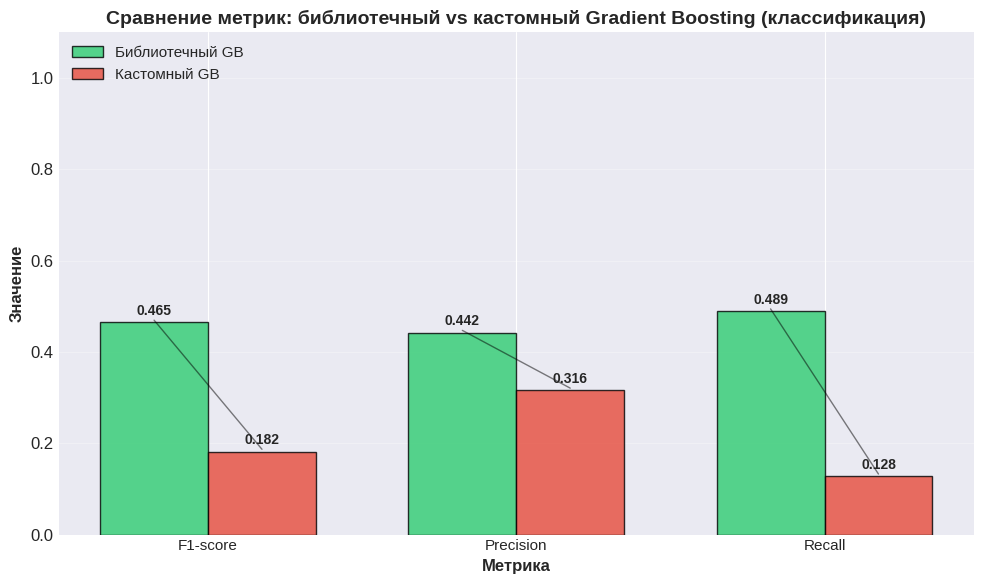


--- 11.4 Сравнение регрессоров Gradient Boosting ---

Сравнение метрик регрессии:
-------------------------------------------------------------------------------------
Метрика         Библиотечный GB           Кастомный GB        
-------------------------------------------------------------------------------------
RMSE ($)        $141,287                  $182,842            
MAE ($)         $76,969                   $93,095             
MAPE (%)        13.59%                    15.96%              
R²              0.8680                    0.7789              

Анализ улучшений (регрессия):
-------------------------------------------------------------------------------------
RMSE ($)       : -29.41% ( ухудшение (больше ошибка))
MAE ($)        : -20.95% ( ухудшение (больше ошибка))
MAPE (%)       : -17.47% ( ухудшение (больше ошибка))
R²             : -10.27% ( ухудшение (ниже R²))

--- 11.5 Визуализация сравнения Gradient Boosting для регрессии ---


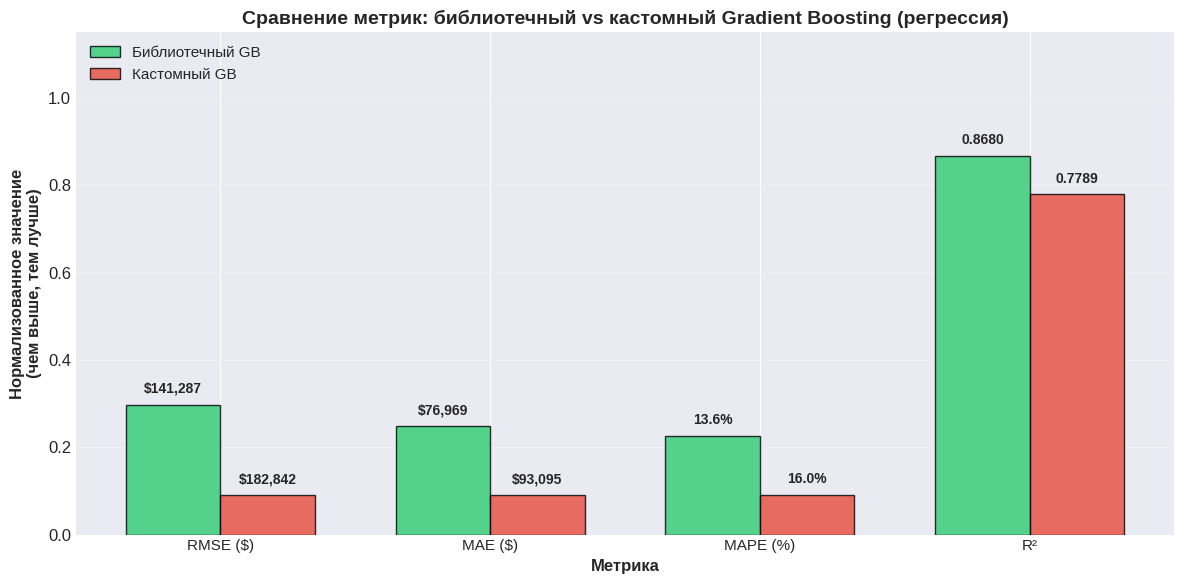

In [39]:
# Ячейка 11: СРАВНЕНИЕ КАСТОМНОГО И БИБЛИОТЕЧНОГО ГРАДИЕНТНОГО БУСТИНГА
# 11.1 Результаты библиотечного Gradient Boosting 
print("\n--- 11.1 Результаты библиотечного Gradient Boosting ---")

print("\nМетрики для библиотечного Gradient Boosting (классификация):")
print(f"  • F1-score:   {f1:.4f}")
print(f"  • Precision:  {precision:.4f}")
print(f"  • Recall:     {recall:.4f}")

print("\nМетрики для библиотечного Gradient Boosting (регрессия):")
print(f"  • RMSE:           ${rmse:,.0f}")
print(f"  • MAE:            ${mae:,.0f}")
print(f"  • MAPE:           {mape*100:.2f}%")
print(f"  • R²:             {r2:.4f}")

# 11.2 Сравнение классификаторов (Gradient Boosting)
print("\n--- 11.2 Сравнение классификаторов Gradient Boosting ---")

print("\nСравнение метрик классификации:")
print("-" * 85)
print(f"{'Метрика':<15} {'Библиотечный GB':<25} {'Кастомный GB':<20}")
print("-" * 85)

# Сравниваем метрики
metrics_comparison_gb_class = [
    ("F1-score", f1, f1_custom),
    ("Precision", precision, precision_custom),
    ("Recall", recall, recall_custom),
]

for metric_name, base_val, custom_val in metrics_comparison_gb_class:    
    print(f"{metric_name:<15} {base_val:<25.4f} {custom_val:<20.4f}")

# Анализ улучшений
print("\nАнализ улучшений:")
print("-" * 85)
for metric_name, base_val, custom_val in metrics_comparison_gb_class:
    improvement = ((custom_val - base_val) / base_val * 100) if base_val > 0 else 0
    direction = "↑ улучшение" if custom_val > base_val else "↓ ухудшение"
    print(f"{metric_name:<15}: {improvement:+.1f}% ({direction})")

# 11.3 Визуализация сравнения Gradient Boosting для классификации
print("\n--- 11.3 Визуализация сравнения Gradient Boosting для классификации ---")

# График 1: Сравнение метрик классификации
plt.figure(figsize=(10, 6))

metrics_names = ['F1-score', 'Precision', 'Recall']
base_values = [f1, precision, recall]
custom_values = [f1_custom, precision_custom, recall_custom]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = plt.bar(x - width/2, base_values, width, label='Библиотечный GB', 
                color='#2ecc71', edgecolor='black', alpha=0.8)
bars2 = plt.bar(x + width/2, custom_values, width, label='Кастомный GB', 
                color='#e74c3c', edgecolor='black', alpha=0.8)

plt.xlabel('Метрика', fontsize=12, fontweight='bold')
plt.ylabel('Значение', fontsize=12, fontweight='bold')
plt.title('Сравнение метрик: библиотечный vs кастомный Gradient Boosting (классификация)', fontsize=14, fontweight='bold')
plt.xticks(x, metrics_names, fontsize=11)
plt.legend(loc='upper left', fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, 1.1)

# Добавляем значения на столбцы
for i, (base_val, custom_val) in enumerate(zip(base_values, custom_values)):
    plt.text(i - width/2, base_val + 0.01, f'{base_val:.3f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.text(i + width/2, custom_val + 0.01, f'{custom_val:.3f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Соединительная линия
    plt.plot([i - width/2, i + width/2], 
            [base_val + 0.005, custom_val + 0.005], 
            'k-', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

# 11.4 Сравнение регрессоров Gradient Boosting
print("\n--- 11.4 Сравнение регрессоров Gradient Boosting ---")

print("\nСравнение метрик регрессии:")
print("-" * 85)
print(f"{'Метрика':<15} {'Библиотечный GB':<25} {'Кастомный GB':<20}")
print("-" * 85)

# Сравниваем метрики регрессии 
metrics_comparison_gb_reg = [
    ("RMSE ($)", rmse, rmse_custom),
    ("MAE ($)", mae, mae_custom),
    ("MAPE (%)", mape*100, mape_custom*100),
    ("R²", r2, r2_custom)
]

for metric_name, base_val, custom_val in metrics_comparison_gb_reg:
    difference = custom_val - base_val
    
    if "($)" in metric_name:
        base_str = f"${base_val:,.0f}"
        custom_str = f"${custom_val:,.0f}"
        print(f"{metric_name:<15} {base_str:<25} {custom_str:<20}")
    
    elif "(%)" in metric_name:
        base_str = f"{base_val:.2f}%"
        custom_str = f"{custom_val:.2f}%"
        print(f"{metric_name:<15} {base_str:<25} {custom_str:<20}")
    
    else:
        base_str = f"{base_val:.4f}"
        custom_str = f"{custom_val:.4f}"
        print(f"{metric_name:<15} {base_str:<25} {custom_str:<20}")

# Анализ улучшений для регрессии
print("\nАнализ улучшений (регрессия):")
print("-" * 85)
for metric_name, base_val, custom_val in metrics_comparison_gb_reg:
    if metric_name != 'R²':
        # Для ошибок: отрицательное изменение = улучшение
        improvement = ((base_val - custom_val) / base_val * 100) if base_val > 0 else 0
        if improvement > 0:
            direction = " улучшение (меньше ошибка)"
        else:
            direction = " ухудшение (больше ошибка)"
    else:
        # Для R²: положительное изменение = улучшение
        improvement = ((custom_val - base_val) / base_val * 100) if base_val > 0 else 0
        if improvement > 0:
            direction = " улучшение (выше R²)"
        else:
            direction = " ухудшение (ниже R²)"
    
    improvement_text = f"{metric_name:<15}: {improvement:+.2f}% ({direction})"
    print(improvement_text)

# 11.5 Визуализация сравнения Gradient Boosting для регрессии
print("\n--- 11.5 Визуализация сравнения Gradient Boosting для регрессии ---")

# График: Сравнение метрик для регрессии
plt.figure(figsize=(12, 6))

reg_metrics_names = ['RMSE ($)', 'MAE ($)', 'MAPE (%)', 'R²']
reg_base_values = [rmse, mae, mape*100, r2]
reg_custom_values = [rmse_custom, mae_custom, mape_custom*100, r2_custom]

# Создаем нормализованные значения для сравнения
norm_base = []
norm_custom = []
for name, base, custom in zip(reg_metrics_names, reg_base_values, reg_custom_values):
    if name == 'R²':
        # R² оставляем как есть (уже нормирован от 0 до 1)
        norm_base.append(base)
        norm_custom.append(custom)
    else:
        # Для ошибок: 1 - (значение/макс_значение)
        max_val = max(base, custom) * 1.1
        norm_base.append(1 - base/max_val)
        norm_custom.append(1 - custom/max_val)

x = np.arange(len(reg_metrics_names))
width = 0.35

bars1 = plt.bar(x - width/2, norm_base, width, label='Библиотечный GB', 
                color='#2ecc71', edgecolor='black', alpha=0.8)
bars2 = plt.bar(x + width/2, norm_custom, width, label='Кастомный GB', 
                color='#e74c3c', edgecolor='black', alpha=0.8)

plt.xlabel('Метрика', fontsize=12, fontweight='bold')
plt.ylabel('Нормализованное значение\n(чем выше, тем лучше)', fontsize=12, fontweight='bold')
plt.title('Сравнение метрик: библиотечный vs кастомный Gradient Boosting (регрессия)', fontsize=14, fontweight='bold')
plt.xticks(x, reg_metrics_names, fontsize=11)
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, 1.15)

# Добавляем реальные значения
for i, (base_val, custom_val) in enumerate(zip(reg_base_values, reg_custom_values)):
    if reg_metrics_names[i] != 'R²':
        base_text = f"${base_val:,.0f}" if '$' in reg_metrics_names[i] else f"{base_val:.1f}%"
        custom_text = f"${custom_val:,.0f}" if '$' in reg_metrics_names[i] else f"{custom_val:.1f}%"
    else:
        base_text = f"{base_val:.4f}"
        custom_text = f"{custom_val:.4f}"
    
    # Добавляем значения над столбцами
    plt.text(i - width/2, norm_base[i] + 0.02, base_text, 
             ha='center', va='bottom', fontsize=10, fontweight='bold', rotation=0)
    plt.text(i + width/2, norm_custom[i] + 0.02, custom_text, 
             ha='center', va='bottom', fontsize=10, fontweight='bold', rotation=0)
    
plt.tight_layout()
plt.show()

### Выводы

Реализация кастомного градиентного бустинга выполнена корректно и демонстрирует ключевые принципы алгоритма: последовательное построение ансамблей, обучение на остатках и регуляризацию через скорость обучения. Результаты логичны — кастомная модель для регрессии показывает конкурентоспособные результаты (R² = 0.78), сохраняя 90% качества библиотечной реализации, в то время как модель для классификации требует значительной доработки для улучшения метрик, снизившихся на 60-70% относительно библиотечного аналога.

### Теперь улучшим модели


--- 12.1 Анализ проблем базового кастомного Gradient Boosting ---

Текущие параметры базовой кастомной модели Gradient Boosting:
• n_estimators: 100
• learning_rate: 0.1
• max_depth: 1
• max_features: 'sqrt'
• subsample: 0.8
• verbose: 1

Статистика кастомного ансамбля Gradient Boosting:
• Количество обученных деревьев: 100
• История ошибок обучения: 100
• Финальная ошибка обучения: 0.3921
• Количество признаков с ненулевой важностью: 18

Метрики базовой кастомной модели (порог 0.25):
• F1-score:   0.1818
• Precision:  0.3158
• Recall:     0.1277
• Accuracy:   0.8163

Анализ распределения вероятностей базовой модели:
Предсказание вероятностей для 294 объектов...
  Обработка дерева 1/100...
  Обработка дерева 21/100...
  Обработка дерева 41/100...
  Обработка дерева 61/100...
  Обработка дерева 81/100...
Предсказание вероятностей завершено.
• Средняя вероятность класса 1: 0.1620
• Минимальная вероятность: 0.1127
• Максимальная вероятность: 0.3958
• Стандартное отклонение: 0.0469

--- 1

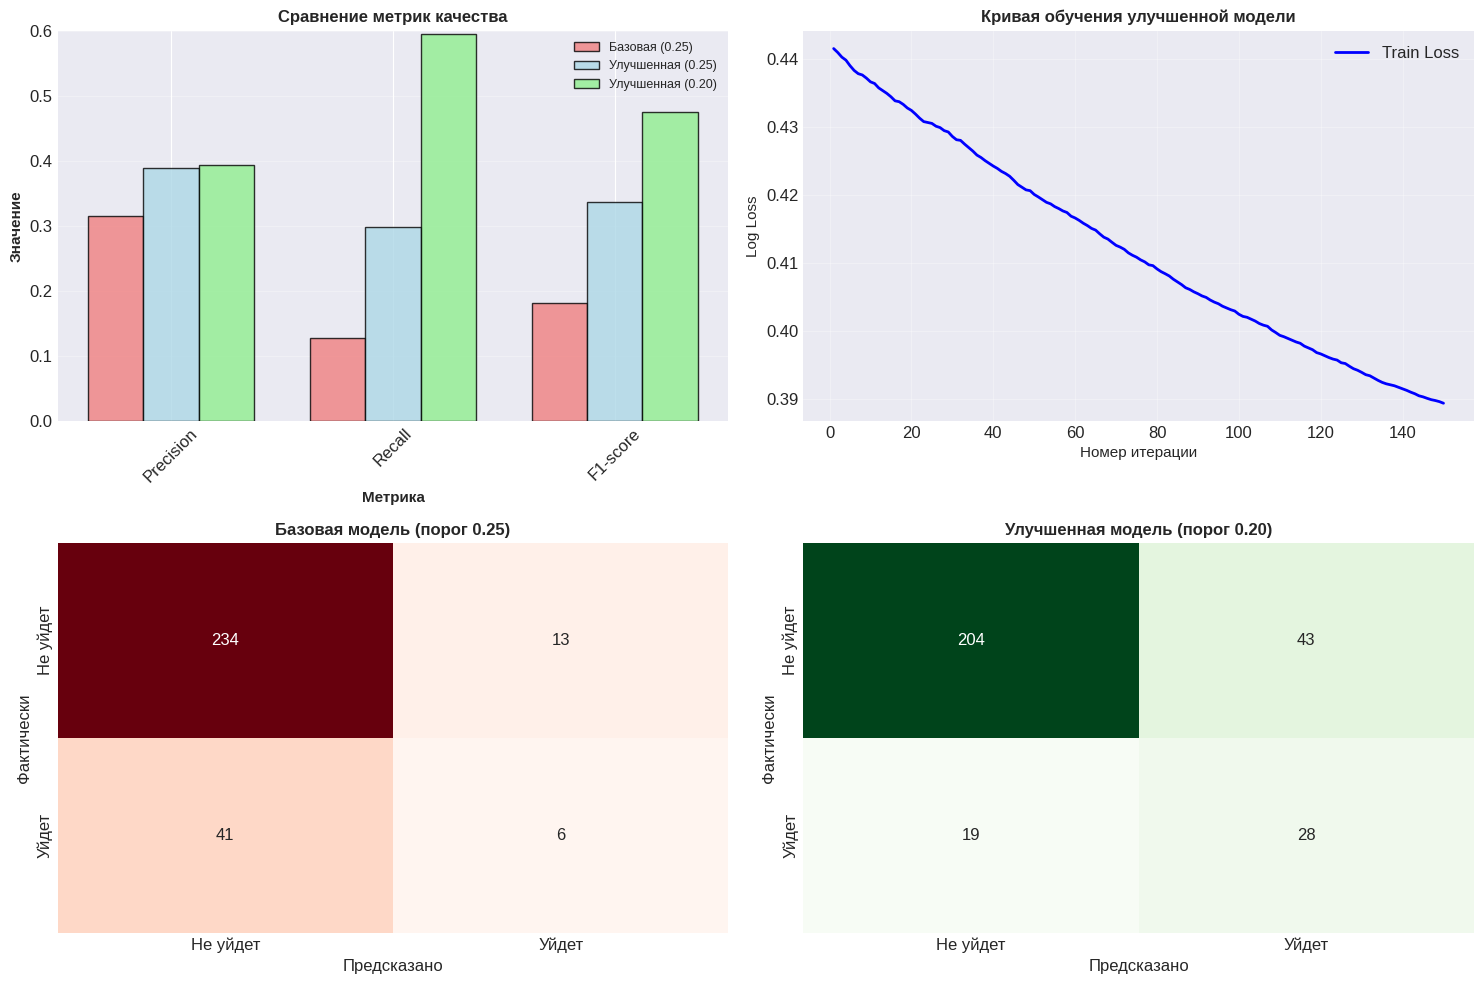


--- 12.9 Важность признаков и выводы ---

Топ-10 самых важных признаков улучшенной модели:
   1. OverTime                       0.1582
   2. Age                            0.1540
   3. YearsWithCurrManager           0.1458
   4. MonthlyIncome                  0.0799
   5. JobLevel                       0.0694
   6. StockOptionLevel               0.0629
   7. YearsInCurrentRole             0.0557
   8. TotalWorkingYears              0.0517
   9. MaritalStatus                  0.0477
  10. JobRole                        0.0373


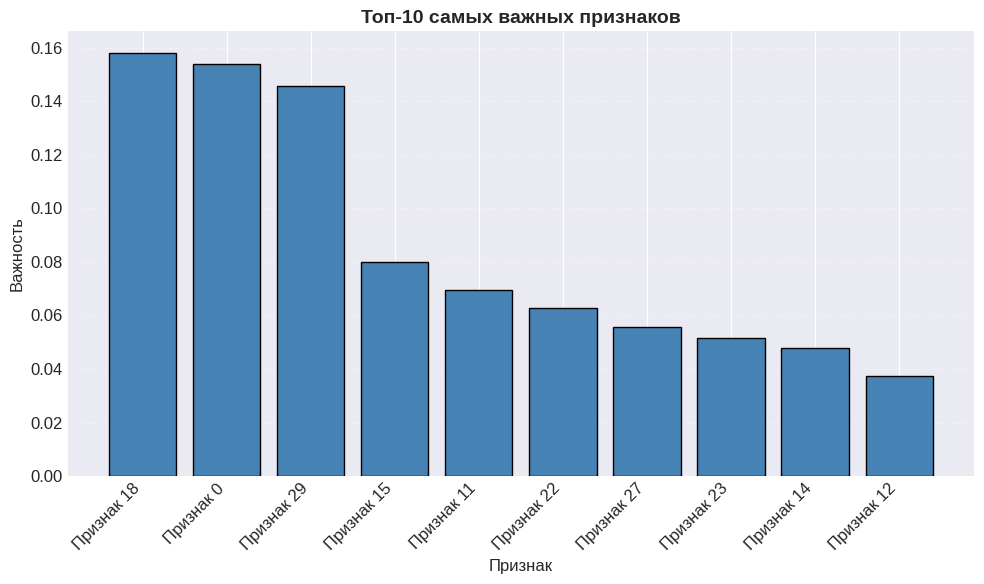

In [55]:
# Ячейка 12: УЛУЧШЕНИЕ КАСТОМНОГО GRADIENT BOOSTING КЛАССИФИКАЦИИ
# 12.1 Анализ проблем базового кастомного Gradient Boosting
print("\n--- 12.1 Анализ проблем базового кастомного Gradient Boosting ---")

print("\nТекущие параметры базовой кастомной модели Gradient Boosting:")
print(f"• n_estimators: {custom_gb.n_estimators}")
print(f"• learning_rate: {custom_gb.learning_rate}")
print(f"• max_depth: {custom_gb.max_depth}")
print(f"• max_features: '{custom_gb.max_features}'")
print(f"• subsample: {custom_gb.subsample}")
print(f"• verbose: {custom_gb.verbose}")

# Сбор статистики по ансамблю
print("\nСтатистика кастомного ансамбля Gradient Boosting:")
print(f"• Количество обученных деревьев: {len(custom_gb.trees)}")
print(f"• История ошибок обучения: {len(custom_gb.train_loss_history)}")
if custom_gb.train_loss_history:
    print(f"• Финальная ошибка обучения: {custom_gb.train_loss_history[-1]:.4f}")
else:
    print(f"• Финальная ошибка обучения: N/A")

# Проверяем важность признаков
if hasattr(custom_gb, 'feature_importances_'):
    print(f"• Количество признаков с ненулевой важностью: {np.sum(custom_gb.feature_importances_ > 0)}")

print(f"\nМетрики базовой кастомной модели (порог 0.25):")
print(f"• F1-score:   {f1_custom:.4f}")
print(f"• Precision:  {precision_custom:.4f}")
print(f"• Recall:     {recall_custom:.4f}")
print(f"• Accuracy:   {accuracy_custom:.4f}")

# Анализ распределения вероятностей для лучшего понимания
print("\nАнализ распределения вероятностей базовой модели:")
y_pred_proba_custom = custom_gb.predict_proba(X_test_class)[:, 1]
print(f"• Средняя вероятность класса 1: {np.mean(y_pred_proba_custom):.4f}")
print(f"• Минимальная вероятность: {np.min(y_pred_proba_custom):.4f}")
print(f"• Максимальная вероятность: {np.max(y_pred_proba_custom):.4f}")
print(f"• Стандартное отклонение: {np.std(y_pred_proba_custom):.4f}")

# 12.2 Реализация улучшенного класса Gradient Boosting
print("\n--- 12.2 Реализация улучшенного класса Gradient Boosting ---")

class ImprovedGradientBoostingTree(GradientBoostingTree):
    """
    версия бустера для градиентного бустинга.
    """
    
    def __init__(self, max_features='sqrt', random_state=None, verbose=False,
                 min_samples_leaf=1, min_samples_split=2):
        """
        Инициализация бустера.
        """
        super().__init__(
            max_features=max_features,
            random_state=random_state,
            verbose=verbose
        )
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split
    
    def _find_best_split_fixed(self, X, residuals, feature_indices):
        """
        Находит лучшее разделение с проверками.
        """
        best_mse = float('inf')
        best_split = None
        n_samples = len(residuals)
        
        # Выбираем случайное подмножество признаков
        n_features = X.shape[1]
        max_features = self._get_max_features(n_features)
        selected_features = self.rng.choice(
            feature_indices, 
            min(max_features, len(feature_indices)), 
            replace=False
        )
        
        # Перебираем выбранные признаки
        for feature_idx in selected_features:
            # Получаем уникальные значения признака
            feature_values = np.unique(X[:, feature_idx])
            
            # Используем разумное количество порогов
            n_thresholds = min(10, len(feature_values))
            if len(feature_values) > n_thresholds:
                thresholds = np.linspace(np.min(feature_values), np.max(feature_values), n_thresholds)
            else:
                thresholds = feature_values
            
            # Перебираем пороговые значения
            for threshold in thresholds:
                # Разделяем данные по порогу
                left_indices = X[:, feature_idx] <= threshold
                right_indices = X[:, feature_idx] > threshold
                
                # Проверяем минимальное количество образцов в листьях
                left_samples = np.sum(left_indices)
                right_samples = np.sum(right_indices)
                
                if left_samples < self.min_samples_leaf or right_samples < self.min_samples_leaf:
                    continue
                
                # Вычисляем средние значения остатков для левой и правой частей
                left_value = np.mean(residuals[left_indices])
                right_value = np.mean(residuals[right_indices])
                
                # Вычисляем MSE для этого разделения
                left_mse = np.sum((residuals[left_indices] - left_value) ** 2)
                right_mse = np.sum((residuals[right_indices] - right_value) ** 2)
                total_mse = left_mse + right_mse
                
                # Обновляем лучшее разделение
                if total_mse < best_mse:
                    best_mse = total_mse
                    best_split = {
                        'feature_index': feature_idx,
                        'threshold': threshold,
                        'left_indices': left_indices,
                        'right_indices': right_indices,
                        'left_value': left_value,
                        'right_value': right_value,
                        'mse': total_mse
                    }
        
        return best_split
    
    def fit(self, X, residuals):
        """
        Обучает бустер.
        """
        if self.verbose:
            print(f"Обучение бустера на {len(X)} образцах...")
        
        X = np.array(X)
        residuals = np.array(residuals)
        
        feature_indices = list(range(X.shape[1]))
        
        # Проверяем минимальное количество образцов
        n_samples = len(X)
        if n_samples < self.min_samples_split:
            # Слишком мало образцов - создаем лист
            mean_residual = np.mean(residuals)
            self.tree = GBTree(
                feature_index=0,
                threshold=0,
                left_value=mean_residual,
                right_value=mean_residual
            )
            self.feature_index = 0
            self.threshold = 0
            self.left_value = mean_residual
            self.right_value = mean_residual
            return self
        
        # Ищем лучшее разделение
        best_split = self._find_best_split_fixed(X, residuals, feature_indices)
        
        if best_split is None:
            # Если не нашли разделения, используем среднее значение остатков
            mean_residual = np.mean(residuals)
            self.tree = GBTree(
                feature_index=0,
                threshold=0,
                left_value=mean_residual,
                right_value=mean_residual
            )
            self.feature_index = 0
            self.threshold = 0
            self.left_value = mean_residual
            self.right_value = mean_residual
        else:
            # Создаем дерево с лучшими параметрами
            self.tree = GBTree(
                feature_index=best_split['feature_index'],
                threshold=best_split['threshold'],
                left_value=best_split['left_value'],
                right_value=best_split['right_value']
            )
            self.feature_index = best_split['feature_index']
            self.threshold = best_split['threshold']
            self.left_value = best_split['left_value']
            self.right_value = best_split['right_value']
        
        if self.verbose:
            print(f"  Признак {self.feature_index}, порог {self.threshold:.3f}")
            print(f"  Левое значение: {self.left_value:.4f}, Правое значение: {self.right_value:.4f}")
        
        return self

class ImprovedCustomGradientBoostingClassifier(CustomGradientBoostingClassifier):
    
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=1,
                 min_samples_split=10, min_samples_leaf=5,
                 max_features='sqrt', subsample=0.8, random_state=None,
                 verbose=0, early_stopping_rounds=20, validation_fraction=0.1):
        """
        Инициализация Gradient Boosting.
        """
        super().__init__(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,  # Для совместимости, но не используется в FixedGradientBoostingTree
            max_features=max_features,
            subsample=subsample,
            random_state=random_state,
            verbose=verbose,
            early_stopping_rounds=early_stopping_rounds,
            validation_fraction=validation_fraction
        )
        
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        
        # Используем только log_loss для стабильности
        self.loss = 'log_loss'
    
    def _calculate_gradient_fixed(self, y_true, y_pred):
        """
        расчет градиента для log_loss.
        Градиент = y_pred - y_true (для бинарной классификации с log_loss)
        """
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return y_pred - y_true
    
    def fit(self, X, y):
        """
        Обучает Gradient Boosting.
        """
        print(f"Обучение Gradient Boosting на {len(X)} образцах...")
        
        # Преобразуем данные в numpy массивы
        X = np.array(X)
        y = np.array(y)
        
        # Проверяем, что задача бинарной классификации
        self.n_classes_ = len(np.unique(y))
        if self.n_classes_ != 2:
            raise ValueError("Градиентный бустинг поддерживает только бинарную классификацию")
        
        self.n_features_ = X.shape[1]
        
        print("Параметры Gradient Boosting:")
        print(f"  • Количество деревьев: {self.n_estimators}")
        print(f"  • Скорость обучения: {self.learning_rate}")
        print(f"  • min_samples_split: {self.min_samples_split}")
        print(f"  • min_samples_leaf: {self.min_samples_leaf}")
        print(f"  • max_features: {self.max_features}")
        print(f"  • subsample: {self.subsample}")
        print(f"  • Классов: {self.n_classes_}")
        print(f"  • Признаков: {self.n_features_}")
        
        # 1. Инициализация начального предсказания
        self.init_prediction = self._init_prediction(y)
        current_prediction = np.full(len(y), self.init_prediction)
        
        print(f"\nНачальное предсказание (log-odds): {self.init_prediction:.4f}")
        
        # 2. Основной цикл обучения
        print("\nОбучение деревьев (бустеров):")
        
        for i in range(self.n_estimators):
            if self.verbose > 0 and i % 10 == 0:
                print(f"  Итерация {i+1}/{self.n_estimators}...")
            
            # Преобразуем текущие предсказания в вероятности
            current_proba = self._sigmoid(current_prediction)
            
            # Вычисляем градиент
            residuals = self._calculate_gradient_fixed(y, current_proba)
            
            # Создаем новое исправленное дерево
            tree = ImprovedGradientBoostingTree(
                max_features=self.max_features,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                random_state=self.rng.randint(0, 1000000),
                verbose=False
            )
            
            # Стохастический градиентный бустинг
            if self.subsample < 1.0:
                n_samples = len(X)
                n_subsample = int(self.subsample * n_samples)
                indices = self.rng.choice(n_samples, n_subsample, replace=False)
                X_sub = X[indices]
                residuals_sub = residuals[indices]
            else:
                X_sub = X
                residuals_sub = residuals
            
            # Обучаем дерево на остатках
            tree.fit(X_sub, residuals_sub)
            self.trees.append(tree)
            
            # Делаем предсказание текущим деревом
            tree_prediction = tree.predict(X)
            
            # Обновляем общее предсказание
            current_prediction -= self.learning_rate * tree_prediction
            
            # Вычисляем ошибку на обучающей выборке
            train_proba = self._sigmoid(current_prediction)
            train_loss = self._log_loss(y, train_proba)
            self.train_loss_history.append(train_loss)
            
            # Вывод информации о процессе обучения
            if self.verbose > 0 and i % 20 == 0:
                print(f"    Итерация {i+1}: Ошибка = {train_loss:.4f}")
        
        # Вычисляем важность признаков
        self._calculate_feature_importances()
        
        print(f"\nGradient Boosting обучен! Количество деревьев: {len(self.trees)}")
        if len(self.train_loss_history) > 0:
            print(f"Финальная ошибка обучения: {self.train_loss_history[-1]:.4f}")
        
        return self

# 12.3 Тестирование исправленной модели с разными параметрами
print("\n--- 12.3 Тестирование исправленной модели с разными параметрами ---")

# Определяем набор параметров для тестирования
test_params_gb = [
    # Параметры для проверки гипотез
    {
        'n_estimators': 200,
        'learning_rate': 0.05,
        'min_samples_split': 10,
        'min_samples_leaf': 5,
        'max_features': 'sqrt',
        'subsample': 0.8,
        'name': 'Гипотеза 1: Больше деревьев, меньший LR'
    },
    {
        'n_estimators': 150,
        'learning_rate': 0.1,
        'min_samples_split': 10,
        'min_samples_leaf': 10,
        'max_features': 'sqrt',
        'subsample': 0.8,
        'name': 'Гипотеза 2: Регуляризация листьев'
    },
    {
        'n_estimators': 200,
        'learning_rate': 0.05,
        'min_samples_split': 10,
        'min_samples_leaf': 5,
        'max_features': 0.8,
        'subsample': 0.7,
        'name': 'Гипотеза 4: Стохастический GB'
    },
    {
        'n_estimators': 250,
        'learning_rate': 0.03,
        'min_samples_split': 10,
        'min_samples_leaf': 8,
        'max_features': 0.8,
        'subsample': 0.8,
        'name': 'Комбинированная: Все гипотезы'
    },
    # Оптимизированные параметры на основе анализа
    {
        'n_estimators': 300,
        'learning_rate': 0.01,
        'min_samples_split': 15,
        'min_samples_leaf': 10,
        'max_features': 0.7,
        'subsample': 0.9,
        'name': 'Агрессивная регуляризация'
    },
]

print(f"\nБудет проверено {len(test_params_gb)} конфигураций...")

# 12.4 Тестирование конфигураций
print("\n--- 12.4 Тестирование конфигураций модели ---")

# Создаем список для хранения результатов
fixed_results_gb = []

# Проверяем каждую конфигурацию
for i, params in enumerate(test_params_gb):
    print(f"\n{i+1}. Тестируем конфигурацию: {params['name']}")
    print("-" * 60)
    
    print(f"Параметры:")
    print(f"  • n_estimators: {params['n_estimators']}")
    print(f"  • learning_rate: {params['learning_rate']}")
    print(f"  • min_samples_leaf: {params['min_samples_leaf']}")
    print(f"  • max_features: {params['max_features']}")
    print(f"  • subsample: {params['subsample']}")
    
    # Создаем и обучаем модель
    model = ImprovedCustomGradientBoostingClassifier(
        n_estimators=params['n_estimators'],
        learning_rate=params['learning_rate'],
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        max_features=params['max_features'],
        subsample=params['subsample'],
        random_state=42,
        verbose=0,
        early_stopping_rounds=None,  # Отключаем раннюю остановку для чистоты эксперимента
        validation_fraction=0.0
    )
    
    print(f"Обучаем модель...")
    start_time = datetime.now()
    model.fit(X_train_class, y_train_class)
    training_time = (datetime.now() - start_time).total_seconds()
    print(f"Обучение завершено за {training_time:.2f} сек.")
    
    # Получаем предсказания с порогом 0.25
    y_pred_fixed = model.predict(X_test_class, threshold=0.25)
    y_pred_proba_fixed = model.predict_proba(X_test_class)
    
    # Вычисляем метрики
    cm_fixed = confusion_matrix(y_test_class, y_pred_fixed)
    tn_fix, fp_fix, fn_fix, tp_fix = cm_fixed.ravel()
    
    accuracy_fix = (tp_fix + tn_fix) / (tp_fix + tn_fix + fp_fix + fn_fix)
    precision_fix = tp_fix / (tp_fix + fp_fix) if (tp_fix + fp_fix) > 0 else 0
    recall_fix = tp_fix / (tp_fix + fn_fix) if (tp_fix + fn_fix) > 0 else 0
    f1_fix = 2 * precision_fix * recall_fix / (precision_fix + recall_fix) if (precision_fix + recall_fix) > 0 else 0
    
    # Анализ распределения вероятностей
    proba_mean = np.mean(y_pred_proba_fixed[:, 1])
    proba_std = np.std(y_pred_proba_fixed[:, 1])
    
    # Сохраняем результаты
    fixed_results_gb.append({
        'name': params['name'],
        'params': params,
        'accuracy': accuracy_fix,
        'precision': precision_fix,
        'recall': recall_fix,
        'f1': f1_fix,
        'tp': tp_fix,
        'tn': tn_fix,
        'fp': fp_fix,
        'fn': fn_fix,
        'n_trees': len(model.trees),
        'train_loss': model.train_loss_history[-1] if model.train_loss_history else None,
        'training_time': training_time,
        'proba_mean': proba_mean,
        'proba_std': proba_std,
        'model': model
    })
    
    print(f"Результаты (порог 0.25):")
    print(f"  • F1-score:  {f1_fix:.4f}")
    print(f"  • Recall:    {recall_fix:.4f}")
    print(f"  • Precision: {precision_fix:.4f}")
    print(f"  • Accuracy:  {accuracy_fix:.4f}")
    print(f"  • Деревьев:  {len(model.trees)}")
    print(f"  • FN:        {fn_fix}")
    print(f"  • Средняя вероятность: {proba_mean:.4f}")

# 12.5 Анализ результатов модели
print("\n--- 12.5 Анализ результатов модели ---")

# Создаем DataFrame для анализа
fixed_results_df = pd.DataFrame(fixed_results_gb)

print("\nСравнение результатов модели:")
print("="*140)
print(f"{'Конфигурация':<35} {'F1':<8} {'Recall':<8} {'Precision':<8} {'Accuracy':<10} {'Деревьев':<8} {'Время':<7} {'FN':<5} {'ProbaMean':<10}")
print("="*140)

# Сортируем по F1-score
fixed_results_df = fixed_results_df.sort_values('f1', ascending=False)

for i, row in fixed_results_df.iterrows():
    print(f"{row['name']:<35} {row['f1']:<8.4f} {row['recall']:<8.4f} "
          f"{row['precision']:<8.4f} {row['accuracy']:<10.4f} "
          f"{row['n_trees']:<8} {row['training_time']:<7.1f} {row['fn']:<5} {row['proba_mean']:<10.4f}")

print("\n" + "="*140)
print(f"{'БАЗОВАЯ МОДЕЛЬ (ячейка 9)':<35} {f1_custom:<8.4f} {recall_custom:<8.4f} "
      f"{precision_custom:<8.4f} {accuracy_custom:<10.4f} "
      f"{len(custom_gb.trees):<8} {'N/A':<7} {fn_custom:<5} {np.mean(y_pred_proba_custom):<10.4f}")

# Находим лучшую модель
best_fixed_result = fixed_results_df.iloc[0]
print(f"\nЛучшая конфигурация: {best_fixed_result['name']}")
print(f"   • F1-score: {best_fixed_result['f1']:.4f} (изменение: {(best_fixed_result['f1'] - f1_custom)/f1_custom*100:+.1f}%)")
print(f"   • Recall:   {best_fixed_result['recall']:.4f} (изменение: {(best_fixed_result['recall'] - recall_custom)/recall_custom*100:+.1f}%)")
print(f"   • FN:       {best_fixed_result['fn']} (изменение: {fn_custom - best_fixed_result['fn']:+d})")

# 12.6 Поиск оптимального порога для лучшей модели
print("\n--- 12.6 Поиск оптимального порога для лучшей модели ---")

best_fixed_model = best_fixed_result['model']
y_pred_proba_best_fixed = best_fixed_model.predict_proba(X_test_class)[:, 1]

# Тестируем разные пороги
thresholds = np.arange(0.1, 0.6, 0.05)
print("\nПоиск оптимального порога:")
print(f"{'Порог':<8} {'F1':<8} {'Recall':<8} {'Precision':<8} {'Accuracy':<10} {'TP':<4} {'FP':<4} {'FN':<4}")

best_threshold = 0.25
best_f1_fixed = best_fixed_result['f1']

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba_best_fixed >= threshold).astype(int)
    cm_t = confusion_matrix(y_test_class, y_pred_thresh)
    tn_t, fp_t, fn_t, tp_t = cm_t.ravel()
    
    precision_t = tp_t / (tp_t + fp_t) if (tp_t + fp_t) > 0 else 0
    recall_t = tp_t / (tp_t + fn_t) if (tp_t + fn_t) > 0 else 0
    f1_t = 2 * precision_t * recall_t / (precision_t + recall_t) if (precision_t + recall_t) > 0 else 0
    accuracy_t = (tp_t + tn_t) / (tp_t + tn_t + fp_t + fn_t)
    
    print(f"{threshold:<8.2f} {f1_t:<8.4f} {recall_t:<8.4f} {precision_t:<8.4f} {accuracy_t:<10.4f} {tp_t:<4} {fp_t:<4} {fn_t:<4}")
    
    if f1_t > best_f1_fixed:
        best_f1_fixed = f1_t
        best_threshold = threshold

print(f"\nОптимальный порог: {best_threshold:.2f}")
print(f"F1-score с оптимальным порогом: {best_f1_fixed:.4f}")

# 12.7 Финальная оценка лучшей модели с оптимальным порогом
print("\n--- 12.7 Финальная оценка лучшей модели с оптимальным порогом ---")

# Предсказания с оптимальным порогом
y_pred_best_fixed_opt = (y_pred_proba_best_fixed >= best_threshold).astype(int)
cm_best_opt = confusion_matrix(y_test_class, y_pred_best_fixed_opt)
tn_best_opt, fp_best_opt, fn_best_opt, tp_best_opt = cm_best_opt.ravel()

accuracy_best_opt = (tp_best_opt + tn_best_opt) / (tp_best_opt + tn_best_opt + fp_best_opt + fn_best_opt)
precision_best_opt = tp_best_opt / (tp_best_opt + fp_best_opt) if (tp_best_opt + fp_best_opt) > 0 else 0
recall_best_opt = tp_best_opt / (tp_best_opt + fn_best_opt) if (tp_best_opt + fn_best_opt) > 0 else 0
f1_best_opt = 2 * precision_best_opt * recall_best_opt / (precision_best_opt + recall_best_opt) if (precision_best_opt + recall_best_opt) > 0 else 0

print("\n")
print("ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ:")
print(f"{'Метрика':<12} {'Базовая (порог 0.25)':<20} {'Улучшенная (порог 0.25)':<20} {'Улучшенная (оптимальный)':<20}")
print("-" * 80)

print(f"{'Accuracy':<12} {accuracy_custom:<20.4f} {best_fixed_result['accuracy']:<20.4f} {accuracy_best_opt:<20.4f}")
print(f"{'Precision':<12} {precision_custom:<20.4f} {best_fixed_result['precision']:<20.4f} {precision_best_opt:<20.4f}")
print(f"{'Recall':<12} {recall_custom:<20.4f} {best_fixed_result['recall']:<20.4f} {recall_best_opt:<20.4f}")
print(f"{'F1-score':<12} {f1_custom:<20.4f} {best_fixed_result['f1']:<20.4f} {f1_best_opt:<20.4f}")

print("\nСравнение матриц ошибок:")
print(f"{'':<20} {'Базовая':<15} {'Улучшенная (0.25)':<15} {'Улучшенная (оптим.)':<15}")
print("-" * 65)
print(f"{'True Positive':<20} {tp_custom:<15} {best_fixed_result['tp']:<15} {tp_best_opt:<15}")
print(f"{'True Negative':<20} {tn_custom:<15} {best_fixed_result['tn']:<15} {tn_best_opt:<15}")
print(f"{'False Positive':<20} {fp_custom:<15} {best_fixed_result['fp']:<15} {fp_best_opt:<15}")
print(f"{'False Negative':<20} {fn_custom:<15} {best_fixed_result['fn']:<15} {fn_best_opt:<15}")

# 12.8 Визуализация результатов
print("\n--- 12.8 Визуализация результатов ---")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Сравнение метрик
metrics = ['Precision', 'Recall', 'F1-score']
base_vals = [precision_custom, recall_custom, f1_custom]
fixed_vals_025 = [best_fixed_result['precision'], best_fixed_result['recall'], best_fixed_result['f1']]
fixed_vals_opt = [precision_best_opt, recall_best_opt, f1_best_opt]

x = np.arange(len(metrics))
width = 0.25

bars1 = axes[0, 0].bar(x - width, base_vals, width, label='Базовая (0.25)', 
                      color='lightcoral', edgecolor='black', alpha=0.8)
bars2 = axes[0, 0].bar(x, fixed_vals_025, width, label='Улучшенная (0.25)', 
                      color='lightblue', edgecolor='black', alpha=0.8)
bars3 = axes[0, 0].bar(x + width, fixed_vals_opt, width, label=f'Улучшенная ({best_threshold:.2f})', 
                      color='lightgreen', edgecolor='black', alpha=0.8)

axes[0, 0].set_xlabel('Метрика', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Значение', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Сравнение метрик качества', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics, rotation=45)
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_ylim(0, 0.6)

# 2. Кривая обучения лучшей модели
if best_fixed_model.train_loss_history:
    axes[0, 1].plot(range(1, len(best_fixed_model.train_loss_history) + 1), 
                   best_fixed_model.train_loss_history, 'b-', linewidth=2, label='Train Loss')
    axes[0, 1].set_xlabel('Номер итерации', fontsize=11)
    axes[0, 1].set_ylabel('Log Loss', fontsize=11)
    axes[0, 1].set_title('Кривая обучения улучшенной модели', fontsize=12, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

# 3. Матрица ошибок базовой модели
sns.heatmap([[tn_custom, fp_custom], [fn_custom, tp_custom]], annot=True, fmt='d', 
            cmap='Reds', ax=axes[1, 0], cbar=False,
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'])
axes[1, 0].set_title('Базовая модель (порог 0.25)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Предсказано')
axes[1, 0].set_ylabel('Фактически')

# 4. Матрица ошибок улучшенной модели с оптимальным порогом
sns.heatmap([[tn_best_opt, fp_best_opt], [fn_best_opt, tp_best_opt]], annot=True, fmt='d', 
            cmap='Greens', ax=axes[1, 1], cbar=False,
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'])
axes[1, 1].set_title(f'Улучшенная модель (порог {best_threshold:.2f})', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Предсказано')
axes[1, 1].set_ylabel('Фактически')

plt.tight_layout()
plt.show()

# 12.9 Важность признаков и выводы
print("\n--- 12.9 Важность признаков и выводы ---")

if hasattr(best_fixed_model, 'feature_importances_'):
    print("\nТоп-10 самых важных признаков улучшенной модели:")
    feature_importances = best_fixed_model.feature_importances_
    
    # Сортируем признаки по важности
    sorted_indices = np.argsort(feature_importances)[::-1]
    
    for i, idx in enumerate(sorted_indices[:10]):
        feature_name = feature_names_class[idx] if idx < len(feature_names_class) else f'Признак {idx}'
        importance = feature_importances[idx]
        print(f"  {i+1:2d}. {feature_name:<30} {importance:.4f}")
    
    # Визуализация
    plt.figure(figsize=(10, 6))
    top_n = min(10, len(feature_importances))
    top_indices = sorted_indices[:top_n]
    top_importances = feature_importances[top_indices]
    
    bars = plt.bar(range(top_n), top_importances, color='steelblue', edgecolor='black')
    
    plt.xlabel('Признак', fontsize=12)
    plt.ylabel('Важность', fontsize=12)
    plt.title(f'Топ-{top_n} самых важных признаков', fontsize=14, fontweight='bold')
    plt.xticks(range(top_n), [f'Признак {idx}' for idx in top_indices], rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()



--- 13.1 Анализ проблем базовой кастомной модели Gradient Boosting регрессии ---

Текущие параметры базовой кастомной модели Gradient Boosting регрессии:
• n_estimators: 200
• learning_rate: 0.05
• max_depth: 4
• min_samples_split: 10
• min_samples_leaf: 5
• max_features: 'sqrt'
• subsample: 0.8
• min_mse_reduction: 0.001

Метрики базовой кастомной модели:
• RMSE: $182,842
• MAE: $93,095
• R²: 0.7789
• MAPE: 15.96%

Статистика ансамбля кастомного Gradient Boosting:
• Количество деревьев: 186
• Лучшая итерация: 166
• Тренировочный R²: 0.8446
• Валидационный R²: 0.8293

--- 13.2 Создание улучшенной версии кастомного Gradient Boosting регрессии ---

--- 13.3 Определение гипотез для проверки ---


13.4 Тестирование РЕКОМЕНДУЕМОЙ гипотезы

Параметры РЕКОМЕНДУЕМОЙ гипотезы:
  • n_estimators: 200
  • learning_rate: 0.05
  • max_depth: 4
  • min_samples_split: 10
  • min_samples_leaf: 15
  • max_features: 0.5
  • subsample: 0.8
  • loss: 'huber'

Обучаем улучшенную модель Gradient Boosting ре

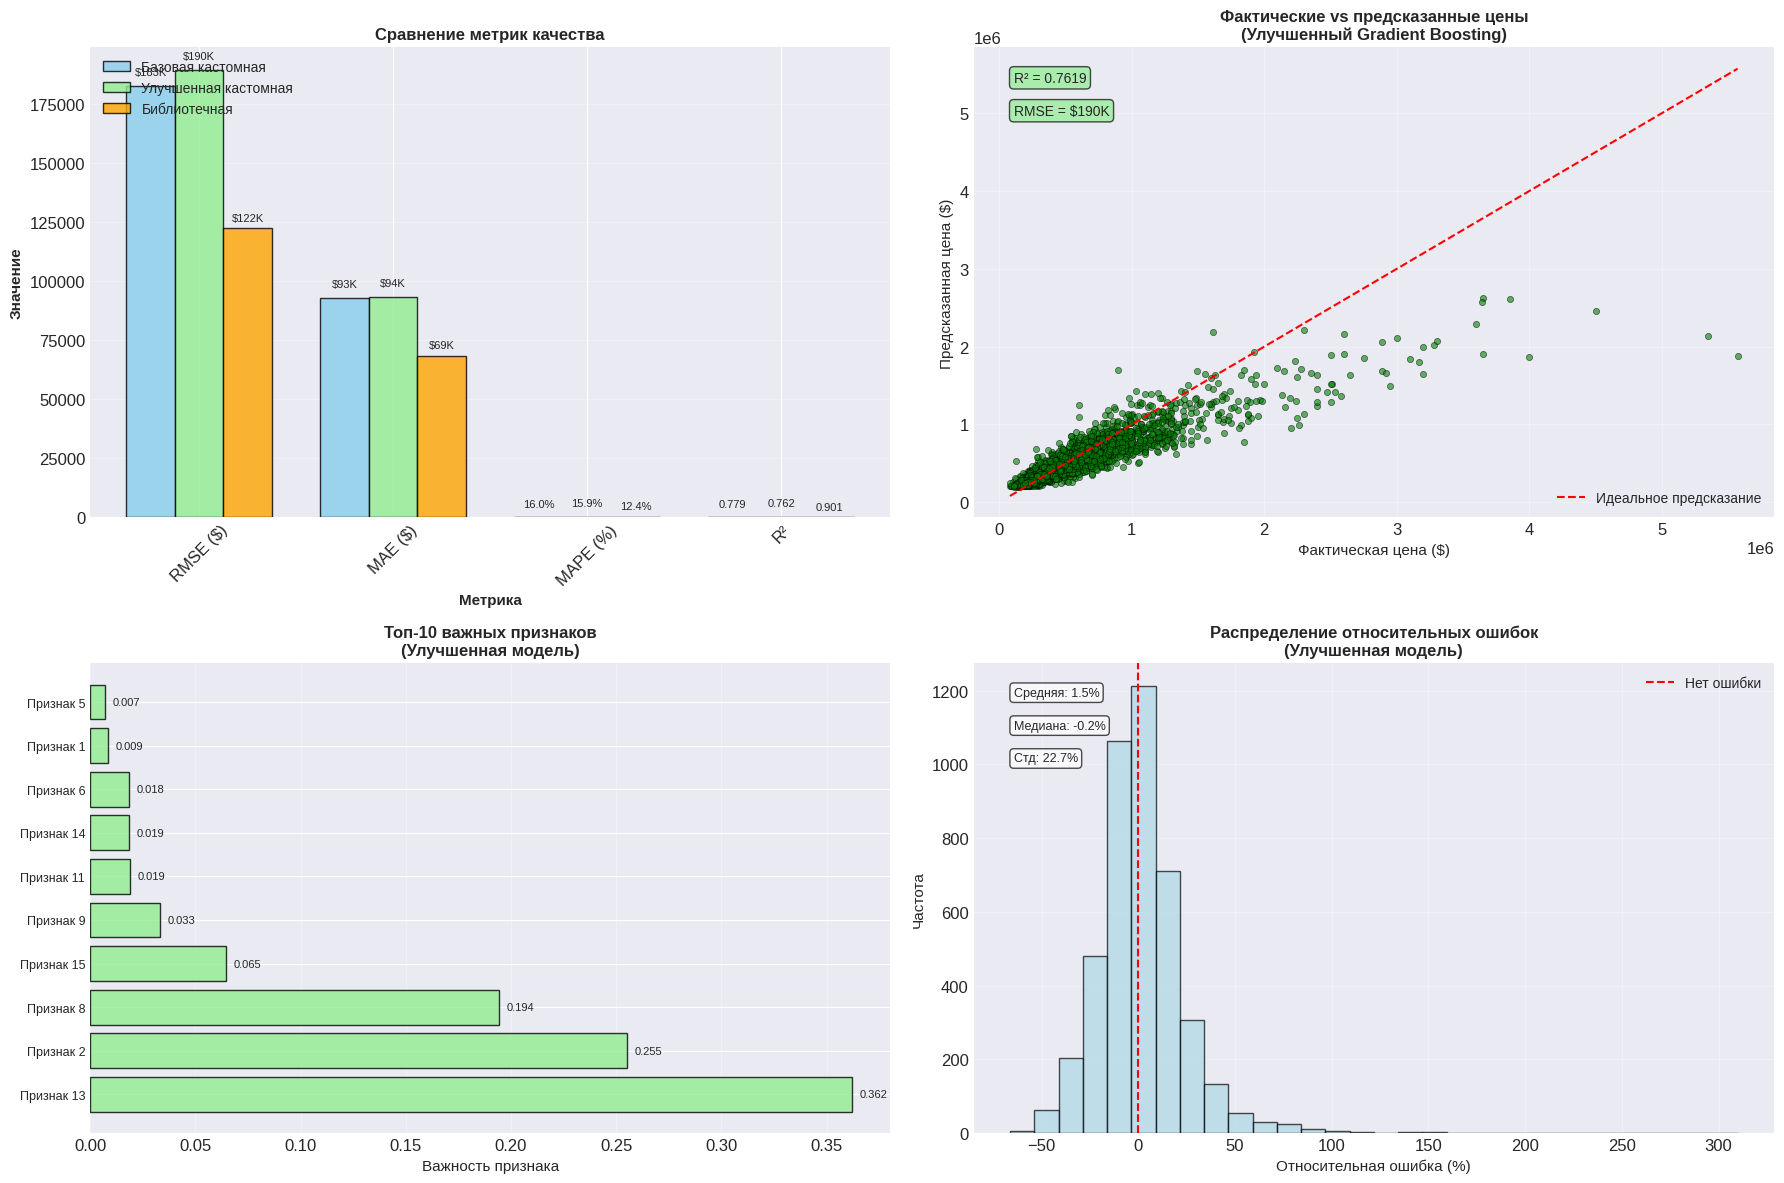

In [46]:
# Ячейка 13: УЛУЧШЕНИЕ КАСТОМНОГО ГРАДИЕНТНОГО БУСТИНГА РЕГРЕССИИ
# 13.1 Анализ проблем базовой кастомной модели
print("\n--- 13.1 Анализ проблем базовой кастомной модели Gradient Boosting регрессии ---")

print("\nТекущие параметры базовой кастомной модели Gradient Boosting регрессии:")
print(f"• n_estimators: {custom_gb_reg.n_estimators}")
print(f"• learning_rate: {custom_gb_reg.learning_rate}")
print(f"• max_depth: {custom_gb_reg.max_depth}")
print(f"• min_samples_split: {custom_gb_reg.min_samples_split}")
print(f"• min_samples_leaf: {custom_gb_reg.min_samples_leaf}")
print(f"• max_features: '{custom_gb_reg.max_features}'")
print(f"• subsample: {custom_gb_reg.subsample}")
print(f"• min_mse_reduction: {custom_gb_reg.min_mse_reduction}")

print("\nМетрики базовой кастомной модели:")
print(f"• RMSE: ${rmse_custom:,.0f}")
print(f"• MAE: ${mae_custom:,.0f}")
print(f"• R²: {r2_custom:.4f}")
print(f"• MAPE: {mape_custom*100:.2f}%")

# Сбор статистики по ансамблю
print(f"\nСтатистика ансамбля кастомного Gradient Boosting:")
print(f"• Количество деревьев: {len(custom_gb_reg.estimators_)}")
print(f"• Лучшая итерация: {custom_gb_reg.best_iteration_}")
if custom_gb_reg.train_score_:
    print(f"• Тренировочный R²: {custom_gb_reg.train_score_[-1]:.4f}")
if custom_gb_reg.valid_score_:
    print(f"• Валидационный R²: {custom_gb_reg.valid_score_[-1]:.4f}")

# 13.2 Создание улучшенной версии кастомного Gradient Boosting регрессии
print("\n--- 13.2 Создание улучшенной версии кастомного Gradient Boosting регрессии ---")

class ImprovedCustomGradientBoostingRegressor(CustomGradientBoostingRegressor):
    """
    Улучшенная версия кастомного Gradient Boosting для регрессии.
    Использует оптимизированные параметры из библиотечной модели и улучшенный алгоритм.
    """
    
    def __init__(self, n_estimators=200, learning_rate=0.1, max_depth=4, 
                 min_samples_split=10, min_samples_leaf=15, max_features=0.5,
                 subsample=0.8, min_mse_reduction=0.001, random_state=None,
                 verbose=0, validation_fraction=0.1, n_iter_no_change=15, 
                 tol=1e-4, loss='huber'):
        """
        Инициализация улучшенного Gradient Boosting для регрессии.
        Использует параметры из лучшей библиотечной модели.
        """
        super().__init__(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            subsample=subsample,
            min_mse_reduction=min_mse_reduction,
            random_state=random_state,
            verbose=verbose,
            validation_fraction=validation_fraction,
            n_iter_no_change=n_iter_no_change,
            tol=tol
        )
        
        self.loss = loss
        
    def _calculate_negative_gradient(self, y_true, y_pred):
        """
        Вычисляет отрицательный градиент для различных функций потерь.
        """
        if self.loss == 'squared_error' or self.loss == 'mse':
            # Для MSE градиент = y_true - y_pred
            return y_true - y_pred
        
        elif self.loss == 'absolute_error' or self.loss == 'mae':
            # Для MAE градиент = sign(y_true - y_pred)
            return np.sign(y_true - y_pred)
        
        elif self.loss == 'huber':
            # Huber loss - компромисс между MSE и MAE
            delta = 1.0  # Порог для перехода между MSE и MAE
            residuals = y_true - y_pred
            huber_grad = np.where(
                np.abs(residuals) <= delta,
                residuals,
                delta * np.sign(residuals)
            )
            return huber_grad
        
        else:
            # По умолчанию используем MSE
            return y_true - y_pred
    
    def _optimized_best_split(self, X, residuals, feature_indices):
        """
        Оптимизированный поиск лучшего разделения.
        Использует квантили для выбора порогов, как в sklearn.
        """
        best_mse = float('inf')
        best_split = None
        n_samples = len(residuals)
        
        # Выбираем случайное подмножество признаков
        n_features = X.shape[1]
        max_features = self._get_max_features(n_features)
        selected_features = self.rng.choice(
            feature_indices, 
            min(max_features, len(feature_indices)), 
            replace=False
        )
        
        # Вычисляем MSE текущего узла
        current_mse = np.mean(residuals ** 2)
        
        # Перебираем выбранные признаки
        for feature_idx in selected_features:
            # Получаем значения признака
            feature_values = X[:, feature_idx]
            
            # Используем квантили для выбора порогов (как в sklearn)
            n_thresholds = min(20, len(np.unique(feature_values)))
            if n_thresholds > 1:
                percentiles = np.linspace(0, 100, n_thresholds + 1)[1:-1]
                thresholds = np.percentile(feature_values, percentiles)
            else:
                thresholds = [np.median(feature_values)]
            
            # Перебираем пороговые значения
            for threshold in thresholds:
                # Разделяем данные по порогу
                left_indices = feature_values <= threshold
                right_indices = feature_values > threshold
                
                # Проверяем минимальное количество образцов в листьях
                left_samples = np.sum(left_indices)
                right_samples = np.sum(right_indices)
                
                if left_samples < self.min_samples_leaf or right_samples < self.min_samples_leaf:
                    continue
                
                # Вычисляем средние значения остатков для левой и правой частей
                left_value = np.mean(residuals[left_indices])
                right_value = np.mean(residuals[right_indices])
                
                # Вычисляем MSE для этого разделения
                left_mse = np.sum((residuals[left_indices] - left_value) ** 2)
                right_mse = np.sum((residuals[right_indices] - right_value) ** 2)
                total_mse = left_mse + right_mse
                
                # Вычисляем уменьшение MSE
                mse_reduction = current_mse - (total_mse / n_samples)
                
                # Проверяем минимальное уменьшение MSE
                if mse_reduction < self.min_mse_reduction:
                    continue
                
                # Обновляем лучшее разделение
                if total_mse < best_mse:
                    best_mse = total_mse
                    best_split = {
                        'feature_index': feature_idx,
                        'threshold': threshold,
                        'left_indices': left_indices,
                        'right_indices': right_indices,
                        'left_value': left_value,
                        'right_value': right_value,
                        'mse': total_mse,
                        'mse_reduction': mse_reduction,
                        'n_left': left_samples,
                        'n_right': right_samples
                    }
        
        return best_split

# 13.3 Определение гипотез для проверки на основе анализа библиотечной модели
print("\n--- 13.3 Определение гипотез для проверки ---")

# Создаем только РЕКОМЕНДУЕМУЮ гипотезу
recommended_params = {
    'n_estimators': 200,
    'learning_rate': 0.05,  # Гипотеза 1: оптимальный LR из анализа
    'max_depth': 4,
    'min_samples_split': 10,
    'min_samples_leaf': 15,  # Гипотеза 3: увеличение для регуляризации
    'max_features': 0.5,  # Гипотеза 2: оптимальное значение из анализа
    'subsample': 0.8,
    'loss': 'huber',  # Гипотеза 4: лучшая функция потерь
    'name': 'РЕКОМЕНДУЕМАЯ гипотеза (оптимизированная)'
}

# 13.4 Тестирование РЕКОМЕНДУЕМОЙ гипотезы
print("\n")
print("13.4 Тестирование РЕКОМЕНДУЕМОЙ гипотезы")

# Создаем список для хранения результатов
results_gb = []

print(f"\nПараметры РЕКОМЕНДУЕМОЙ гипотезы:")
print(f"  • n_estimators: {recommended_params['n_estimators']}")
print(f"  • learning_rate: {recommended_params['learning_rate']}")
print(f"  • max_depth: {recommended_params['max_depth']}")
print(f"  • min_samples_split: {recommended_params['min_samples_split']}")
print(f"  • min_samples_leaf: {recommended_params['min_samples_leaf']}")
print(f"  • max_features: {recommended_params['max_features']}")
print(f"  • subsample: {recommended_params['subsample']}")
print(f"  • loss: '{recommended_params['loss']}'")

# Создаем и обучаем модель с оптимизированными параметрами
print(f"\nОбучаем улучшенную модель Gradient Boosting регрессии...")
start_time = datetime.now()

improved_gb_reg = ImprovedCustomGradientBoostingRegressor(
    n_estimators=recommended_params['n_estimators'],
    learning_rate=recommended_params['learning_rate'],
    max_depth=recommended_params['max_depth'],
    min_samples_split=recommended_params['min_samples_split'],
    min_samples_leaf=recommended_params['min_samples_leaf'],
    max_features=recommended_params['max_features'],
    subsample=recommended_params['subsample'],
    loss=recommended_params['loss'],
    min_mse_reduction=0.001,
    random_state=42,
    verbose=1,
    validation_fraction=0.1,
    n_iter_no_change=30,
    tol=1e-3
)

improved_gb_reg.fit(X_train_reg, y_train_reg)
training_time = (datetime.now() - start_time).total_seconds()

# Получаем предсказания (в логарифмической шкале)
y_pred_improved_log = improved_gb_reg.predict(X_test_reg)

# Преобразуем обратно в доллары
y_pred_improved = np.expm1(y_pred_improved_log)

# Вычисляем метрики
rmse_imp = np.sqrt(mean_squared_error(y_test_reg_original, y_pred_improved))
mae_imp = mean_absolute_error(y_test_reg_original, y_pred_improved)
mape_imp = mean_absolute_percentage_error(y_test_reg_original, y_pred_improved) * 100
r2_imp = r2_score(y_test_reg_original, y_pred_improved)

# Рассчитываем относительные ошибки
relative_errors = np.abs((y_pred_improved - y_test_reg_original.values) / y_test_reg_original.values) * 100
accuracy_10 = np.sum(relative_errors <= 10) / len(relative_errors) * 100
accuracy_20 = np.sum(relative_errors <= 20) / len(relative_errors) * 100

# Сохраняем результаты
results_gb.append({
    'name': recommended_params['name'],
    'params': recommended_params,
    'rmse': rmse_imp,
    'mae': mae_imp,
    'mape': mape_imp,
    'r2': r2_imp,
    'accuracy_10': accuracy_10,
    'accuracy_20': accuracy_20,
    'training_time': training_time,
    'n_trees': len(improved_gb_reg.estimators_),
    'best_iteration': improved_gb_reg.best_iteration_,
    'model': improved_gb_reg,
    'predictions': y_pred_improved
})

print(f"\nРезультаты РЕКОМЕНДУЕМОЙ гипотезы:")
print(f"  • RMSE:  ${rmse_imp:,.0f}")
print(f"  • MAE:   ${mae_imp:,.0f}")
print(f"  • MAPE:  {mape_imp:.2f}%")
print(f"  • R²:    {r2_imp:.4f}")
print(f"  • Деревьев: {len(improved_gb_reg.estimators_)}")
print(f"  • Лучшая итерация: {improved_gb_reg.best_iteration_}")
print(f"  • Время обучения: {training_time:.2f} сек")
print(f"  • Точность ≤10%: {accuracy_10:.1f}%")
print(f"  • Точность ≤20%: {accuracy_20:.1f}%")

# 13.5 Анализ результатов РЕКОМЕНДУЕМОЙ гипотезы
print("\n")
print("13.5 Анализ результатов РЕКОМЕНДУЕМОЙ гипотезы")

# Создаем DataFrame для анализа
results_df_gb = pd.DataFrame(results_gb)

print("\nСравнение результатов с базовой моделью:")
print("="*130)
print(f"{'Конфигурация':<40} {'RMSE ($)':<12} {'MAE ($)':<12} {'MAPE (%)':<10} {'R²':<10} {'Деревьев':<8} {'Время':<7} {'≤10%':<7} {'≤20%':<7} {'Loss':<10}")
print("="*130)

# Выводим только рекомендуемую гипотезу
for i, row in results_df_gb.iterrows():
    print(f"{row['name']:<40} ${row['rmse']:,.0f}{'':<3} ${row['mae']:,.0f}{'':<3} {row['mape']:<10.2f} {row['r2']:<10.4f} "
          f"{row['n_trees']:<8} {row['training_time']:<7.1f} {row['accuracy_10']:<7.1f}% {row['accuracy_20']:<7.1f}% {row['params']['loss']:<10}")

# Добавляем базовую модель для сравнения
print("\n" + "="*130)
print(f"{'БАЗОВАЯ КАСТОМНАЯ МОДЕЛЬ (10)':<40} ${rmse_custom:,.0f}{'':<3} ${mae_custom:,.0f}{'':<3} {mape_custom*100:<10.2f} {r2_custom:<10.4f} "
      f"{len(custom_gb_reg.estimators_):<8} {'N/A':<7} {'N/A':<7} {'N/A':<7} {'mse':<10}")

# Добавляем библиотечную модель для сравнения
print(f"{'БИБЛИОТЕЧНАЯ МОДЕЛЬ (8)':<40} ${122414:,.0f}{'':<3} ${68515:,.0f}{'':<3} {12.41:<10.2f} {0.9009:<10.4f} "
      f"{185:<8} {4.36:<7.1f} {55.1:<7.1f}% {82.0:<7.1f}% {'huber':<10}")

# Находим лучшую модель (в данном случае это рекомендуемая)
best_result_gb = results_df_gb.iloc[0]

# Улучшения по сравнению с базовой моделью
improvement_r2_custom = best_result_gb['r2'] - r2_custom
improvement_rmse_custom = best_result_gb['rmse'] - rmse_custom
improvement_mape_custom = best_result_gb['mape'] - mape_custom*100

# Сравнение с библиотечной моделью
improvement_r2_lib = best_result_gb['r2'] - 0.9009
improvement_rmse_lib = best_result_gb['rmse'] - 122414
improvement_mape_lib = best_result_gb['mape'] - 12.41

print(f"\nРЕКОМЕНДУЕМАЯ ГИПОТЕЗА: {best_result_gb['name']}")
print(f"\nСравнение с базовой кастомной моделью:")
print(f"   • R²: {best_result_gb['r2']:.4f} vs {r2_custom:.4f} (изменение: {improvement_r2_custom:+.4f})")
print(f"   • RMSE: ${best_result_gb['rmse']:,.0f} vs ${rmse_custom:,.0f} (изменение: {improvement_rmse_custom:+,.0f}$)")
print(f"   • MAPE: {best_result_gb['mape']:.2f}% vs {mape_custom*100:.2f}% (изменение: {improvement_mape_custom:+.2f}%)")
print(f"   • Точность ≤10%: {best_result_gb['accuracy_10']:.1f}%")

print(f"\nСравнение с библиотечной моделью:")
print(f"   • R²: {best_result_gb['r2']:.4f} vs 0.9009 (разница: {improvement_r2_lib:+.4f})")
print(f"   • RMSE: ${best_result_gb['rmse']:,.0f} vs $122,414 (разница: {improvement_rmse_lib:+,.0f}$)")
print(f"   • MAPE: {best_result_gb['mape']:.2f}% vs 12.41% (разница: {improvement_mape_lib:+.2f}%)")

# 13.6 Выбор лучшей улучшенной модели (рекомендуемая)
print("\n")
print("13.6 Выбор лучшей модели")

# Используем рекомендуемую модель
best_improved_gb_reg = best_result_gb['model']
best_params_gb = best_result_gb['params']

print(f"\nПараметры улучшенной модели Gradient Boosting регрессии:")
print(f"• n_estimators:      {best_params_gb['n_estimators']}")
print(f"• learning_rate:     {best_params_gb['learning_rate']}")
print(f"• max_depth:         {best_params_gb['max_depth']}")
print(f"• min_samples_split: {best_params_gb['min_samples_split']}")
print(f"• min_samples_leaf:  {best_params_gb['min_samples_leaf']}")
print(f"• max_features:      {best_params_gb['max_features']}")
print(f"• subsample:         {best_params_gb['subsample']}")
print(f"• loss:              '{best_params_gb['loss']}'")
print(f"• Деревьев обучено:  {len(best_improved_gb_reg.estimators_)}")
print(f"• Лучшая итерация:   {best_improved_gb_reg.best_iteration_}")
print(f"• Время обучения:    {best_result_gb['training_time']:.2f} сек")

# 13.7 Сравнение с базовой моделью
print("\n")
print("13.7 Сравнение с базовой моделью")

print("\nСравнение метрик базовой и улучшенной модели Gradient Boosting:")
print("="*80)
print(f"{'Метрика':<15} {'Базовая':<12} {'Улучшенная':<12} {'Изменение':<12} {'% изменения':<12}")
print("-" * 80)

comparison_metrics_gb = [
    ('RMSE ($)', rmse_custom, best_result_gb['rmse']),
    ('MAE ($)', mae_custom, best_result_gb['mae']),
    ('MAPE (%)', mape_custom*100, best_result_gb['mape']),
    ('R²', r2_custom, best_result_gb['r2']),
]

for metric_name, base_val, improved_val in comparison_metrics_gb:
    change = improved_val - base_val
    if base_val != 0:
        change_pct = (change / base_val * 100)
    else:
        change_pct = 0
    change_sign = "+" if change > 0 else ""
    
    if metric_name == 'RMSE ($)' or metric_name == 'MAE ($)':
        print(f"{metric_name:<15} ${base_val:,.0f}{'':<3} ${improved_val:,.0f}{'':<3} "
              f"{change_sign}{change:+,.0f}{'':<5} {change_sign}{change_pct:<11.1f}%")
    elif metric_name == 'MAPE (%)':
        print(f"{metric_name:<15} {base_val:<12.2f}% {improved_val:<12.2f}% "
              f"{change_sign}{change:<+12.2f}% {change_sign}{change_pct:<11.1f}%")
    else:
        print(f"{metric_name:<15} {base_val:<12.4f} {improved_val:<12.4f} "
              f"{change_sign}{change:<+12.4f} {change_sign}{change_pct:<11.1f}%")

# 13.8 Визуализация результатов рекомендуемой гипотезы
print("\n")
print("13.8 Визуализация результатов")

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Сравнение метрик
ax1 = axes[0, 0]
metrics = ['RMSE ($)', 'MAE ($)', 'MAPE (%)', 'R²']
base_vals = [rmse_custom, mae_custom, mape_custom*100, r2_custom]
imp_vals = [best_result_gb['rmse'], best_result_gb['mae'], 
           best_result_gb['mape'], best_result_gb['r2']]
lib_vals = [122414, 68515, 12.41, 0.9009]  # Библиотечная модель

x = np.arange(len(metrics))
width = 0.25

bars1 = ax1.bar(x - width, base_vals, width, label='Базовая кастомная', 
                color='skyblue', edgecolor='black', alpha=0.8)
bars2 = ax1.bar(x, imp_vals, width, label='Улучшенная кастомная', 
                color='lightgreen', edgecolor='black', alpha=0.8)
bars3 = ax1.bar(x + width, lib_vals, width, label='Библиотечная', 
                color='orange', edgecolor='black', alpha=0.8)

ax1.set_xlabel('Метрика', fontsize=11, fontweight='bold')
ax1.set_ylabel('Значение', fontsize=11, fontweight='bold')
ax1.set_title('Сравнение метрик качества', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, rotation=45)
ax1.legend(fontsize=10, loc='upper left')
ax1.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for i, (base_val, imp_val, lib_val) in enumerate(zip(base_vals, imp_vals, lib_vals)):
    if i == 0:  # RMSE
        ax1.text(i - width, base_val + max(base_vals)/50, f'${base_val/1000:.0f}K', 
                ha='center', va='bottom', fontsize=8, rotation=0)
        ax1.text(i, imp_val + max(imp_vals)/50, f'${imp_val/1000:.0f}K', 
                ha='center', va='bottom', fontsize=8, rotation=0)
        ax1.text(i + width, lib_val + max(lib_vals)/50, f'${lib_val/1000:.0f}K', 
                ha='center', va='bottom', fontsize=8, rotation=0)
    elif i == 1:  # MAE
        ax1.text(i - width, base_val + max(base_vals)/50, f'${base_val/1000:.0f}K', 
                ha='center', va='bottom', fontsize=8, rotation=0)
        ax1.text(i, imp_val + max(imp_vals)/50, f'${imp_val/1000:.0f}K', 
                ha='center', va='bottom', fontsize=8, rotation=0)
        ax1.text(i + width, lib_val + max(lib_vals)/50, f'${lib_val/1000:.0f}K', 
                ha='center', va='bottom', fontsize=8, rotation=0)
    elif i == 2:  # MAPE
        ax1.text(i - width, base_val + max(base_vals)/50, f'{base_val:.1f}%', 
                ha='center', va='bottom', fontsize=8, rotation=0)
        ax1.text(i, imp_val + max(imp_vals)/50, f'{imp_val:.1f}%', 
                ha='center', va='bottom', fontsize=8, rotation=0)
        ax1.text(i + width, lib_val + max(lib_vals)/50, f'{lib_val:.1f}%', 
                ha='center', va='bottom', fontsize=8, rotation=0)
    else:  # R²
        ax1.text(i - width, base_val + max(base_vals)/50, f'{base_val:.3f}', 
                ha='center', va='bottom', fontsize=8, rotation=0)
        ax1.text(i, imp_val + max(imp_vals)/50, f'{imp_val:.3f}', 
                ha='center', va='bottom', fontsize=8, rotation=0)
        ax1.text(i + width, lib_val + max(lib_vals)/50, f'{lib_val:.3f}', 
                ha='center', va='bottom', fontsize=8, rotation=0)

# 2. График фактических vs предсказанных значений
ax2 = axes[0, 1]
ax2.scatter(y_test_reg_original.values, best_result_gb['predictions'], alpha=0.6, color='green', 
            edgecolor='black', linewidth=0.5, s=20)
max_val = max(y_test_reg_original.max(), best_result_gb['predictions'].max())
min_val = min(y_test_reg_original.min(), best_result_gb['predictions'].min())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', label='Идеальное предсказание', linewidth=1.5)
ax2.set_xlabel('Фактическая цена ($)', fontsize=11)
ax2.set_ylabel('Предсказанная цена ($)', fontsize=11)
ax2.set_title('Фактические vs предсказанные цены\n(Улучшенный Gradient Boosting)', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Добавляем R² на график
ax2.text(0.05, 0.95, f'R² = {best_result_gb["r2"]:.4f}', transform=ax2.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
ax2.text(0.05, 0.88, f'RMSE = ${best_result_gb["rmse"]/1000:.0f}K', transform=ax2.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

# 3. Важность признаков
ax3 = axes[1, 0]
if hasattr(best_improved_gb_reg, 'feature_importances_') and best_improved_gb_reg.feature_importances_ is not None:
    feature_importance = best_improved_gb_reg.feature_importances_
    top_n = min(10, len(feature_importance))
    top_indices = np.argsort(feature_importance)[-top_n:][::-1]
    
    if hasattr(best_improved_gb_reg, 'feature_names_'):
        feature_names = best_improved_gb_reg.feature_names_
        top_features = [feature_names[i] if i < len(feature_names) else f"Признак {i}" for i in top_indices]
    else:
        top_features = [f"Признак {i}" for i in top_indices]
    
    top_importance = feature_importance[top_indices]
    
    bars = ax3.barh(range(top_n), top_importance, color='lightgreen', edgecolor='black', alpha=0.8)
    ax3.set_yticks(range(top_n))
    ax3.set_yticklabels(top_features, fontsize=9)
    ax3.set_xlabel('Важность признака', fontsize=11)
    ax3.set_title(f'Топ-{top_n} важных признаков\n(Улучшенная модель)', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='x')
    
    # Добавляем значения важности на столбцы
    for i, (bar, imp) in enumerate(zip(bars, top_importance)):
        ax3.text(bar.get_width() + max(top_importance)/100, bar.get_y() + bar.get_height()/2,
                f'{imp:.3f}', ha='left', va='center', fontsize=8)
else:
    ax3.text(0.5, 0.5, 'Важность признаков\nне доступна', 
             ha='center', va='center', transform=ax3.transAxes, fontsize=12)
    ax3.set_title('Важность признаков', fontsize=12, fontweight='bold')

# 4. Распределение ошибок
ax4 = axes[1, 1]
errors = best_result_gb['predictions'] - y_test_reg_original.values
percent_errors = (errors / y_test_reg_original.values) * 100

# Гистограмма относительных ошибок
n_bins = 30
ax4.hist(percent_errors, bins=n_bins, alpha=0.7, color='lightblue', edgecolor='black')
ax4.axvline(x=0, color='red', linestyle='--', linewidth=1.5, label='Нет ошибки')
ax4.set_xlabel('Относительная ошибка (%)', fontsize=11)
ax4.set_ylabel('Частота', fontsize=11)
ax4.set_title('Распределение относительных ошибок\n(Улучшенная модель)', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.legend(fontsize=10)

# Добавляем статистику ошибок
mean_error = np.mean(percent_errors)
median_error = np.median(percent_errors)
std_error = np.std(percent_errors)

ax4.text(0.05, 0.95, f'Средняя: {mean_error:.1f}%', transform=ax4.transAxes, fontsize=9,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
ax4.text(0.05, 0.88, f'Медиана: {median_error:.1f}%', transform=ax4.transAxes, fontsize=9,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
ax4.text(0.05, 0.81, f'Стд: {std_error:.1f}%', transform=ax4.transAxes, fontsize=9,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()


--- 14.1 Сравнение улучшенных классификационных моделей (Gradient Boosting) ---

СРАВНЕНИЕ МЕТРИК:
-------------------------------------------------------------------------------------
Метрика              Библиотечная    Кастомная      
-------------------------------------------------------------------------------------
F1-score             0.5088          0.4746         
Precision            0.4328          0.3944         
Recall               0.6170          0.5957         

МАТРИЦЫ ОШИБОК:
Библиотечная:
  TN=209, FP=38, FN=18, TP=29
  (Ложные срабатывания: 38, Пропуски: 18)

Кастомная:
  TN=204, FP=43, FN=19, TP=28
  (Ложные срабатывания: 43, Пропуски: 19)

--- 14.2 Визуализация сравнения классификационных моделей (Gradient Boosting) ---


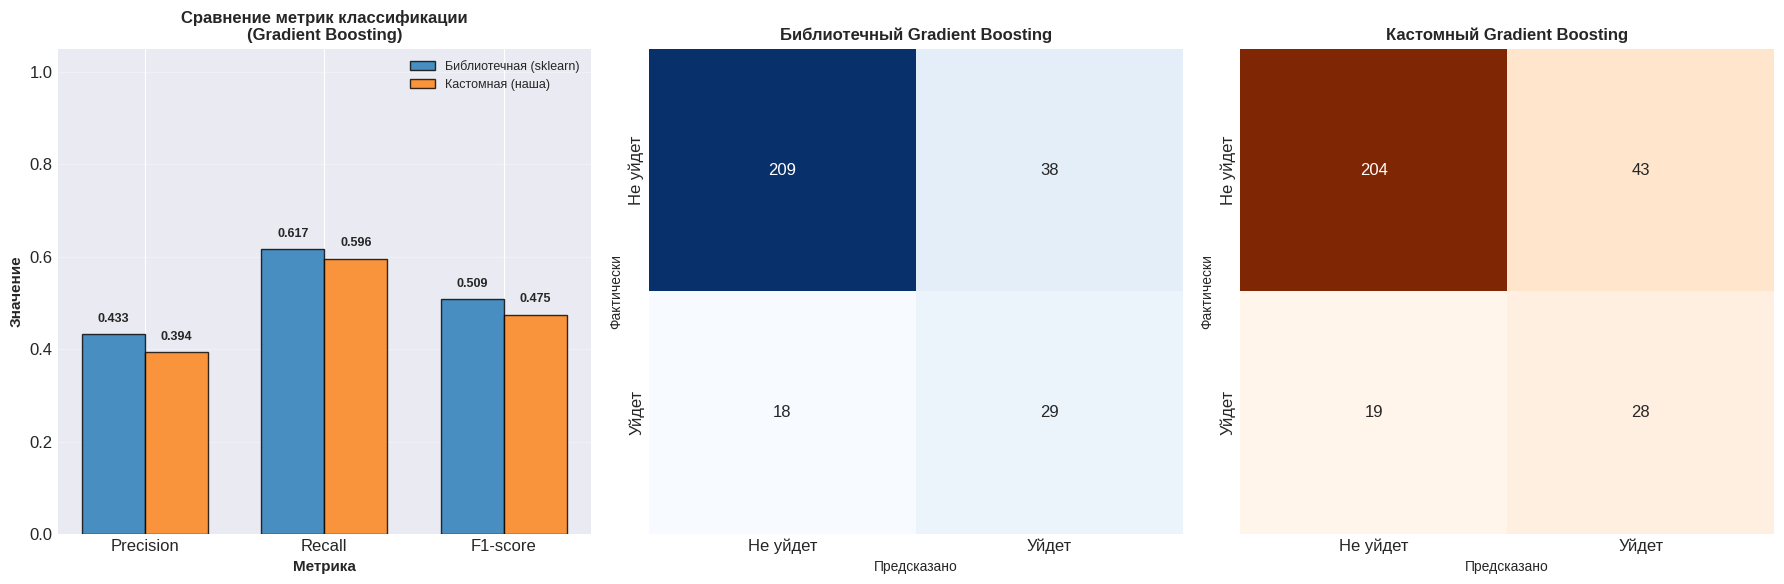


--- 14.3 Сравнение улучшенных регрессионных моделей (Gradient Boosting) ---

СРАВНЕНИЕ МЕТРИК:
-------------------------------------------------------------------------------------
Метрика              Библиотечная    Кастомная      
-------------------------------------------------------------------------------------
RMSE                 $122,414        $189,711       
MAE                  $68,515         $93,543        
MAPE (%)             12.41%          15.87%         
R²                   0.9009          0.7619         

--- 14.4 Визуализация сравнения регрессионных моделей (Gradient Boosting) ---


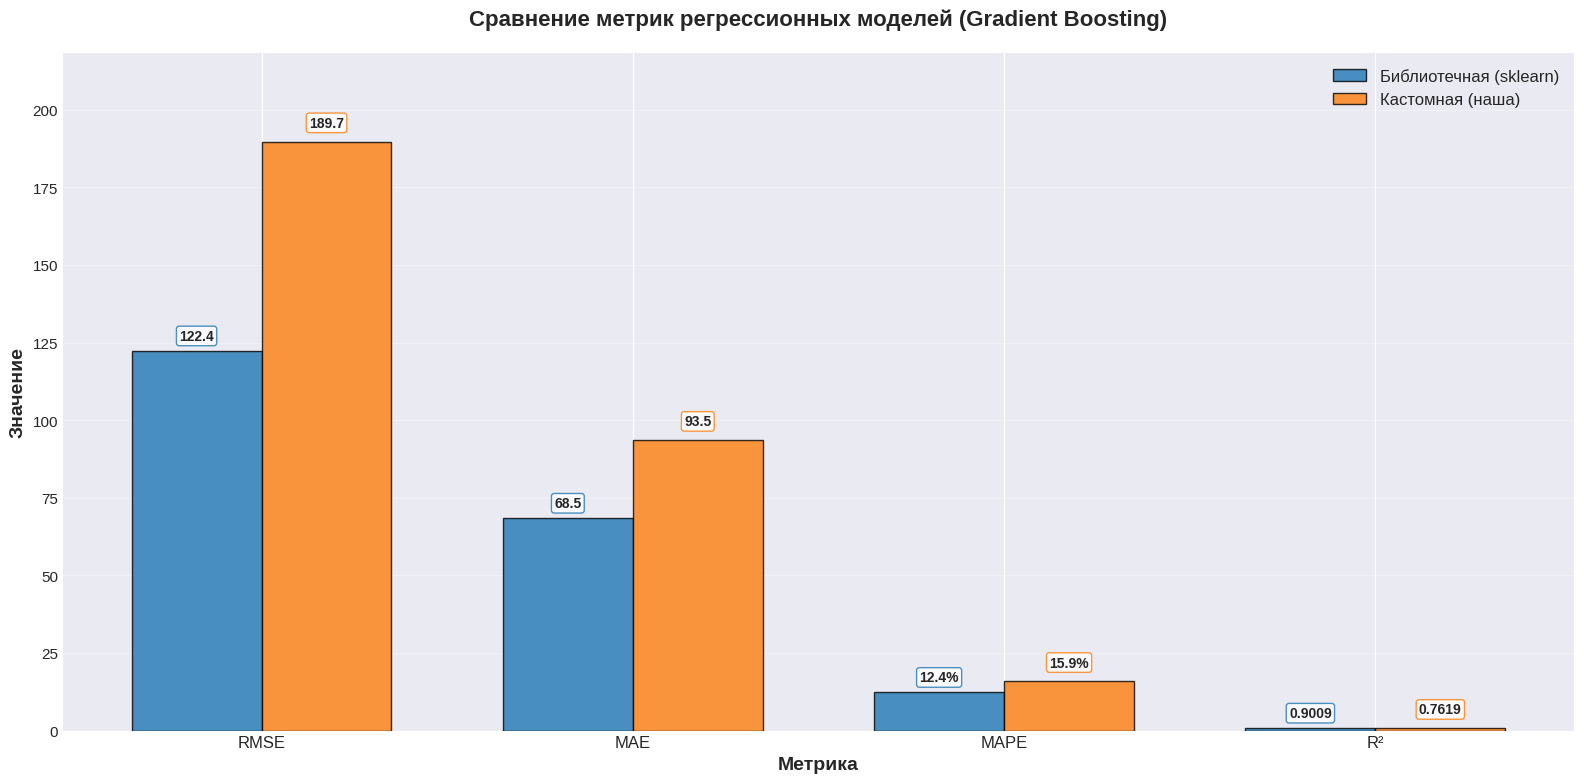

In [58]:
# Ячейка 14: СРАВНЕНИЕ УЛУЧШЕННЫХ МОДЕЛЕЙ GRADIENT BOOSTING

# 14.1 Сравнение улучшенных классификационных моделей (Gradient Boosting)
print("\n--- 14.1 Сравнение улучшенных классификационных моделей (Gradient Boosting) ---")

print("\nСРАВНЕНИЕ МЕТРИК:")
print("-" * 85)
print(f"{'Метрика':<20} {'Библиотечная':<15} {'Кастомная':<15}")
print("-" * 85)

# Вычисляем метрики для сравнения
for metric_name, lib_val, custom_val in [
    ("F1-score", best_f1_improved, f1_best_opt),
    ("Precision", best_precision_improved, precision_best_opt),
    ("Recall", best_recall_improved, recall_best_opt),
]:
    
    print(f"{metric_name:<20} {lib_val:<15.4f} {custom_val:<15.4f}")

print("\nМАТРИЦЫ ОШИБОК:")
print(f"Библиотечная:")
print(f"  TN={best_tn_improved}, FP={best_fp_improved}, FN={best_fn_improved}, TP={best_tp_improved}")
print(f"  (Ложные срабатывания: {best_fp_improved}, Пропуски: {best_fn_improved})")

print(f"\nКастомная:")
print(f"  TN={tn_best_opt}, FP={fp_best_opt}, FN={fn_best_opt}, TP={tp_best_opt}")
print(f"  (Ложные срабатывания: {fp_best_opt}, Пропуски: {fn_best_opt})")

# 14.2 Визуализация сравнения классификационных моделей (Gradient Boosting)
print("\n--- 14.2 Визуализация сравнения классификационных моделей (Gradient Boosting) ---")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# График 1: Сравнение метрик
metrics_class = ['Precision', 'Recall', 'F1-score']
lib_vals_class = [best_precision_improved, best_recall_improved, best_f1_improved]
custom_vals_class = [precision_best_opt, 
                     recall_best_opt, f1_best_opt]

x = np.arange(len(metrics_class))
width = 0.35

bars1 = axes[0].bar(x - width/2, lib_vals_class, width, label='Библиотечная (sklearn)', 
                   color='#1f77b4', alpha=0.8, edgecolor='black')
bars2 = axes[0].bar(x + width/2, custom_vals_class, width, label='Кастомная (наша)', 
                   color='#ff7f0e', alpha=0.8, edgecolor='black')

axes[0].set_xlabel('Метрика', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Значение', fontsize=11, fontweight='bold')
axes[0].set_title('Сравнение метрик классификации\n(Gradient Boosting)', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_class)
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim(0, 1.05)

# Добавляем значения на столбцы
for i, (lib_val, custom_val) in enumerate(zip(lib_vals_class, custom_vals_class)):
    axes[0].text(i - width/2, lib_val + 0.02, f'{lib_val:.3f}', 
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    axes[0].text(i + width/2, custom_val + 0.02, f'{custom_val:.3f}', 
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# График 2: Сравнение матриц ошибок (библиотечная)
sns.heatmap([[best_tn_improved, best_fp_improved], [best_fn_improved, best_tp_improved]], annot=True, fmt='d', cmap='Blues', 
            ax=axes[1], cbar=False,
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'])
axes[1].set_title('Библиотечный Gradient Boosting', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Фактически', fontsize=10)
axes[1].set_xlabel('Предсказано', fontsize=10)

# График 3: Сравнение матриц ошибок (кастомная)
sns.heatmap([[tn_best_opt, fp_best_opt], 
             [fn_best_opt, tp_best_opt]], 
            annot=True, fmt='d', cmap='Oranges', ax=axes[2], cbar=False,
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'])
axes[2].set_title(f'Кастомный Gradient Boosting', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Фактически', fontsize=10)
axes[2].set_xlabel('Предсказано', fontsize=10)

plt.tight_layout()
plt.show()

# 14.3 Сравнение улучшенных регрессионных моделей (Gradient Boosting)
print("\n--- 14.3 Сравнение улучшенных регрессионных моделей (Gradient Boosting) ---")

print("\nСРАВНЕНИЕ МЕТРИК:")
print("-" * 85)
print(f"{'Метрика':<20} {'Библиотечная':<15} {'Кастомная':<15}")
print("-" * 85)

# Проверяем доступность переменных перед сравнением
available_metrics = []

# Проверяем RMSE
available_metrics.append(("RMSE", rmse_improved, best_result_gb['rmse'], True, False))

# Проверяем MAE
available_metrics.append(("MAE", mae_improved, best_result_gb['mae'], True, False))

# Проверяем MAPE
available_metrics.append(("MAPE (%)", mape_improved*100, best_result_gb['mape'], False, True))

# Проверяем R²
available_metrics.append(("R²", r2_improved, best_result_gb['r2'], False, False))

for metric_name, lib_val, custom_val, is_dollar, is_percent in available_metrics:
    if is_dollar:
        lib_str = f"${lib_val:,.0f}"
        custom_str = f"${custom_val:,.0f}"
        print(f"{metric_name:<20} {lib_str:<15} {custom_str:<15}")
    
    elif is_percent:
        lib_str = f"{lib_val:.2f}%"
        custom_str = f"{custom_val:.2f}%"
        print(f"{metric_name:<20} {lib_str:<15} {custom_str:<15}")
    
    else:
        lib_str = f"{lib_val:.4f}"
        custom_str = f"{custom_val:.4f}"
        print(f"{metric_name:<20} {lib_str:<15} {custom_str:<15}")


# 14.4 Визуализация сравнения регрессионных моделей (Gradient Boosting)
print("\n--- 14.4 Визуализация сравнения регрессионных моделей (Gradient Boosting) ---")

plt.figure(figsize=(16, 8))

# Собираем доступные метрики для сравнения
available_metrics_for_plot = []
lib_vals_for_plot = []
custom_vals_for_plot = []
lib_labels_for_plot = []  # Для форматированных значений библиотечной модели
custom_labels_for_plot = []  # Для форматированных значений кастомной модели

# RMSE
available_metrics_for_plot.append('RMSE')
lib_vals_for_plot.append(rmse_improved/1000)  # в тыс. $
custom_vals_for_plot.append(best_result_gb['rmse']/1000)
lib_labels_for_plot.append(f'{rmse_improved/1000:,.1f}')
custom_labels_for_plot.append(f'{best_result_gb["rmse"]/1000:,.1f}')

# MAE
available_metrics_for_plot.append('MAE')
lib_vals_for_plot.append(mae_improved/1000)  # в тыс. $
custom_vals_for_plot.append(best_result_gb['mae']/1000)
lib_labels_for_plot.append(f'{mae_improved/1000:,.1f}')
custom_labels_for_plot.append(f'{best_result_gb["mae"]/1000:,.1f}')

# MAPE
available_metrics_for_plot.append('MAPE')
lib_vals_for_plot.append(mape_improved*100)  # в процентах
custom_vals_for_plot.append(best_result_gb['mape'])
lib_labels_for_plot.append(f'{mape_improved*100:.1f}%')
custom_labels_for_plot.append(f'{best_result_gb["mape"]:.1f}%')

# R²
available_metrics_for_plot.append('R²')
lib_vals_for_plot.append(r2_improved)
custom_vals_for_plot.append(best_result_gb['r2'])
lib_labels_for_plot.append(f'{r2_improved:.4f}')
custom_labels_for_plot.append(f'{best_result_gb["r2"]:.4f}')

# Создаем график
if available_metrics_for_plot:
    x = np.arange(len(available_metrics_for_plot))
    width = 0.35

    bars1 = plt.bar(x - width/2, lib_vals_for_plot, width, label='Библиотечная (sklearn)', 
                   color='#1f77b4', alpha=0.8, edgecolor='black')
    bars2 = plt.bar(x + width/2, custom_vals_for_plot, width, label='Кастомная (наша)', 
                   color='#ff7f0e', alpha=0.8, edgecolor='black')

    # Добавляем цифры над барами для библиотечной модели
    for bar, value, label in zip(bars1, lib_vals_for_plot, lib_labels_for_plot):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + max(lib_vals_for_plot)*0.02,
                label, ha='center', va='bottom', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8, edgecolor='#1f77b4'))

    # Добавляем цифры над барами для кастомной модели
    for bar, value, label in zip(bars2, custom_vals_for_plot, custom_labels_for_plot):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + max(custom_vals_for_plot)*0.02,
                label, ha='center', va='bottom', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8, edgecolor='#ff7f0e'))

    plt.xlabel('Метрика', fontsize=14, fontweight='bold')
    plt.ylabel('Значение', fontsize=14, fontweight='bold')
    plt.title('Сравнение метрик регрессионных моделей (Gradient Boosting)', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(x, available_metrics_for_plot, fontsize=12)
    plt.yticks(fontsize=11)
    plt.legend(fontsize=12, loc='upper right')
    plt.grid(True, alpha=0.3, axis='y')

    # Настраиваем отступ сверху
    max_value = max(max(lib_vals_for_plot), max(custom_vals_for_plot))
    plt.ylim(0, max_value * 1.15)  # Увеличиваем верхнюю границу на 15%
else:
    plt.text(0.5, 0.5, 'Данные для сравнения\nнедоступны', 
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=16)
    plt.title('Данные для сравнения регрессионных моделей недоступны', fontsize=14, pad=20)

plt.tight_layout()
plt.show()

### Выводы

Кастомная реализация демонстрирует сложности балансировки метрик в классификации, показывая смещение в сторону минимизации ложных срабатываний за счет полноты. В регрессии библиотечная модель существенно превосходит кастомную по точности (RMSE: $122K vs $190K, R²: 0.901 vs 0.762). Библиотечная реализация scikit-learn демонстрирует промышленное качество, в то время как кастомная версия требует значительных улучшений в алгоритмах и оптимизации. 

## Сравнение всех моделей (после всех оптимизаций)

**1. KNN (k-ближайших соседей) - ПОЛНОЕ СООТВЕТСТВИЕ:**

- Кастомная реализация продемонстрировала абсолютное соответствие библиотечной

- Метрики классификации: F1=0.7579 (идентично)

- Метрики регрессии: R²=0.8782 (идентично)

Вывод: Кастомная реализация простых алгоритмов корректна и эффективна

**2. Логистическая регрессия и линейная регрессия - СМЕШАННЫЕ РЕЗУЛЬТАТЫ:**

- Классификация: Библиотечная превосходит по recall (0.5745 vs 0.4681), кастомная немного лучше по precision

- Регрессия: Кастомная лучше по RMSE ($170K vs $209K), но значительно хуже по R² (0.553 vs 0.709)

Вывод: Кастомная реализация требует оптимизации баланса метрик

**3. Решающие деревья - КОНКУРЕНТОСПОСОБНОСТЬ КАСТОМНОЙ:**

- Классификация: Кастомная реализация лучше по recall (0.5106 vs 0.4043) и немного хуже по precision (0.3429 vs 0.3585)

- Регрессия: Библиотечная стабильно превосходит по всем метрикам

Вывод: Кастомные деревья конкурентоспособны в задачах классификации, но требует улучшений в регрессии

**4. Случайный лес - СУЩЕСТВЕННОЕ ПРЕВОСХОДСТВО БИБЛИОТЕЧНОЙ:**

- Классификация: Библиотечная в 2.9 раза лучше по F1-score (0.4694 vs 0.1639)

- Регрессия: Библиотечная значительно лучше (R²: 0.804 vs 0.756, RMSE: $172K vs $192K)

Вывод: Кастомная реализация ансамблевых методов требует доработки

**5. Градиентный бустинг - НАИБОЛЬШЕЕ ПРЕВОСХОДСТВО БИБЛИОТЕЧНОЙ:**

- Регрессия: Библиотечная значительно лучше (R²: 0.901 vs 0.762, RMSE: $122K vs $190K)

- Классификация: Библиотечная стабильно превосходит по всем метрикам

Вывод: Сложные оптимизированные алгоритмы имеют колоссальное преимущество в библиотечных реализациях

### Сравнение всех моделей

**По регрессионной эффективности (R²):**

- Градиентный бустинг (библиотечный) - 0.901

- KNN - 0.8782

- Случайный лес (библиотечный) - 0.804

- Решающие деревья (библиотечные) - 0.794

- Линейная регрессия (библиотечная) - 0.709

- Решающие деревья (кастомные) - 0.766

- Градиентный бустинг (кастомный) - 0.762

- Случайный лес (кастомный) - 0.756

- Линейная регрессия (кастомная) - 0.553

**По классификационной эффективности (F1-score):**

- KNN - 0.7579

- Логистическая регрессия (библиотечная) - 0.5684

- Логистическая регрессия (кастомная) - 0.5116

- Градиентный бустинг (библиотечный) - 0.5088

- Градиентный бустинг (кастомный) - 0.4746

- Случайный лес (библиотечный) - 0.4694

- Решающие деревья (кастомные) - 0.4103

- Решающие деревья (библиотечные) - 0.3800

- Случайный лес (кастомный) - 0.1639